# ВЫПОЛНИЛ РАБОТУ БУГРЕНКОВ ВЛАДИМИР М8О-311Б-23

### работа сделана окончательно Last Submission: 06.12.2025, 3:11:27 GMT+3

In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate

from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
import warnings
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# послание однокурссникам

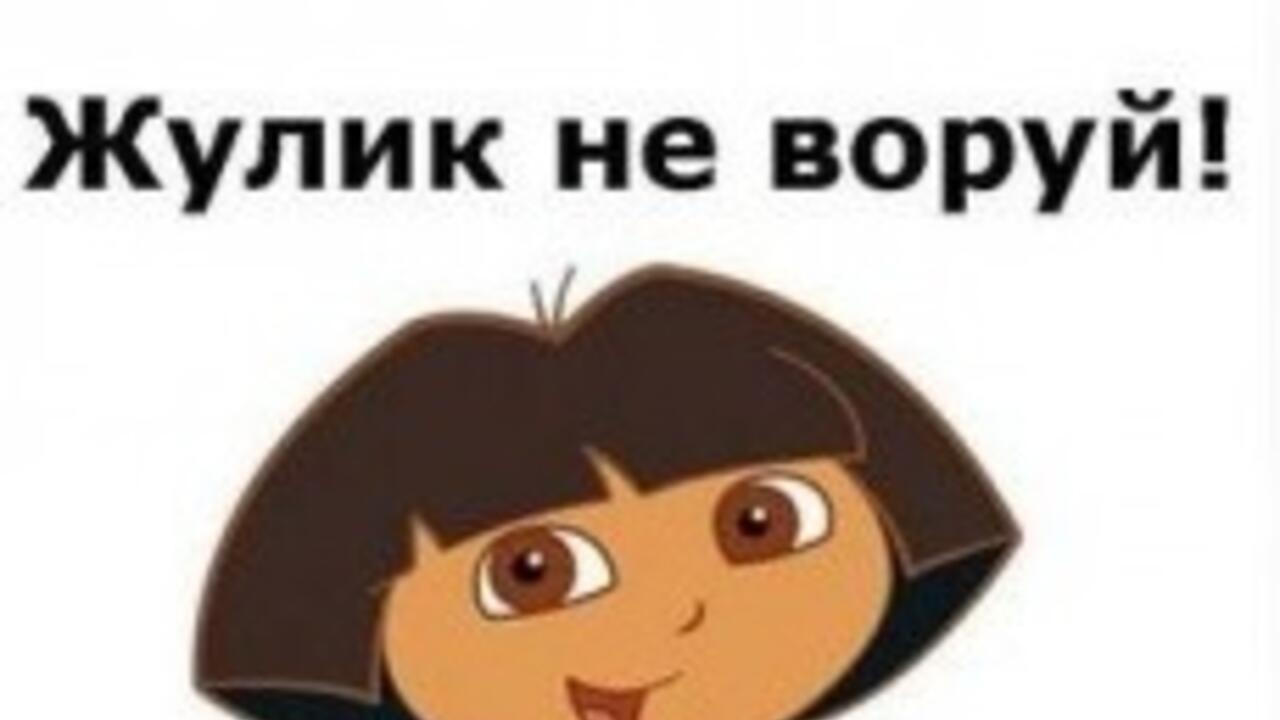

## задача 1) разведочный анализ данных (EDA): построить графики зависимости некоторых признаков друг от друга, график целевой переменной и матрицу корреляций, сделать выводы.

## Информация о данных

In [509]:
missing_train = train.isnull().sum()
missing_percent = 100 * missing_train / len(train)
missing_df = pd.DataFrame({
    'Признак': missing_train.index,
    'Пропусков': missing_train.values,
    'Процент': missing_percent.values
})
missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

if len(missing_df) > 0:
    styled = missing_df.style.format({
        'Пропусков': '{:d}',
        'Процент': '{:.2f}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
    ])
    print(f"\n  Пропуски в {len(missing_df)} признаках:")
    display(styled)
else:
    print("Пропущенных значений нет")



  Пропуски в 35 признаках:


#### Микровывод:
Пропуски в 35 признаках (80% от всех). 
Две группы:
- 9 признаков: 9.36% пропусков (финансовые и кредитные показатели)
- 26 признаков: 4.81% пропусков (включая целевую переменную RiskScore)

## Статистическое описание

In [510]:
# Описательная статистика числовых признаков
desc_stats = train.describe().T
styled_desc = desc_stats.style.format("{:.2f}").set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
])
display(styled_desc)

# Категориальные признаки
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"\nКатегориальные признаки: {categorical_cols}")

for col in categorical_cols:
    counts = train[col].value_counts()
    # styled_counts = pd.DataFrame({'Категория': counts.index, 'Количество': counts.values}).style.format({
    #     'Количество': '{:d}'
    # }).set_properties(**{
    #     'text-align': 'center',
    #     'color': 'white',
    #     'background-color': '#333'
    # }).set_table_styles([
    #     {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    #     {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    #     {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
    # ])
    # print(f"\n{col}:")
    display(styled_counts)



Категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


#### Микровывод:

**Числовые признаки** (29 шт.):
- Критичная проблема: RiskScore содержит экстремальные значения от **-10M до +10M** (среднее = -25,698), что указывает на **аномалии/ошибки ввода данных**
- Финансовые метрики имеют большой разброс: TotalAssets (892 - 11M), AnnualIncome (15K - 748K)
- Демографические признаки в нормальных диапазонах: Age (18-80), Experience (0-57)

**Категориальные признаки** (6 шт.):
- ApplicationDate: 10,000 уникальных дат - признак непригоден для прямого использования (требуется feature engineering: год, месяц, день недели)
- Остальные признаки сбалансированы:
  - MaritalStatus: Married (49%), Single (31%), Divorced (15%), Widowed (5%)
  - EmploymentStatus: Employed (86%), Self-Employed (9%), Unemployed (4%)
  - EducationLevel: относительно равномерное распределение

## Анализ целевой переменной RISKSCORE

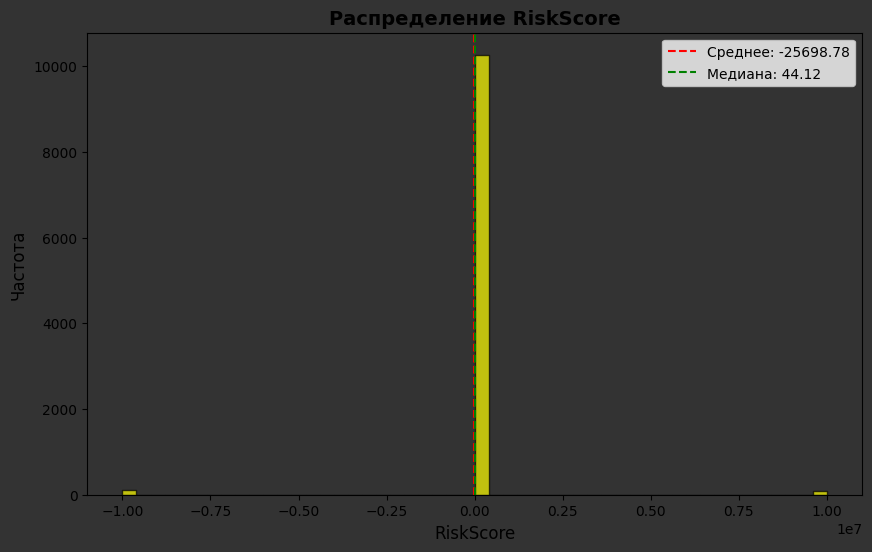

In [511]:


stats = pd.DataFrame({
    'Метрика': ['Среднее', 'Медиана', 'Стандартное отклонение', 'Минимум', 'Максимум', 'Асимметрия (skewness)', 'Эксцесс (kurtosis)'],
    'Значение': [
        train['RiskScore'].mean(),
        train['RiskScore'].median(),
        train['RiskScore'].std(),
        train['RiskScore'].min(),
        train['RiskScore'].max(),
        train['RiskScore'].skew(),
        train['RiskScore'].kurtosis()
    ]
})

styled = stats.style.format({
    'Значение': '{:.2f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
])

display(styled)

# График
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(train['RiskScore'], bins=50, color='yellow', edgecolor='black', alpha=0.7)
ax.set_xlabel('RiskScore', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)
ax.set_title('Распределение RiskScore', fontsize=14, fontweight='bold')
ax.axvline(train['RiskScore'].mean(), color='red', linestyle='--', 
           label=f'Среднее: {train["RiskScore"].mean():.2f}')
ax.axvline(train['RiskScore'].median(), color='green', linestyle='--', 
           label=f'Медиана: {train["RiskScore"].median():.2f}')
ax.legend()
ax.set_facecolor('#333')
fig.patch.set_facecolor('#333')
plt.show()


#### Микровывод:

**RiskScore имеет критичные аномалии:**
- Диапазон: -10M до +10M (явные placeholder-значения)
- Среднее (-25,699) vs Медиана (44.12) → **выбросы искажают статистику**
- Эксцесс 45.77 (норма ≈ 3) → **множественные выбросы**
- Медиана: **44.12** (более реалистичное значение для риск-скора)



##  корреляционный анализ


Корреляция всех признаков с RiskScore:


Максимальная положительная корреляция: 0.0191 (PaymentHistory)
Максимальная отрицательная корреляция: -0.0233 (NumberOfDependents)
Средняя абсолютная корреляция: 0.0075
Медианная абсолютная корреляция: 0.0058

Распределение силы корреляций:
  Сильная положительная (>0.1):       0 признаков
  Умеренная положительная (0.05-0.1): 0 признаков
  Слабая положительная (0-0.05):      15 признаков
  Слабая отрицательная (-0.05-0):     13 признаков
  Умеренная отрицательная (-0.1--0.05): 0 признаков
  Сильная отрицательная (<-0.1):      0 признаков

Топ-20 парных корреляций:



Общее количество уникальных пар признаков: 378

Распределение ВСЕХ парных корреляций по диапазонам:
  |r| в диапазоне 0.0-0.1:  349 пар (92.33%)
  |r| в диапазоне 0.1-0.2:    2 пар ( 0.53%)
  |r| в диапазоне 0.2-0.3:    5 пар ( 1.32%)
  |r| в диапазоне 0.3-0.4:    2 пар ( 0.53%)
  |r| в диапазоне 0.4-0.5:    3 пар ( 0.79%)
  |r| в диапазоне 0.5-0.6:    6 пар ( 1.59%)
  |r| в диапазоне 0.6-0.7:    4 пар ( 1.06%)
  |r| в диапазоне 0.7-0.8:    0 пар ( 0.00%)
  |r| в диапазоне 0.8-0.9:    1 пар ( 0.26%)
  |r| в диапазоне 0.9-1.0:    6 пар ( 1.59%)

ДЕТАЛЬНАЯ СТАТИСТИКА:
  Минимальная абсолютная корреляция: 0.000026
  Максимальная абсолютная корреляция: 0.994042
  Средняя абсолютная корреляция:     0.051546
  Медианная абсолютная корреляция:   0.007410
  Стд. отклонение:                   0.163392

Перцентили абсолютных корреляций:
  10%: 0.001133
  25%: 0.003485
  50%: 0.007410
  75%: 0.015515
  90%: 0.042013
  95%: 0.464266
  99%: 0.941793
  |r| > 0.1:   29 пар ( 7.67%)
  |r| > 0.2:   27


Кредитная история:



Параметры кредита:



Коэффициенты:



Демография:



Статистика корреляций по признакам:



Топ-10 признаков с наибольшей СРЕДНЕЙ корреляцией с другими:



Признаки с наибольшим количеством высоких корреляций:


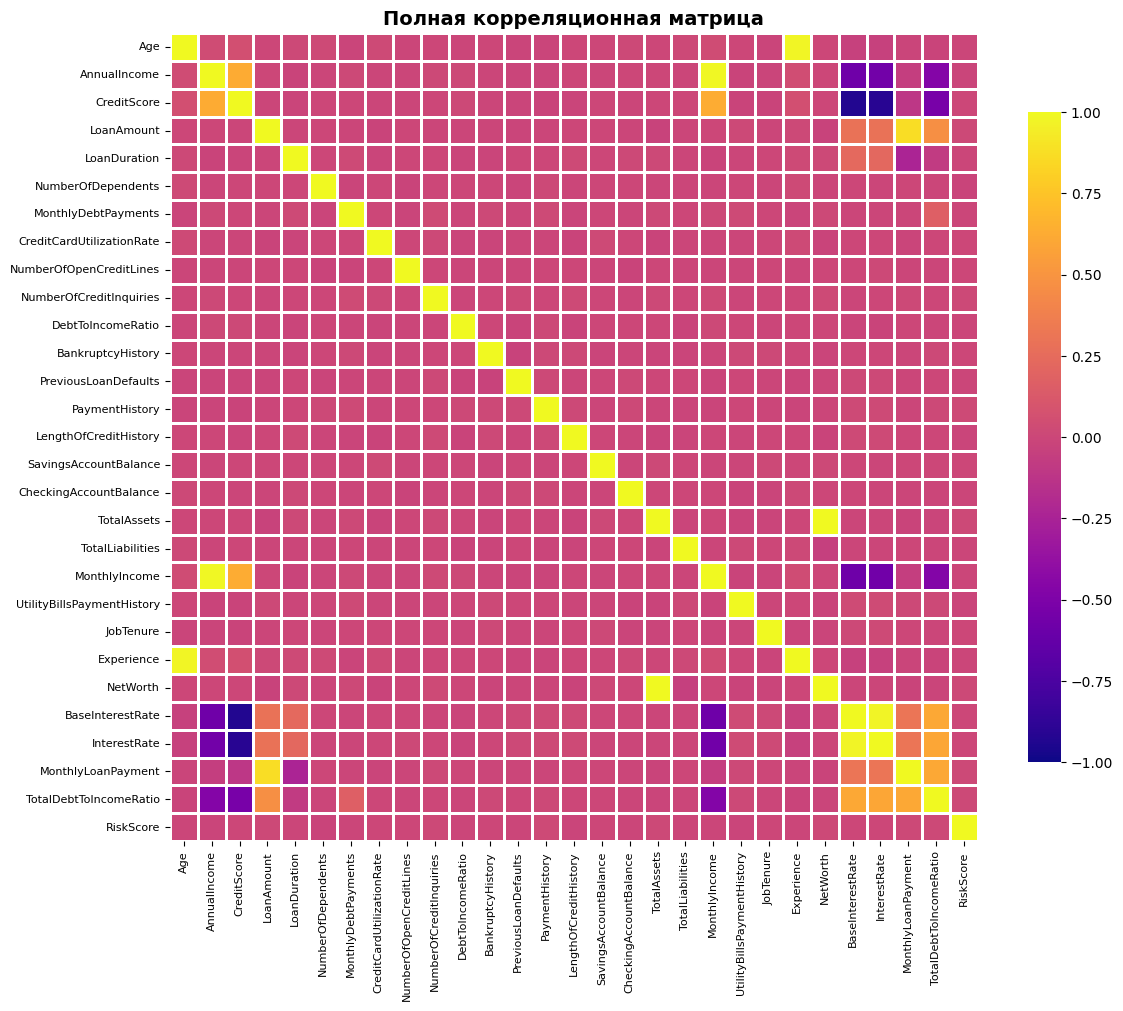

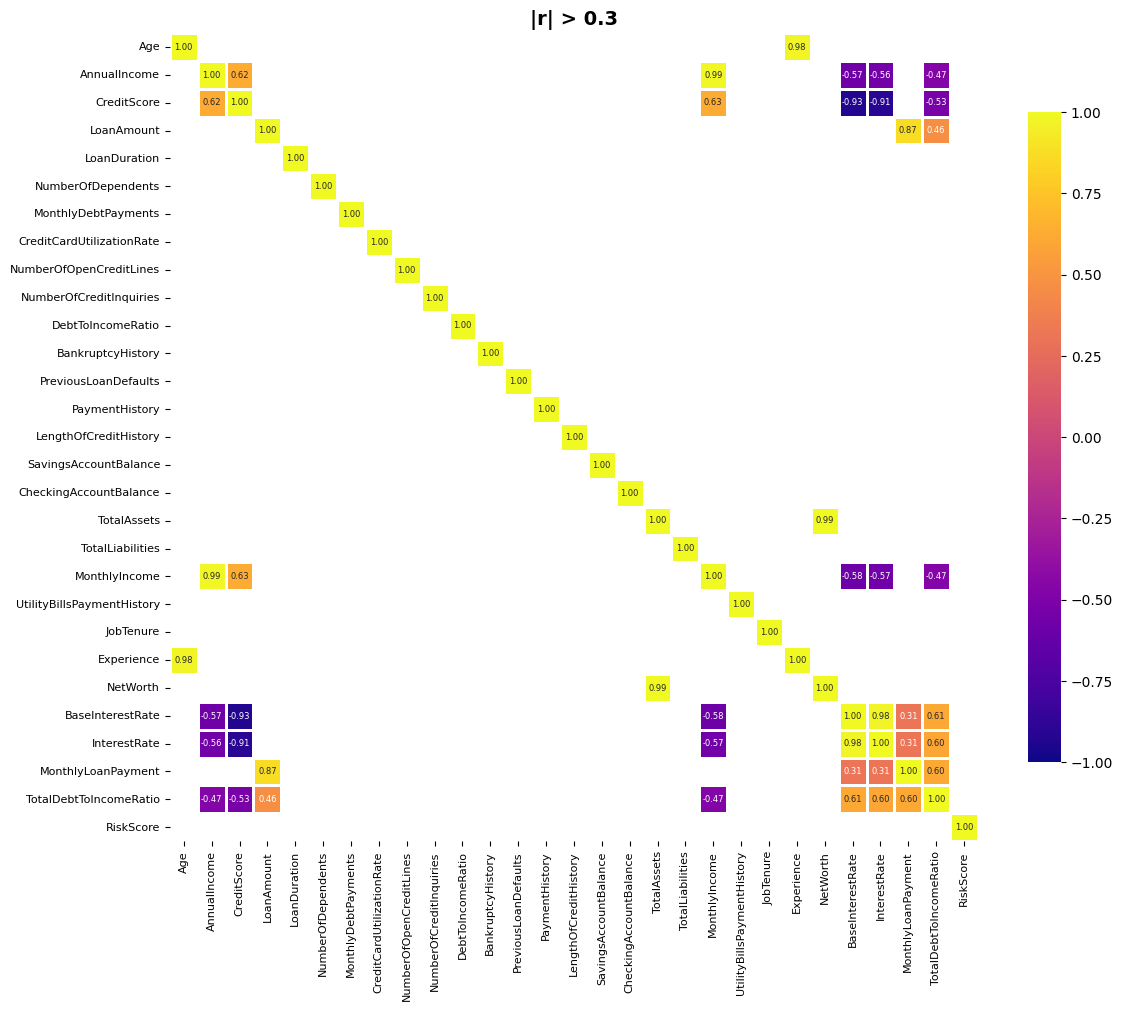

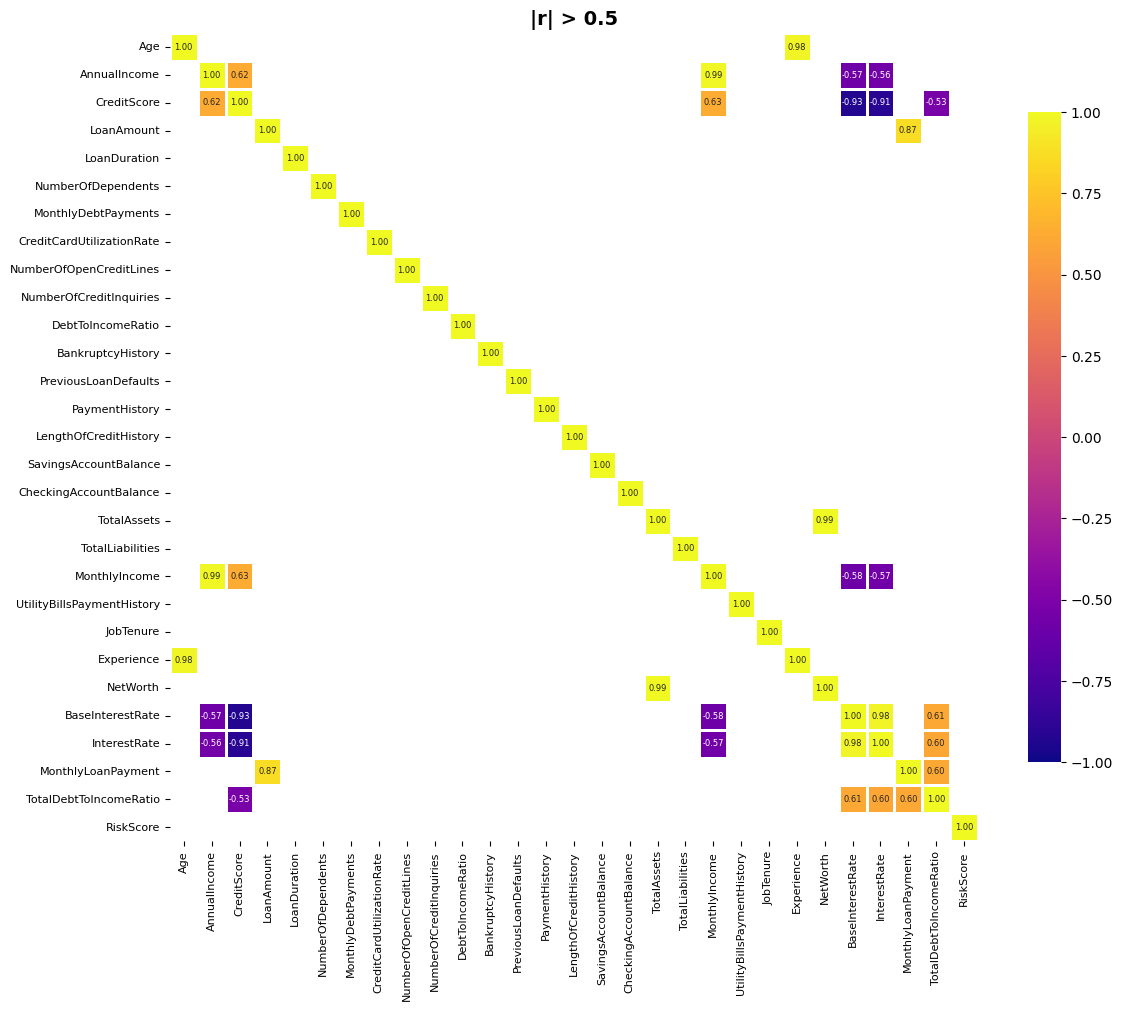

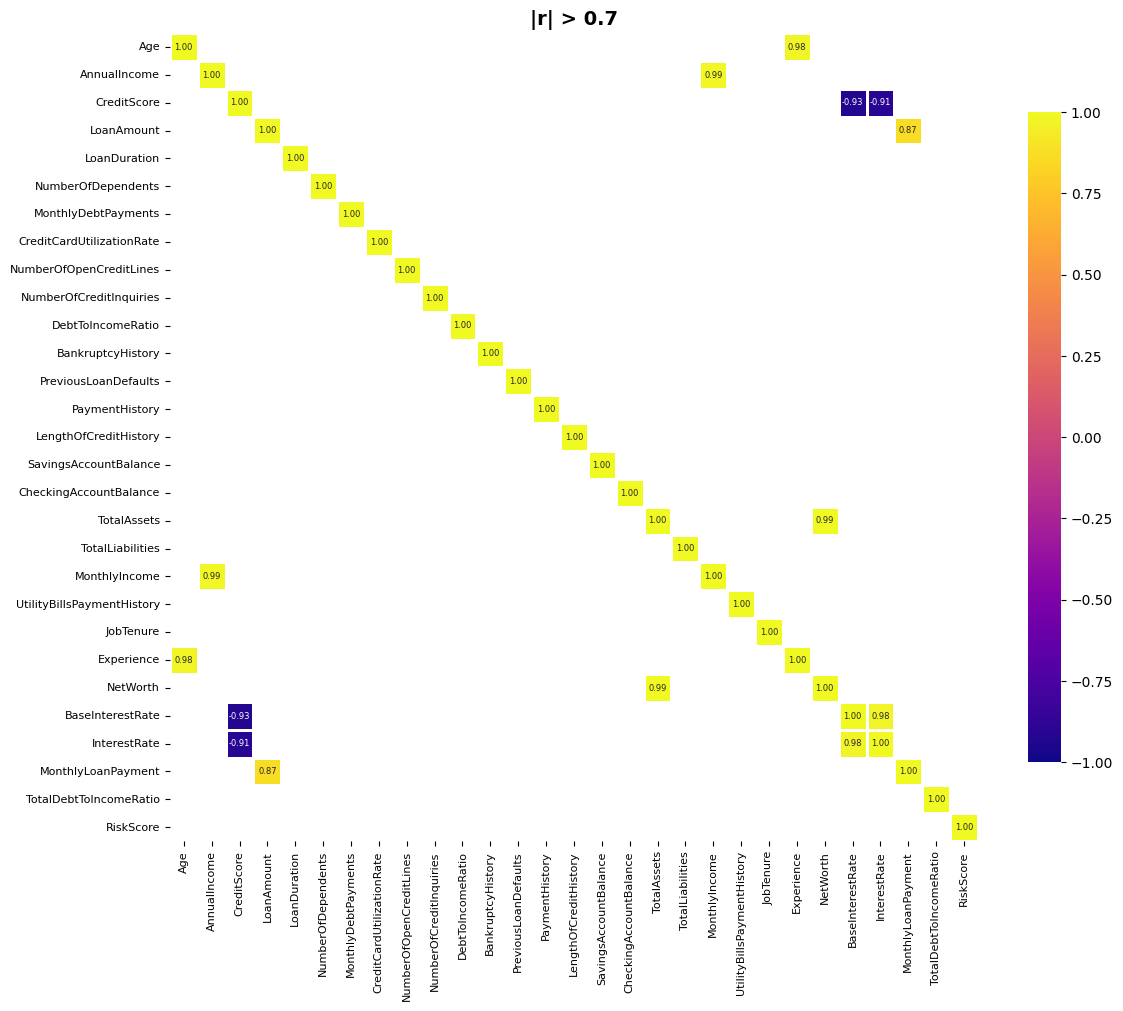

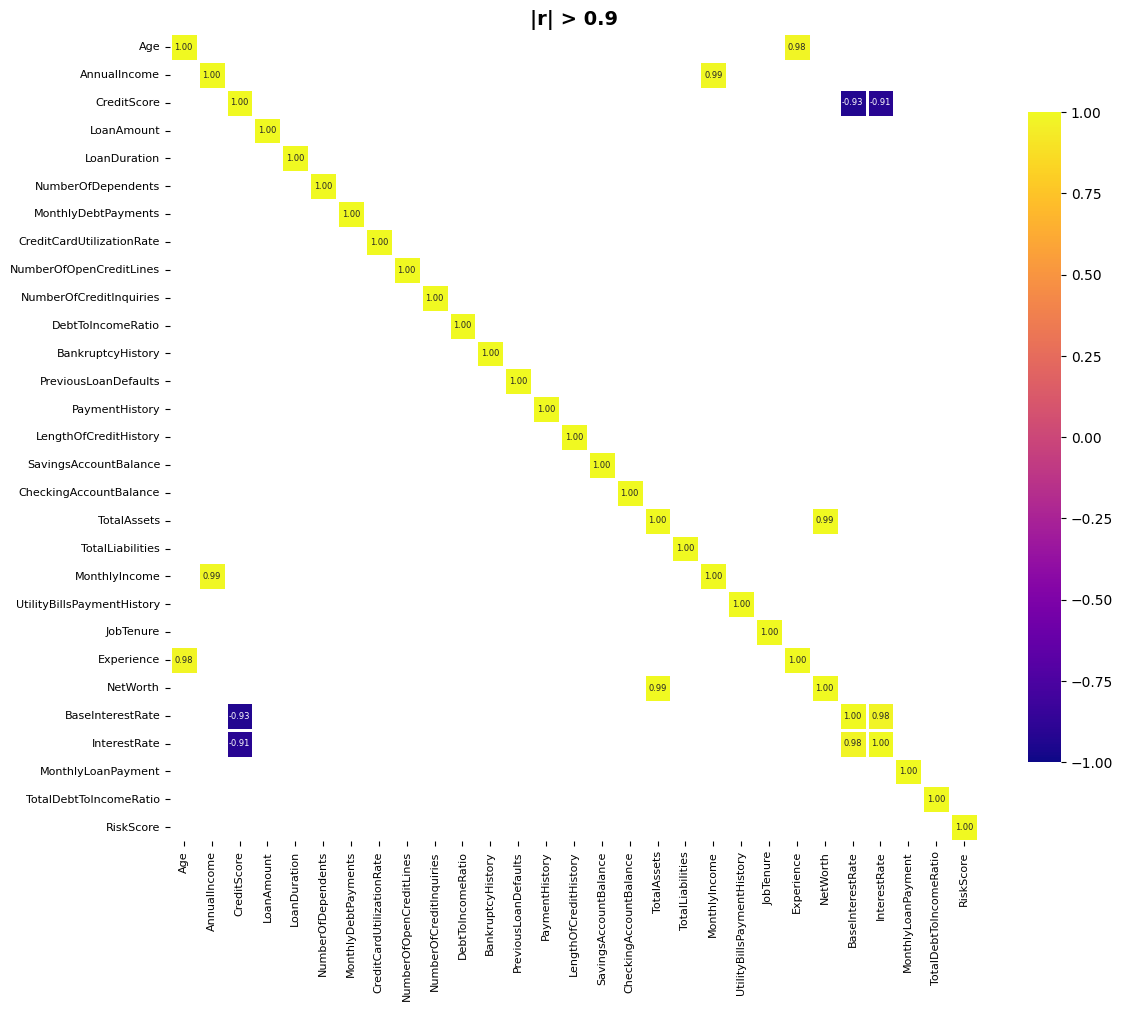

In [512]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')

# Анализ корреляций
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train[numeric_cols].corr()

# Корреляция с RiskScore
if 'RiskScore' in numeric_cols:
    correlations = correlation_matrix['RiskScore'].sort_values(ascending=False)
    
    # Оформление таблицы корреляций с RiskScore
    corr_with_risk = pd.DataFrame({
        'Признак': correlations.index,
        'Корреляция': correlations.values
    })
    styled_corr = corr_with_risk.style.format({
        'Корреляция': '{:.4f}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
    ])
    print("\nКорреляция всех признаков с RiskScore:")
    display(styled_corr)
    
    print(f"Максимальная положительная корреляция: {correlations[1]:.4f} ({correlations.index[1]})")
    print(f"Максимальная отрицательная корреляция: {correlations.iloc[-1]:.4f} ({correlations.index[-1]})")
    print(f"Средняя абсолютная корреляция: {correlations.drop('RiskScore').abs().mean():.4f}")
    print(f"Медианная абсолютная корреляция: {correlations.drop('RiskScore').abs().median():.4f}")
    
    # Категоризация корреляций
    strong_positive = correlations[(correlations > 0.1) & (correlations < 1.0)]
    moderate_positive = correlations[(correlations > 0.05) & (correlations <= 0.1)]
    weak_positive = correlations[(correlations > 0) & (correlations <= 0.05)]
    weak_negative = correlations[(correlations < 0) & (correlations >= -0.05)]
    moderate_negative = correlations[(correlations < -0.05) & (correlations >= -0.1)]
    strong_negative = correlations[correlations < -0.1]
    
    print(f"\nРаспределение силы корреляций:")
    print(f"  Сильная положительная (>0.1):       {len(strong_positive)} признаков")
    print(f"  Умеренная положительная (0.05-0.1): {len(moderate_positive)} признаков")
    print(f"  Слабая положительная (0-0.05):      {len(weak_positive)} признаков")
    print(f"  Слабая отрицательная (-0.05-0):     {len(weak_negative)} признаков")
    print(f"  Умеренная отрицательная (-0.1--0.05): {len(moderate_negative)} признаков")
    print(f"  Сильная отрицательная (<-0.1):      {len(strong_negative)} признаков")
    
    if len(strong_positive) > 0:
        print(f"\nСИЛЬНО коррелированные признаки (>0.1):")
        strong_pos_df = pd.DataFrame({
            'Признак': strong_positive.index,
            'Корреляция': strong_positive.values
        }).sort_values('Корреляция', ascending=False)
        styled_strong = strong_pos_df.style.format({
            'Корреляция': '{:.4f}'
        }).set_properties(**{
            'text-align': 'center',
            'color': 'white',
            'background-color': '#333'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
            {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
        ])
        display(styled_strong)
    
    if len(strong_negative) > 0:
        print(f"\nСИЛЬНО отрицательно коррелированные признаки (<-0.1):")
        strong_neg_df = pd.DataFrame({
            'Признак': strong_negative.index,
            'Корреляция': strong_negative.values
        }).sort_values('Корреляция', ascending=True)
        styled_neg = strong_neg_df.style.format({
            'Корреляция': '{:.4f}'
        }).set_properties(**{
            'text-align': 'center',
            'color': 'white',
            'background-color': '#333'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
            {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
        ])
        display(styled_neg)

# Анализ всех парных корреляций
all_pairs = []
features = [col for col in numeric_cols if col != 'RiskScore']

for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_value = correlation_matrix.loc[features[i], features[j]]
        all_pairs.append({
            'Feature_1': features[i],
            'Feature_2': features[j],
            'Correlation': corr_value,
            'Abs_Correlation': abs(corr_value)
        })

all_pairs_df = pd.DataFrame(all_pairs)

# Оформление таблицы парных корреляций
styled_pairs = all_pairs_df.sort_values('Abs_Correlation', ascending=False).head(20).style.format({
    'Correlation': '{:.4f}',
    'Abs_Correlation': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
])
print("\nТоп-20 парных корреляций:")
display(styled_pairs)

# Детальная статистика
print(f"\nОбщее количество уникальных пар признаков: {len(all_pairs_df)}")

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

all_pairs_df['Corr_Range'] = pd.cut(all_pairs_df['Abs_Correlation'], bins=bins, labels=labels)
distribution = all_pairs_df['Corr_Range'].value_counts().sort_index()

print("\nРаспределение ВСЕХ парных корреляций по диапазонам:")
for range_label, count in distribution.items():
    percentage = (count / len(all_pairs_df)) * 100
    print(f"  |r| в диапазоне {range_label}: {count:4d} пар ({percentage:5.2f}%)")

print(f"\nДЕТАЛЬНАЯ СТАТИСТИКА:")
print(f"  Минимальная абсолютная корреляция: {all_pairs_df['Abs_Correlation'].min():.6f}")
print(f"  Максимальная абсолютная корреляция: {all_pairs_df['Abs_Correlation'].max():.6f}")
print(f"  Средняя абсолютная корреляция:     {all_pairs_df['Abs_Correlation'].mean():.6f}")
print(f"  Медианная абсолютная корреляция:   {all_pairs_df['Abs_Correlation'].median():.6f}")
print(f"  Стд. отклонение:                   {all_pairs_df['Abs_Correlation'].std():.6f}")

percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\nПерцентили абсолютных корреляций:")
for p in percentiles:
    val = all_pairs_df['Abs_Correlation'].quantile(p/100)
    print(f"  {p:2d}%: {val:.6f}")

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    count = (all_pairs_df['Abs_Correlation'] > threshold).sum()
    percentage = (count / len(all_pairs_df)) * 100
    print(f"  |r| > {threshold:.1f}: {count:4d} пар ({percentage:5.2f}%)")

# Группировка признаков
feature_groups = {
    'Финансовые показатели': ['AnnualIncome', 'MonthlyIncome', 'SavingsAccountBalance', 
                               'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 
                               'NetWorth', 'MonthlyDebtPayments'],
    'Кредитная история': ['CreditScore', 'PaymentHistory', 'LengthOfCreditHistory', 
                          'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
                          'CreditCardUtilizationRate', 'PreviousLoanDefaults', 'BankruptcyHistory'],
    'Параметры кредита': ['LoanAmount', 'LoanDuration', 'InterestRate', 'BaseInterestRate',
                          'MonthlyLoanPayment'],
    'Коэффициенты': ['DebtToIncomeRatio', 'TotalDebtToIncomeRatio'],
    'Демография': ['Age', 'Experience', 'NumberOfDependents', 'JobTenure'],
    'Прочее': ['UtilityBillsPaymentHistory']
}

for group_name, group_features in feature_groups.items():
    available_features = [f for f in group_features if f in numeric_cols]
    if len(available_features) > 1:
        print(f"\n{group_name}:")
        group_corr = correlation_matrix.loc[available_features, available_features]
        group_pairs = []
        for i in range(len(available_features)):
            for j in range(i+1, len(available_features)):
                corr_val = group_corr.iloc[i, j]
                group_pairs.append({
                    'Feature_1': available_features[i],
                    'Feature_2': available_features[j],
                    'Correlation': corr_val
                })
        group_pairs_df = pd.DataFrame(group_pairs)
        styled_group = group_pairs_df.style.format({
            'Correlation': '{:.4f}'
        }).set_properties(**{
            'text-align': 'center',
            'color': 'white',
            'background-color': '#333'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
            {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
        ])
        display(styled_group)

# Статистика по признакам
feature_corr_stats = []
for feature in features:
    feature_corrs = correlation_matrix[feature].drop(feature).abs()
    feature_corr_stats.append({
        'Feature': feature,
        'Mean_Abs_Corr': feature_corrs.mean(),
        'Median_Abs_Corr': feature_corrs.median(),
        'Max_Abs_Corr': feature_corrs.max(),
        'Min_Abs_Corr': feature_corrs.min(),
        'Corr_>0.3': (feature_corrs > 0.3).sum(),
        'Corr_>0.5': (feature_corrs > 0.5).sum(),
        'Corr_>0.7': (feature_corrs > 0.7).sum(),
        'RiskScore_Corr': correlation_matrix.loc[feature, 'RiskScore']
    })

corr_stats_df = pd.DataFrame(feature_corr_stats).sort_values('Max_Abs_Corr', ascending=False)
styled_corr_stats = corr_stats_df.style.format({
    'Mean_Abs_Corr': '{:.4f}',
    'Median_Abs_Corr': '{:.4f}',
    'Max_Abs_Corr': '{:.4f}',
    'Min_Abs_Corr': '{:.4f}',
    'Corr_>0.3': '{:d}',
    'Corr_>0.5': '{:d}',
    'Corr_>0.7': '{:d}',
    'RiskScore_Corr': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
])
print("\nСтатистика корреляций по признакам:")
display(styled_corr_stats)

print("\nТоп-10 признаков с наибольшей СРЕДНЕЙ корреляцией с другими:")
top_mean = corr_stats_df.nlargest(10, 'Mean_Abs_Corr')
styled_top_mean = top_mean[['Feature', 'Mean_Abs_Corr', 'Max_Abs_Corr']].style.format({
    'Mean_Abs_Corr': '{:.4f}',
    'Max_Abs_Corr': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
])
display(styled_top_mean)

print("\nПризнаки с наибольшим количеством высоких корреляций:")
multicoll = corr_stats_df[corr_stats_df['Corr_>0.5'] > 0].sort_values('Corr_>0.5', ascending=False)
if len(multicoll) > 0:
    styled_multicoll = multicoll[['Feature', 'Corr_>0.3', 'Corr_>0.5', 'Corr_>0.7', 'Max_Abs_Corr']].style.format({
        'Corr_>0.3': '{:d}',
        'Corr_>0.5': '{:d}',
        'Corr_>0.7': '{:d}',
        'Max_Abs_Corr': '{:.4f}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]}
    ])
    display(styled_multicoll)
else:
    print("Признаков с корреляциями >0.5 не найдено")

# Графики
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='plasma', center=0,
            linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
            square=True)
plt.title('Полная корреляционная матрица', fontweight='bold', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

thresholds_viz = [0.3, 0.5, 0.7, 0.9]
for threshold in thresholds_viz:
    mask = np.abs(correlation_matrix) < threshold
    corr_masked = correlation_matrix.copy()
    corr_masked[mask] = np.nan
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_masked, annot=True, fmt='.2f', cmap='plasma', center=0,
                linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
                square=True, annot_kws={"size": 6})
    plt.title(f'|r| > {threshold}', fontweight='bold', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# Сохранение результатов
correlation_matrix.to_csv('correlation_matrix_full.csv')
all_pairs_df.sort_values('Abs_Correlation', ascending=False).to_csv('all_correlation_pairs.csv', index=False)
corr_stats_df.to_csv('feature_correlation_stats.csv', index=False)
all_pairs_df.nlargest(50, 'Abs_Correlation').to_csv('top50_correlations.csv', index=False)


#### Микровывод: Корреляционный анализ

**Критическая находка #1: Крайне слабая связь с целевой переменной**

Все 28 числовых признаков демонстрируют **исключительно слабую корреляцию** с `RiskScore`. Максимальная положительная корреляция составляет всего **0.019** (`PaymentHistory`), максимальная отрицательная — **-0.023** (`NumberOfDependents`). Средняя абсолютная корреляция с целевой переменной равна **0.0075**, медианная — **0.0058**. Ни один признак не демонстрирует корреляции выше **0.05** по модулю. Это указывает на одну из трёх проблем: либо связь между признаками и целевой переменной **нелинейная** и не улавливается корреляцией Пирсона, либо целевая переменная содержит **слишком много шума** из-за аномалий, либо **признаки недостаточно информативны** для предсказания риск-скора.

**Критическая находка #2: Мультиколлинеарность высокой степени**
Обнаружено **6 пар признаков** с корреляцией выше **0.9**, что представляет собой **критическую мультиколлинеарность**. Пара `TotalAssets` и `NetWorth` демонстрирует корреляцию **0.994** — это практически идентичные признаки, один из них необходимо удалить. Аналогично `AnnualIncome` и `MonthlyIncome` коррелируют на уровне **0.985** (логично, так как годовой доход примерно равен месячному, умноженному на 12). Пара `Age` и `Experience` показывает корреляцию **0.983** — опыт работы напрямую зависит от возраста. Процентные ставки `BaseInterestRate` и `InterestRate` коррелируют на **0.975**, что также ожидаемо. Особенно интересна сильная отрицательная корреляция между `CreditScore` и процентными ставками: **-0.932** с `BaseInterestRate` и **-0.908** с `InterestRate` — чем выше кредитный рейтинг, тем ниже процентная ставка, что соответствует финансовой логике. Наконец, `LoanAmount` и `MonthlyLoanPayment` коррелируют на **0.873**, так как размер ежемесячного платежа прямо зависит от суммы кредита.

**Общее распределение корреляций между признаками**
 Подавляющее большинство — **92.33%** (349 пар) — имеют абсолютную корреляцию ниже **0.1**, что свидетельствует о том, что признаки в основном **независимы друг от друга**. Лишь **7.67%** пар (29 пар) превышают порог **0.1**, и только **1.59%** (6 пар) находятся в критической зоне выше **0.9**. Средняя абсолютная корреляция между всеми парами составляет **0.052**, медианная — **0.007**, что подтверждает общую **слабую взаимосвязь** между большинством признаков. Распределение корреляций сильно смещено к нулю: 75-й перцентиль равен всего **0.016**, 90-й — **0.042**, и только 95-й перцентиль достигает **0.464**. Это означает, что проблемы мультиколлинеарности касаются лишь **небольшого количества** конкретных пар признаков, которые можно идентифицировать и устранить.

**Группы признаков с высокой внутренней корреляцией**
Внутри группы **финансовых показателей** критична связка `TotalAssets` — `NetWorth` (0.994) и умеренная связь `AnnualIncome` — `MonthlyIncome` (0.985). Остальные финансовые метрики практически независимы друг от друга: корреляции между балансами счетов, сбережениями и обязательствами не превышают **0.02**. В группе **параметров кредита** наблюдается ожидаемая высокая корреляция между процентными ставками (0.975) и между суммой кредита и ежемесячным платежом (0.873). Интересно, что `LoanDuration` слабо коррелирует с остальными параметрами кредита, что делает его **относительно независимым** признаком. В **демографической группе** доминирует пара `Age` — `Experience` (0.983), в то время как `NumberOfDependents` и `JobTenure` показывают слабые связи со всеми признаками. Группа **кредитной истории** демонстрирует удивительно **низкие внутренние корреляции**: ни одна пара не превышает **0.023** по модулю, что говорит о том, что эти признаки измеряют **разные аспекты** кредитоспособности и все потенциально полезны.

**Признаки с наибольшим числом связей**
Признак `TotalDebtToIncomeRatio` имеет наибольшее количество связей: **7 корреляций выше 0.3** и **4 выше 0.5**. Он сильно связан с процентными ставками (0.60), ежемесячным платежом (0.60), отрицательно — с `CreditScore` (-0.53) и доходами (-0.47). Процентные ставки (`InterestRate` и `BaseInterestRate`) также являются "хабами" корреляций: по **6 связей выше 0.3** и **5 выше 0.5** у каждого. `CreditScore` имеет **5 сильных связей**, включая отрицательные с процентными ставками и положительную с доходами (0.62). Доходы (`AnnualIncome` и `MonthlyIncome`) также входят в топ по количеству связей. Напротив, признаки вроде `SavingsAccountBalance`, `CheckingAccountBalance`, `JobTenure` и большинство параметров кредитной истории имеют **минимальные связи** с другими признаками (средняя абсолютная корреляция 0.005-0.011), что делает их **независимыми источниками** информации.


## SCATTER PLOTS - ЗАВИСИМОСТИ ПРИЗНАКОВ


Используются результаты корреляционного анализа из CSV файлов

Признаков с |корреляцией| > 0.001: 26

Выбраны признаки для визуализации (по убыванию |корреляции|):
                   Feature  RiskScore_Corr
        NumberOfDependents       -0.023314
            PaymentHistory        0.019144
    TotalDebtToIncomeRatio        0.013879
UtilityBillsPaymentHistory       -0.013865
        MonthlyLoanPayment        0.012366
                LoanAmount        0.011771
   NumberOfCreditInquiries        0.011055
     LengthOfCreditHistory       -0.009448
                  NetWorth        0.008804
              AnnualIncome       -0.008460
               TotalAssets        0.008092
     SavingsAccountBalance        0.007611
         DebtToIncomeRatio       -0.007417
             MonthlyIncome       -0.006145
 CreditCardUtilizationRate        0.005501
      PreviousLoanDefaults       -0.005409
                Experience       -0.005408
         BankruptcyHistory        0.005184
          TotalLia

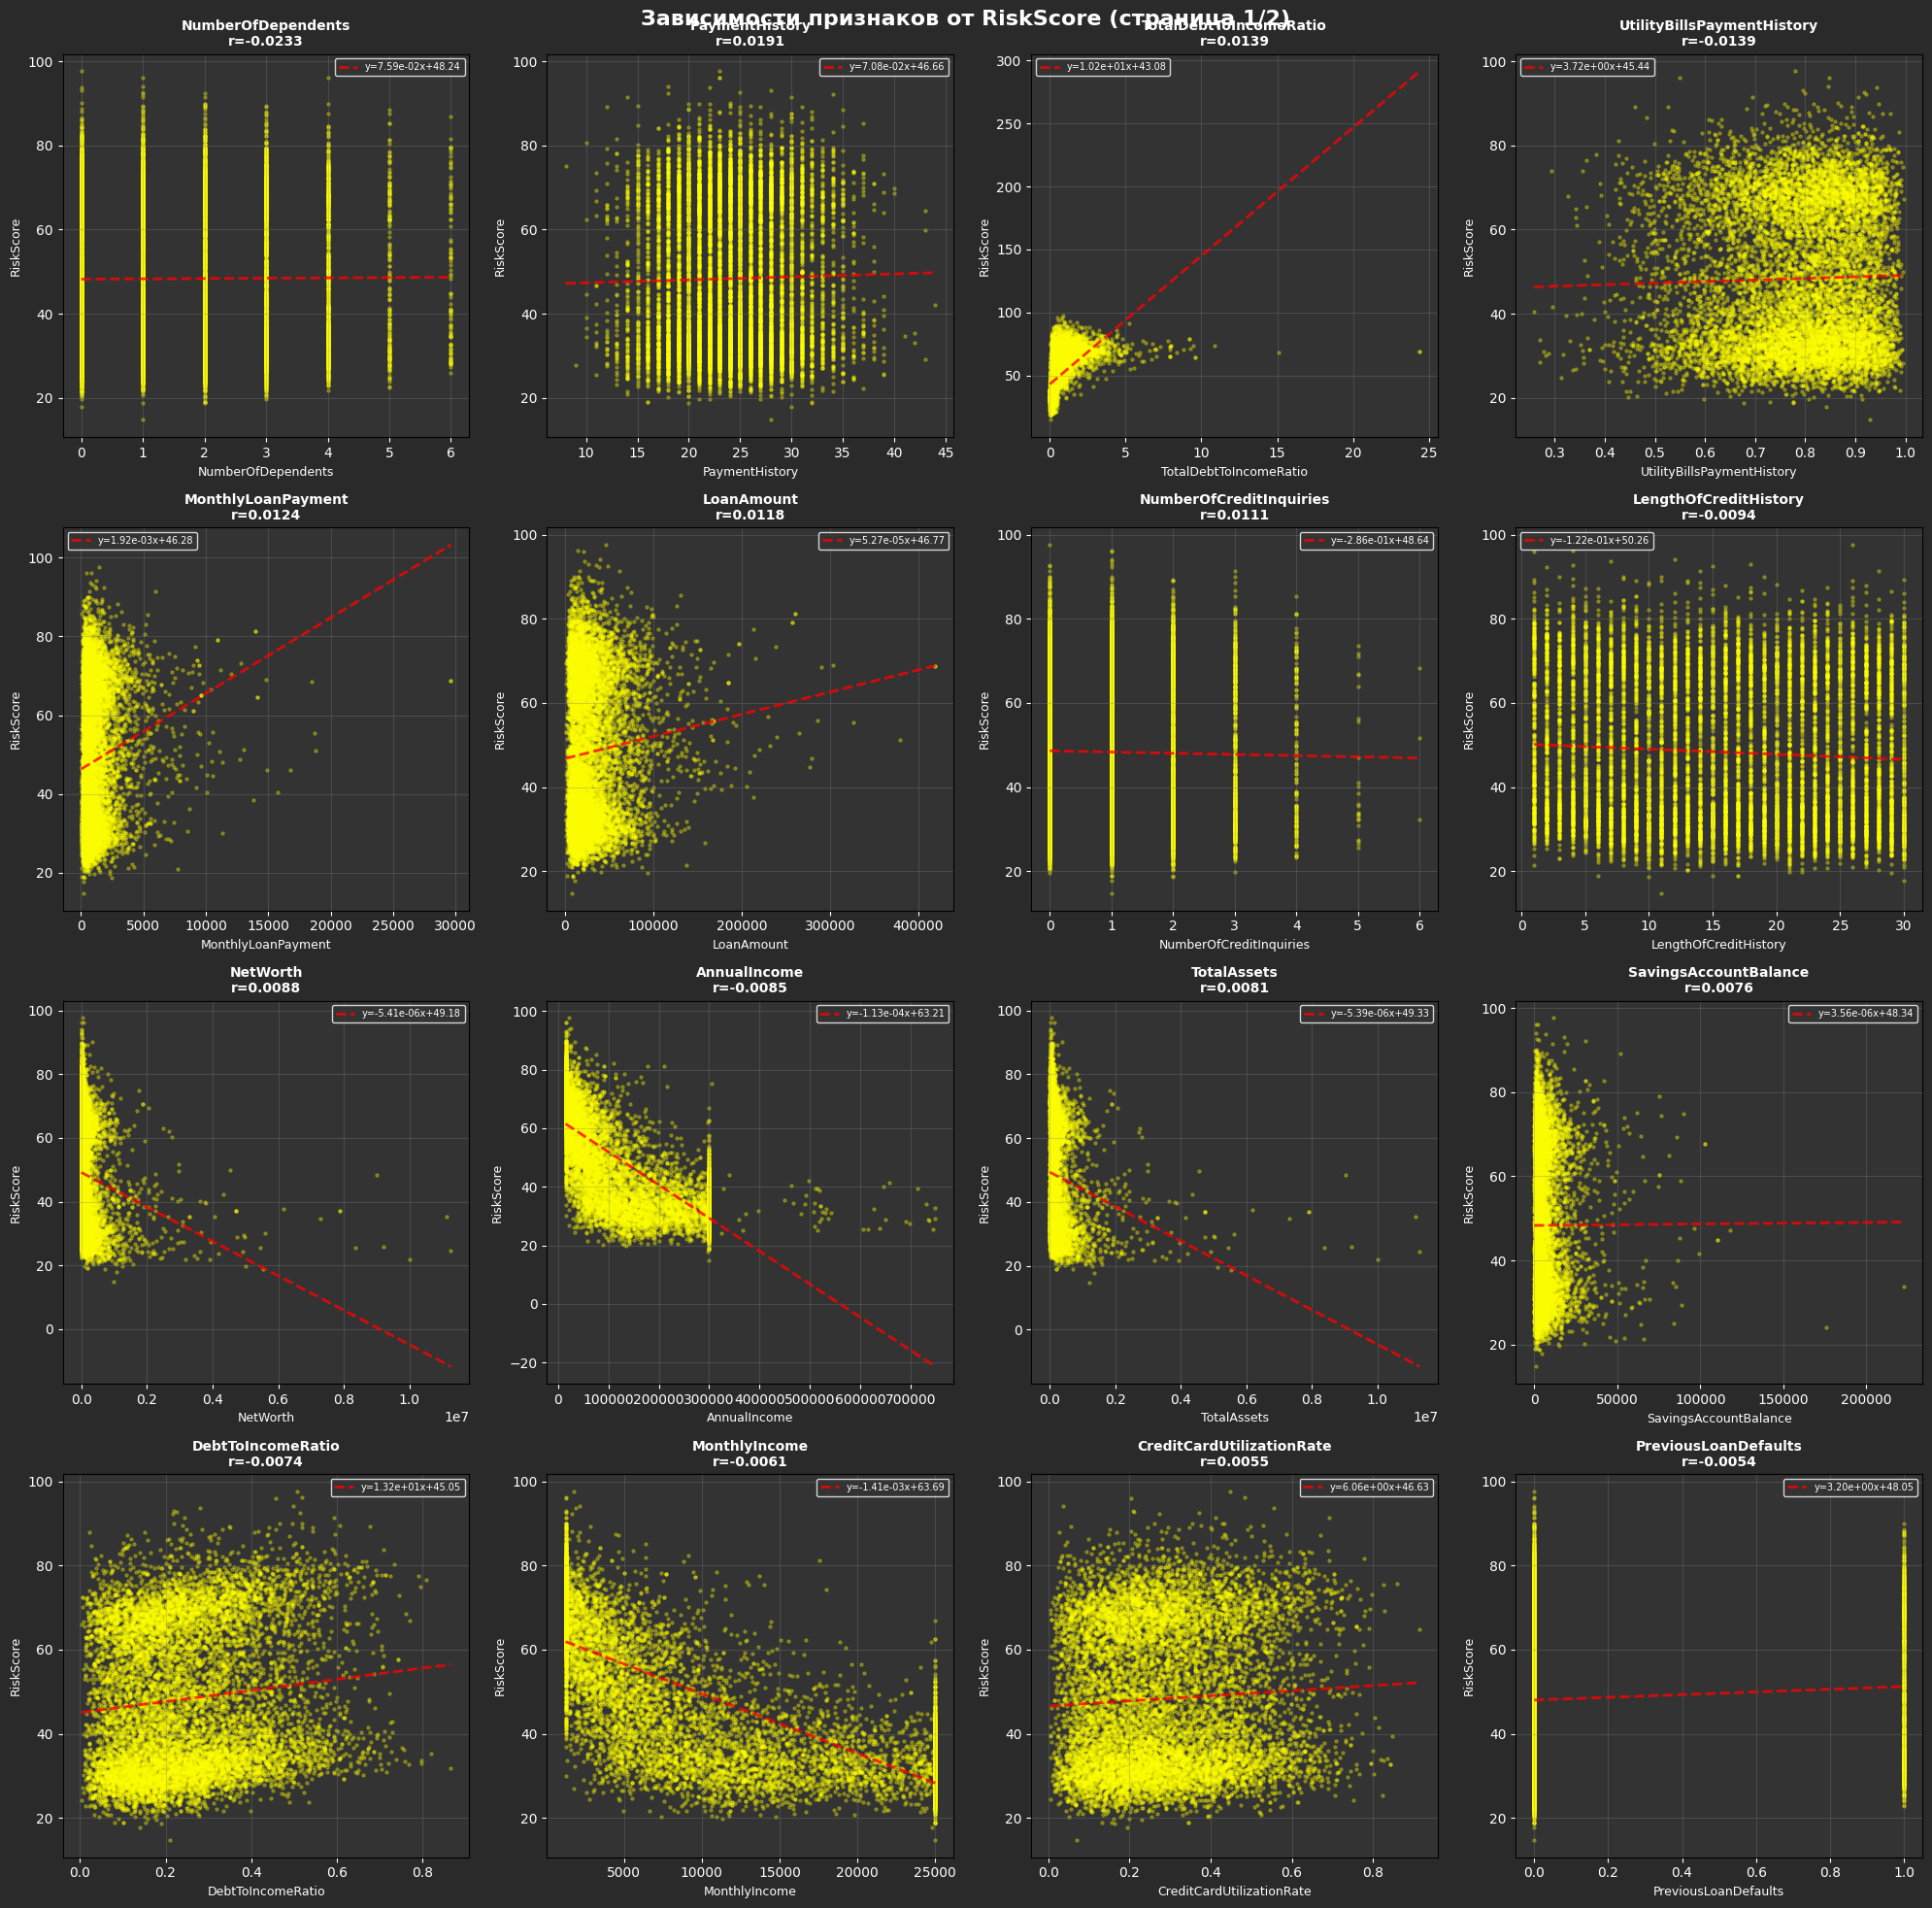

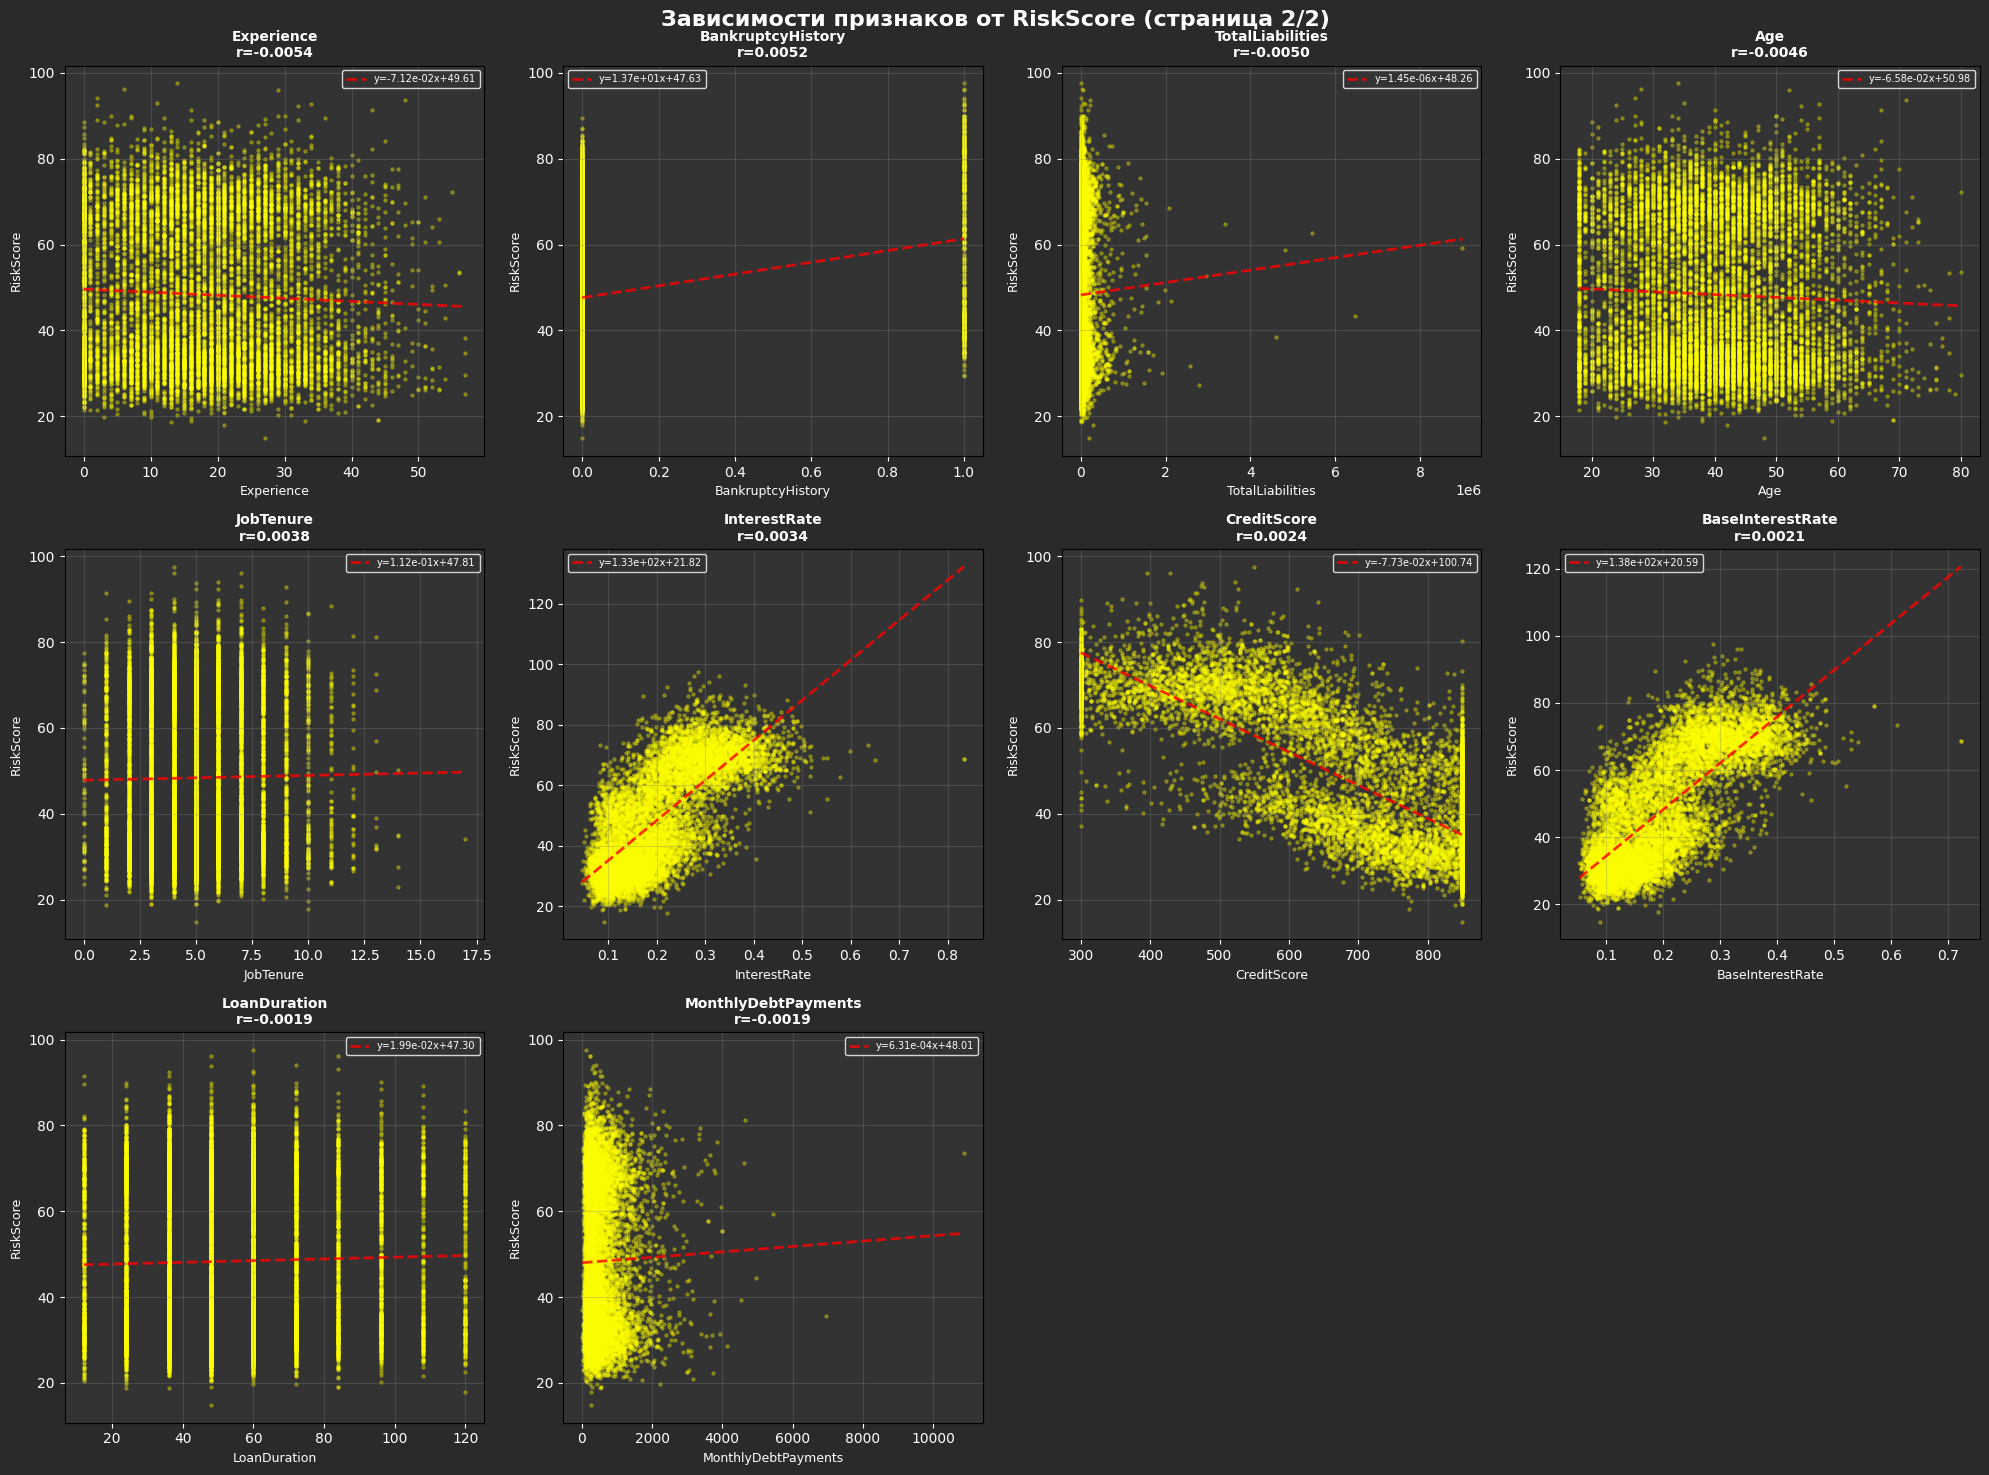

In [513]:
try:
    feature_stats = pd.read_csv('feature_correlation_stats.csv')
    all_pairs = pd.read_csv('all_correlation_pairs.csv')
    print("\nИспользуются результаты корреляционного анализа из CSV файлов")
except FileNotFoundError:
    print("\nВНИМАНИЕ: CSV файлы не найдены, используется прямой расчет")
    feature_stats = corr_stats_df
    all_pairs = all_pairs_df

# Сортируем признаки по абсолютной корреляции с RiskScore
features_by_corr = feature_stats.sort_values('RiskScore_Corr', key=abs, ascending=False)

# Фильтруем признаки с минимальной значимой корреляцией
significant_features = features_by_corr[abs(features_by_corr['RiskScore_Corr']) > 0.001]

print(f"\nПризнаков с |корреляцией| > 0.001: {len(significant_features)}")
print(f"\nВыбраны признаки для визуализации (по убыванию |корреляции|):")
print(significant_features[['Feature', 'RiskScore_Corr']].head(20).to_string(index=False))

# Работаем с нормальным диапазоном RiskScore
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()
print(f"\nДанные для анализа: {len(clean_train)} записей (без аномалий)")
print(f"Исключено аномалий: {len(train) - len(clean_train)} ({(len(train) - len(clean_train))/len(train)*100:.1f}%)")

# Берем все признаки с минимальной корреляцией
features_to_plot = significant_features['Feature'].values
num_features = len(features_to_plot)
plots_per_page = 16
num_pages = (num_features + plots_per_page - 1) // plots_per_page

print(f"\nБудет создано {num_pages} графиков с scatter plots")

for page in range(num_pages):
    start_idx = page * plots_per_page
    end_idx = min((page + 1) * plots_per_page, num_features)
    page_features = features_to_plot[start_idx:end_idx]
    
    n_features = len(page_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), facecolor='#2a2a2a')
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for idx, feature in enumerate(page_features):
        if feature not in clean_train.columns:
            continue
            
        corr_value = features_by_corr[features_by_corr['Feature'] == feature]['RiskScore_Corr'].values[0]
        
        # Удаляем пропуски
        mask = clean_train[[feature, 'RiskScore']].notna().all(axis=1)
        x_data = clean_train.loc[mask, feature]
        y_data = clean_train.loc[mask, 'RiskScore']
        
        if len(x_data) > 0:
            # Scatter plot с жёлтыми кружочками
            axes[idx].scatter(x_data, y_data, alpha=0.3, s=5, color='yellow')
            
            # Линия тренда
            try:
                z = np.polyfit(x_data, y_data, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_data.min(), x_data.max(), 100)
                axes[idx].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, 
                              label=f'y={z[0]:.2e}x+{z[1]:.2f}')
            except:
                pass
            
            axes[idx].set_xlabel(feature, fontsize=9, color='white')
            axes[idx].set_ylabel('RiskScore', fontsize=9, color='white')
            axes[idx].set_title(f'{feature}\nr={corr_value:.4f}', 
                              fontweight='bold', fontsize=10, color='white')
            axes[idx].grid(True, alpha=0.3, color='gray')
            axes[idx].legend(fontsize=7, facecolor='#333', edgecolor='white', labelcolor='white')
            axes[idx].set_facecolor('#333')
            axes[idx].tick_params(colors='white')
    
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(f'Зависимости признаков от RiskScore (страница {page+1}/{num_pages})', 
                 fontsize=16, fontweight='bold', color='white')
    plt.tight_layout()
    plt.show()


#### Микровывод: Визуальный анализ зависимостей после очистки данных

**Результаты очистки целевой переменной**

После исключения аномальных значений RiskScore (выходящих за пределы диапазона 0-200) из анализа было удалено **745 записей** (6.8% от общего объёма), что оставило **10,272 наблюдения** с корректными значениями целевой переменной. Однако это не привело к ожидаемому улучшению корреляционной структуры. Максимальная абсолютная корреляция по-прежнему составляет всего **0.023** для признака `NumberOfDependents`, а все остальные признаки демонстрируют ещё более слабые связи. Таким образом, гипотеза о том, что экстремальные выбросы в RiskScore маскируют истинные корреляции, **не подтвердилась**.

**Визуальная картина зависимостей**

Построенные scatter plots для всех 26 значимых признаков наглядно демонстрируют **отсутствие линейных зависимостей** с целевой переменной. Точки на всех графиках образуют **диффузные облака** без выраженной структуры или направленности. Линии регрессии, добавленные для визуализации тренда, оказываются практически **горизонтальными** с минимальными наклонами, близкими к нулю. Это визуально подтверждает численные значения корреляций Пирсона и указывает на то, что простые линейные модели будут неэффективны для предсказания RiskScore на основе отдельных признаков.

**Топ-признаки и их характеристики**

Даже признаки с относительно наибольшими корреляциями демонстрируют крайне слабую предсказательную силу. `NumberOfDependents` (r = -0.023) показывает едва заметную отрицательную связь — чем больше иждивенцев, тем незначительно ниже риск-скор, но эффект настолько мал, что практически неразличим на фоне общего разброса данных. `PaymentHistory` (r = 0.019) — второй по значимости признак — также не демонстрирует чёткой зависимости на scatter plot. `TotalDebtToIncomeRatio` (r = 0.014) практически не влияет на целевую переменную линейным образом. Важно отметить, что **все 26 признаков** имеют корреляции меньше **0.025 по модулю**, что квалифицируется как **крайне слабая** или **отсутствующая** линейная связь по любым статистическим стандартам.

**Интерпретация отсутствия линейных связей**

Стабильно слабые корреляции даже после очистки данных указывают на несколько возможных сценариев. Во-первых, связь между признаками и RiskScore может быть **нелинейной и сложной** — например, RiskScore может зависеть от комбинаций признаков, их взаимодействий или пороговых эффектов, которые не улавливаются простой корреляцией Пирсона. Во-вторых, возможно, что RiskScore как метрика содержит **существенную случайную компоненту** или рассчитывается с использованием внешних факторов, не представленных в текущем наборе признаков. В-третьих, сама природа задачи оценки кредитного риска может быть **изначально сложной**, где предсказательная сила проявляется только при использовании ансамблевых методов, способных улавливать тонкие нелинейные паттерны.


## Анализ аномалий и выбросов



Классификация RiskScore:



Статистика нормального диапазона (0-200):


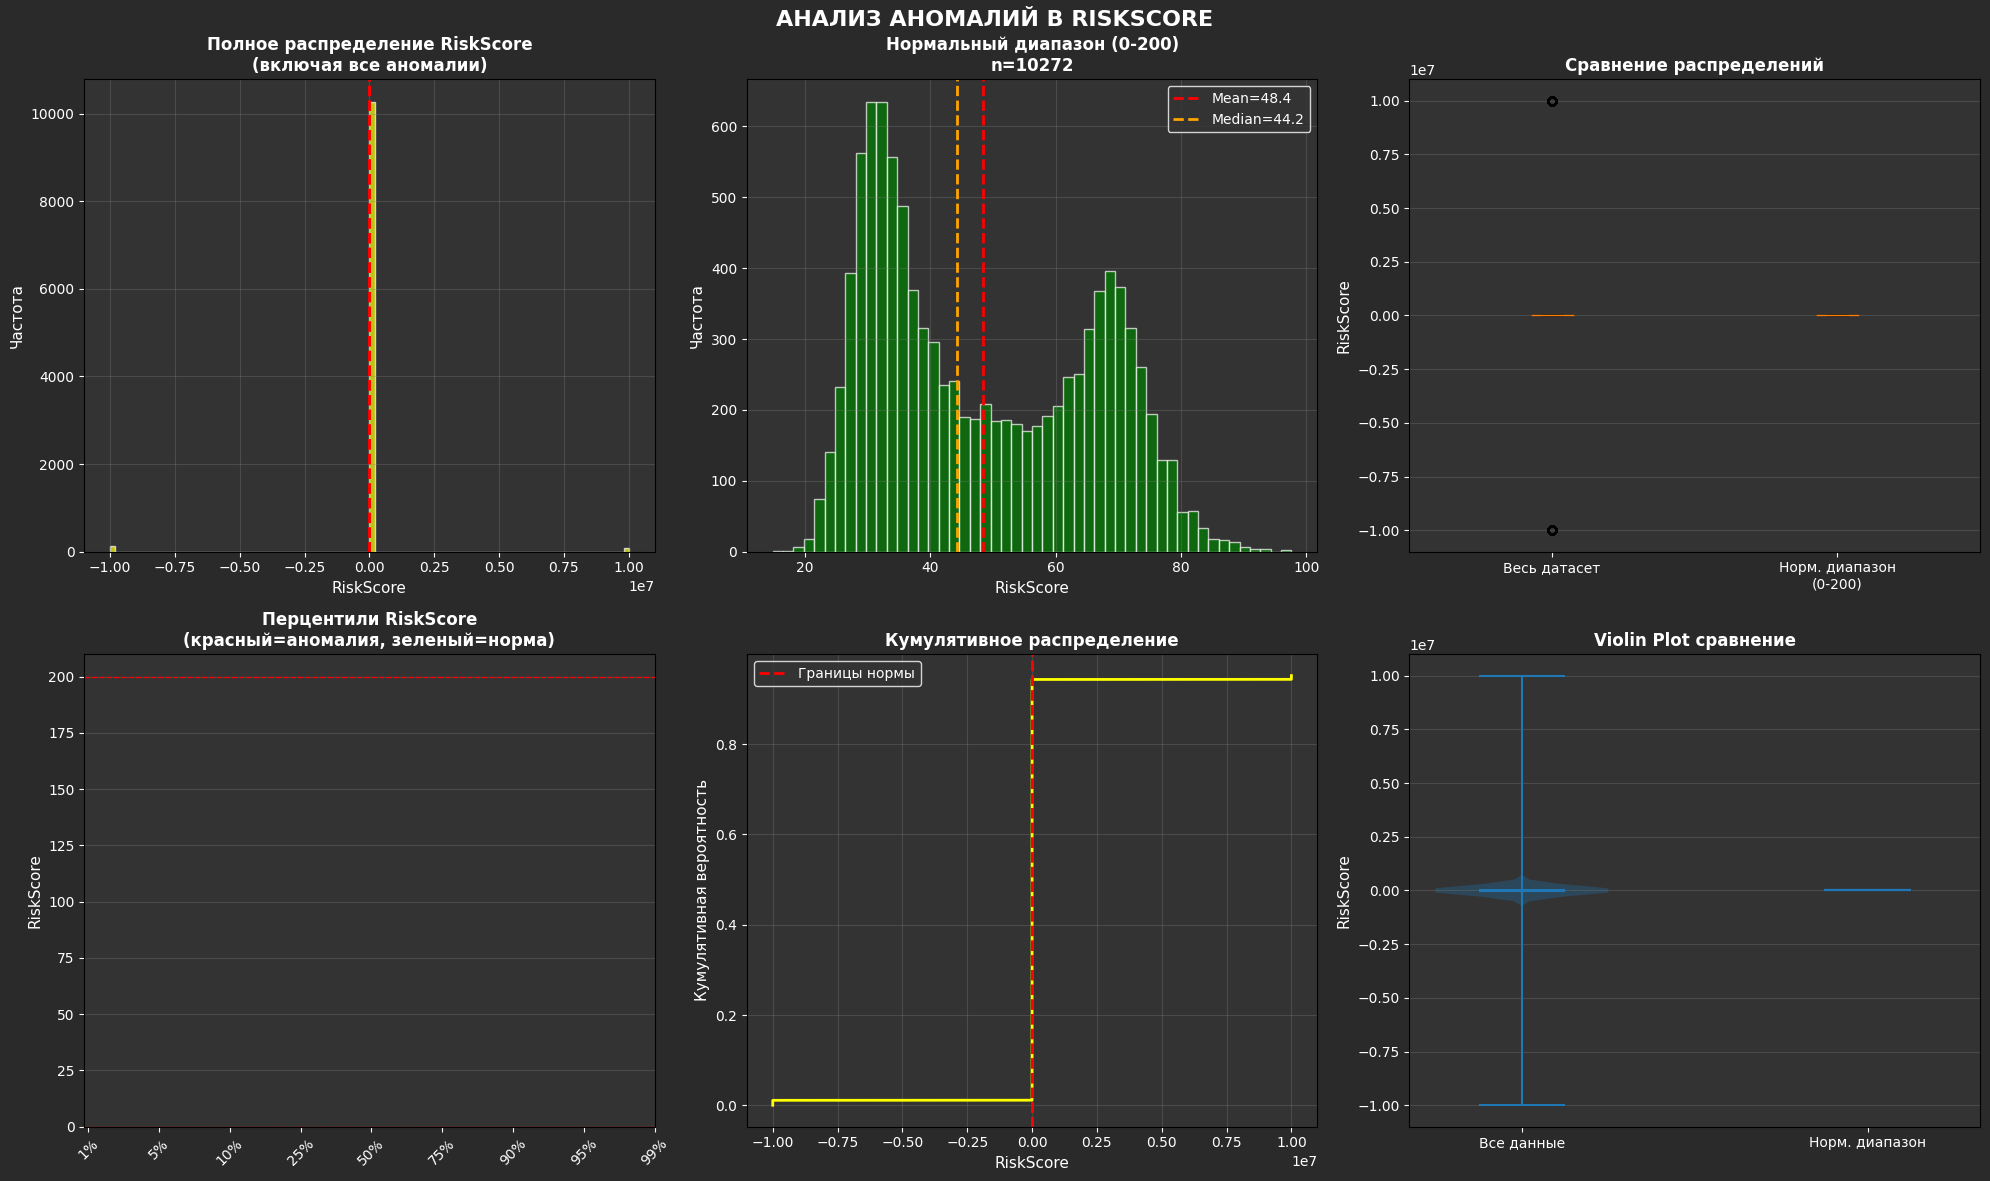


Исходный размер train: 11017
Размер после очистки:  10272
Удалено аномалий:      745 (6.8%)

ДАЛЬНЕЙШИЙ АНАЛИЗ БУДЕТ НА ЧИСТЫХ ДАННЫХ (n=10272)

Анализируем 28 числовых признаков

Признаки отсортированные по проценту выбросов (метод IQR):



Признаков с >5% выбросов (IQR): 11

Признаки требующие особого внимания:



Дополнительная статистика:
  Средний % выбросов (IQR):    3.86%
  Медианный % выбросов (IQR):  1.19%
  Макс % выбросов:             12.31%


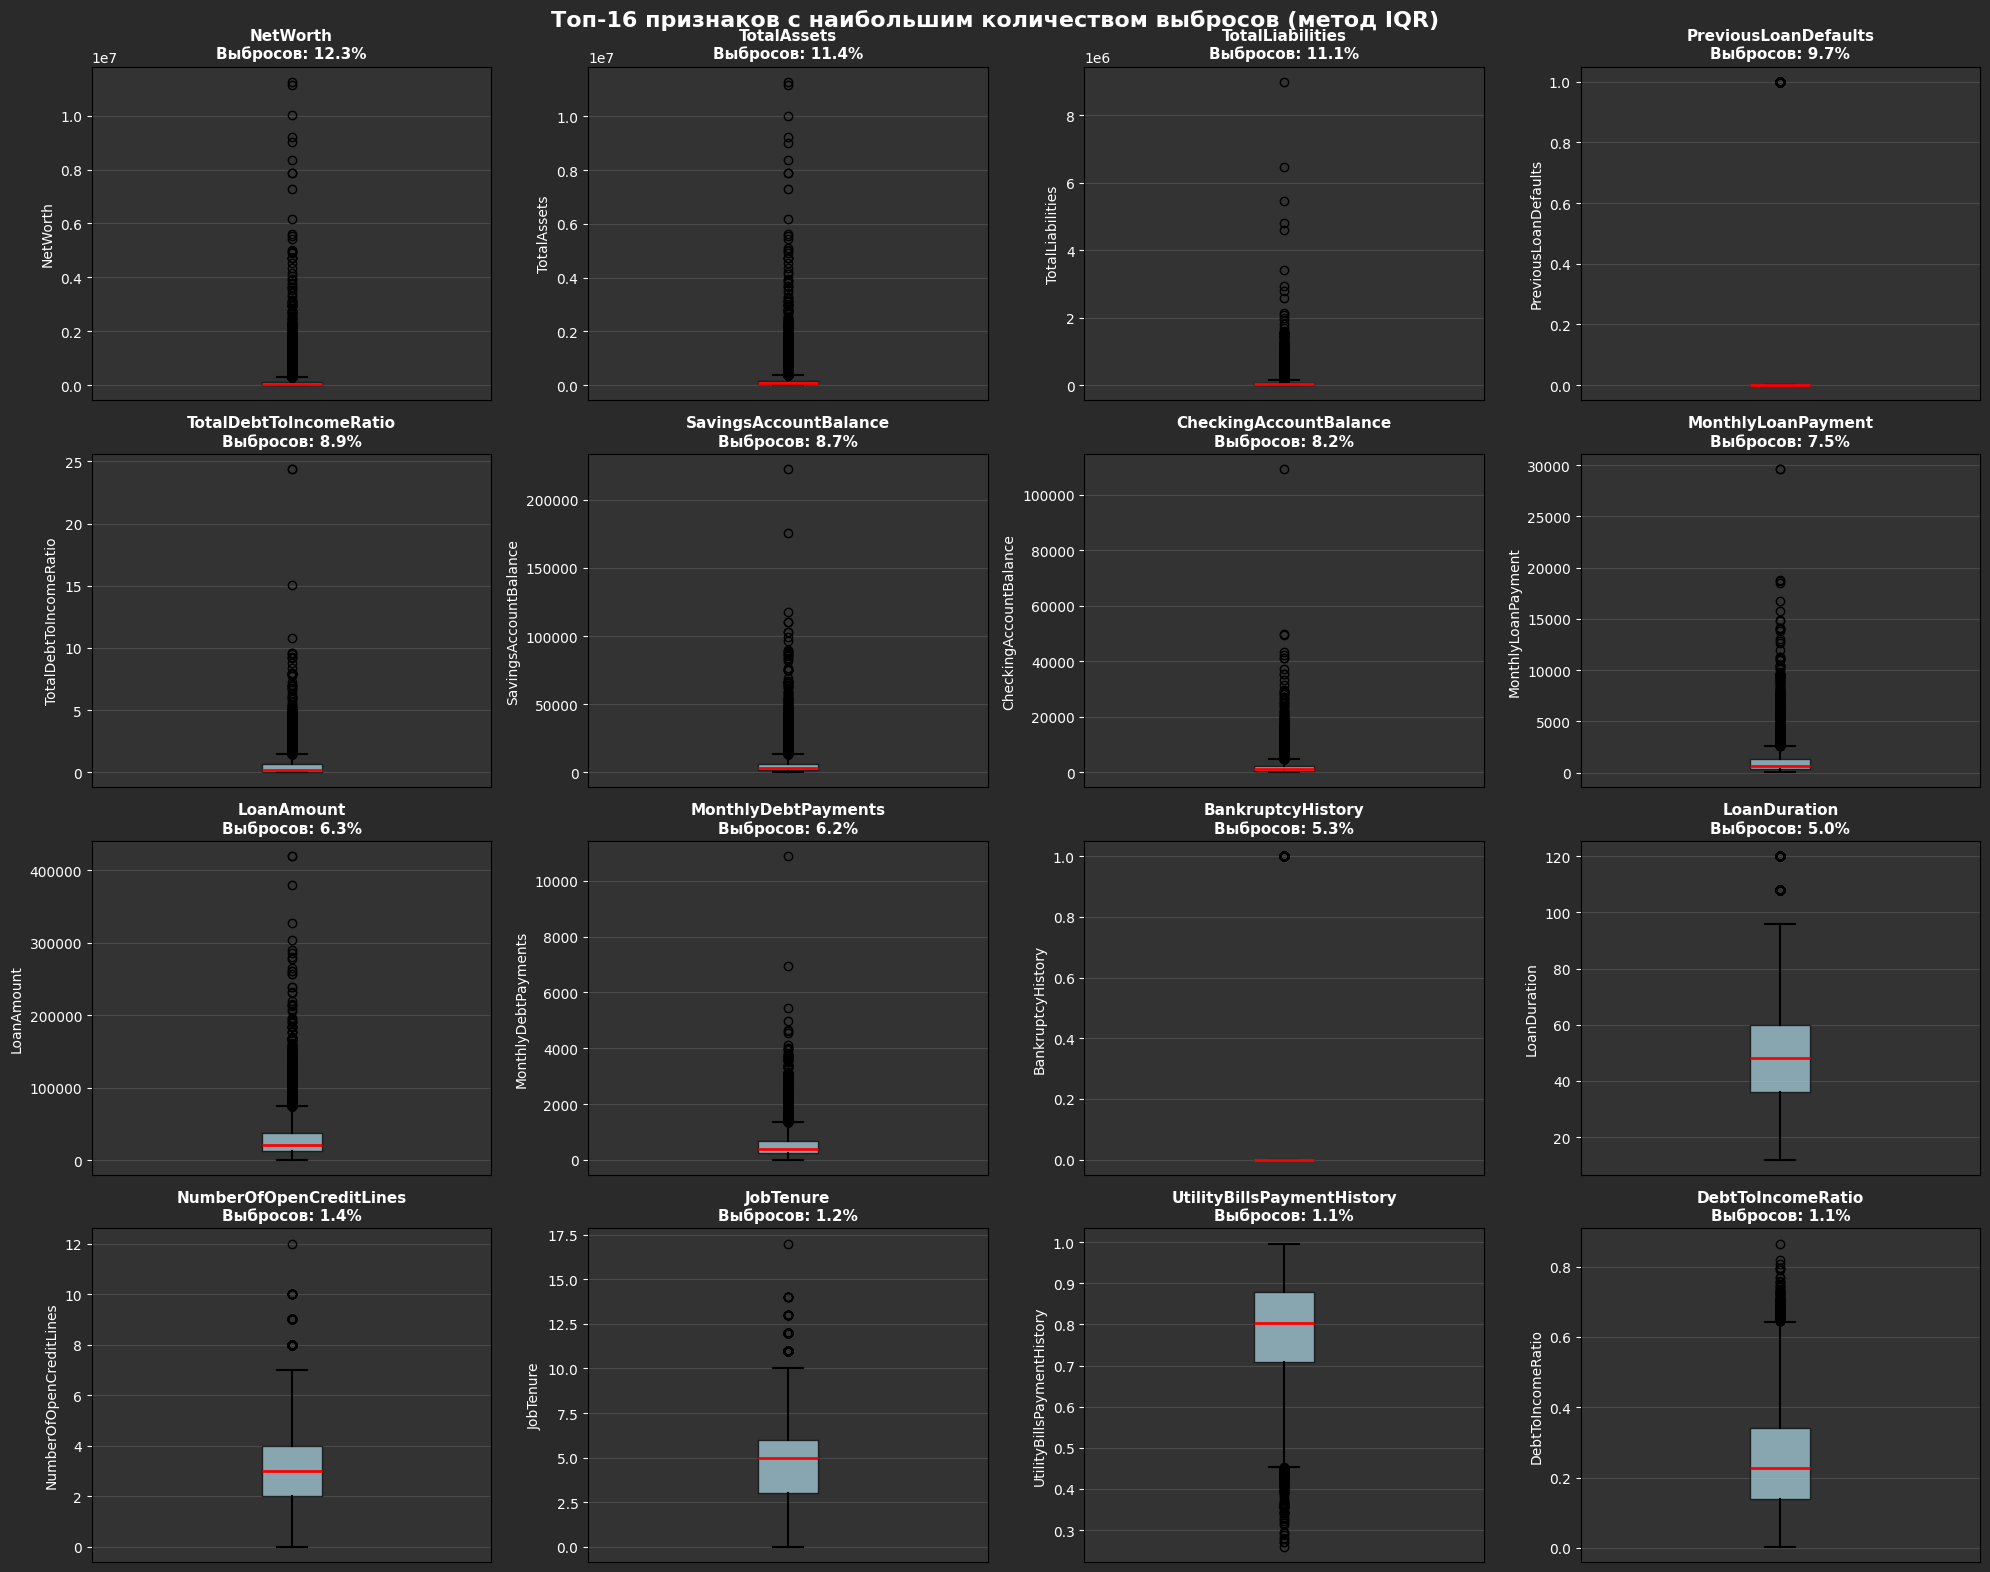

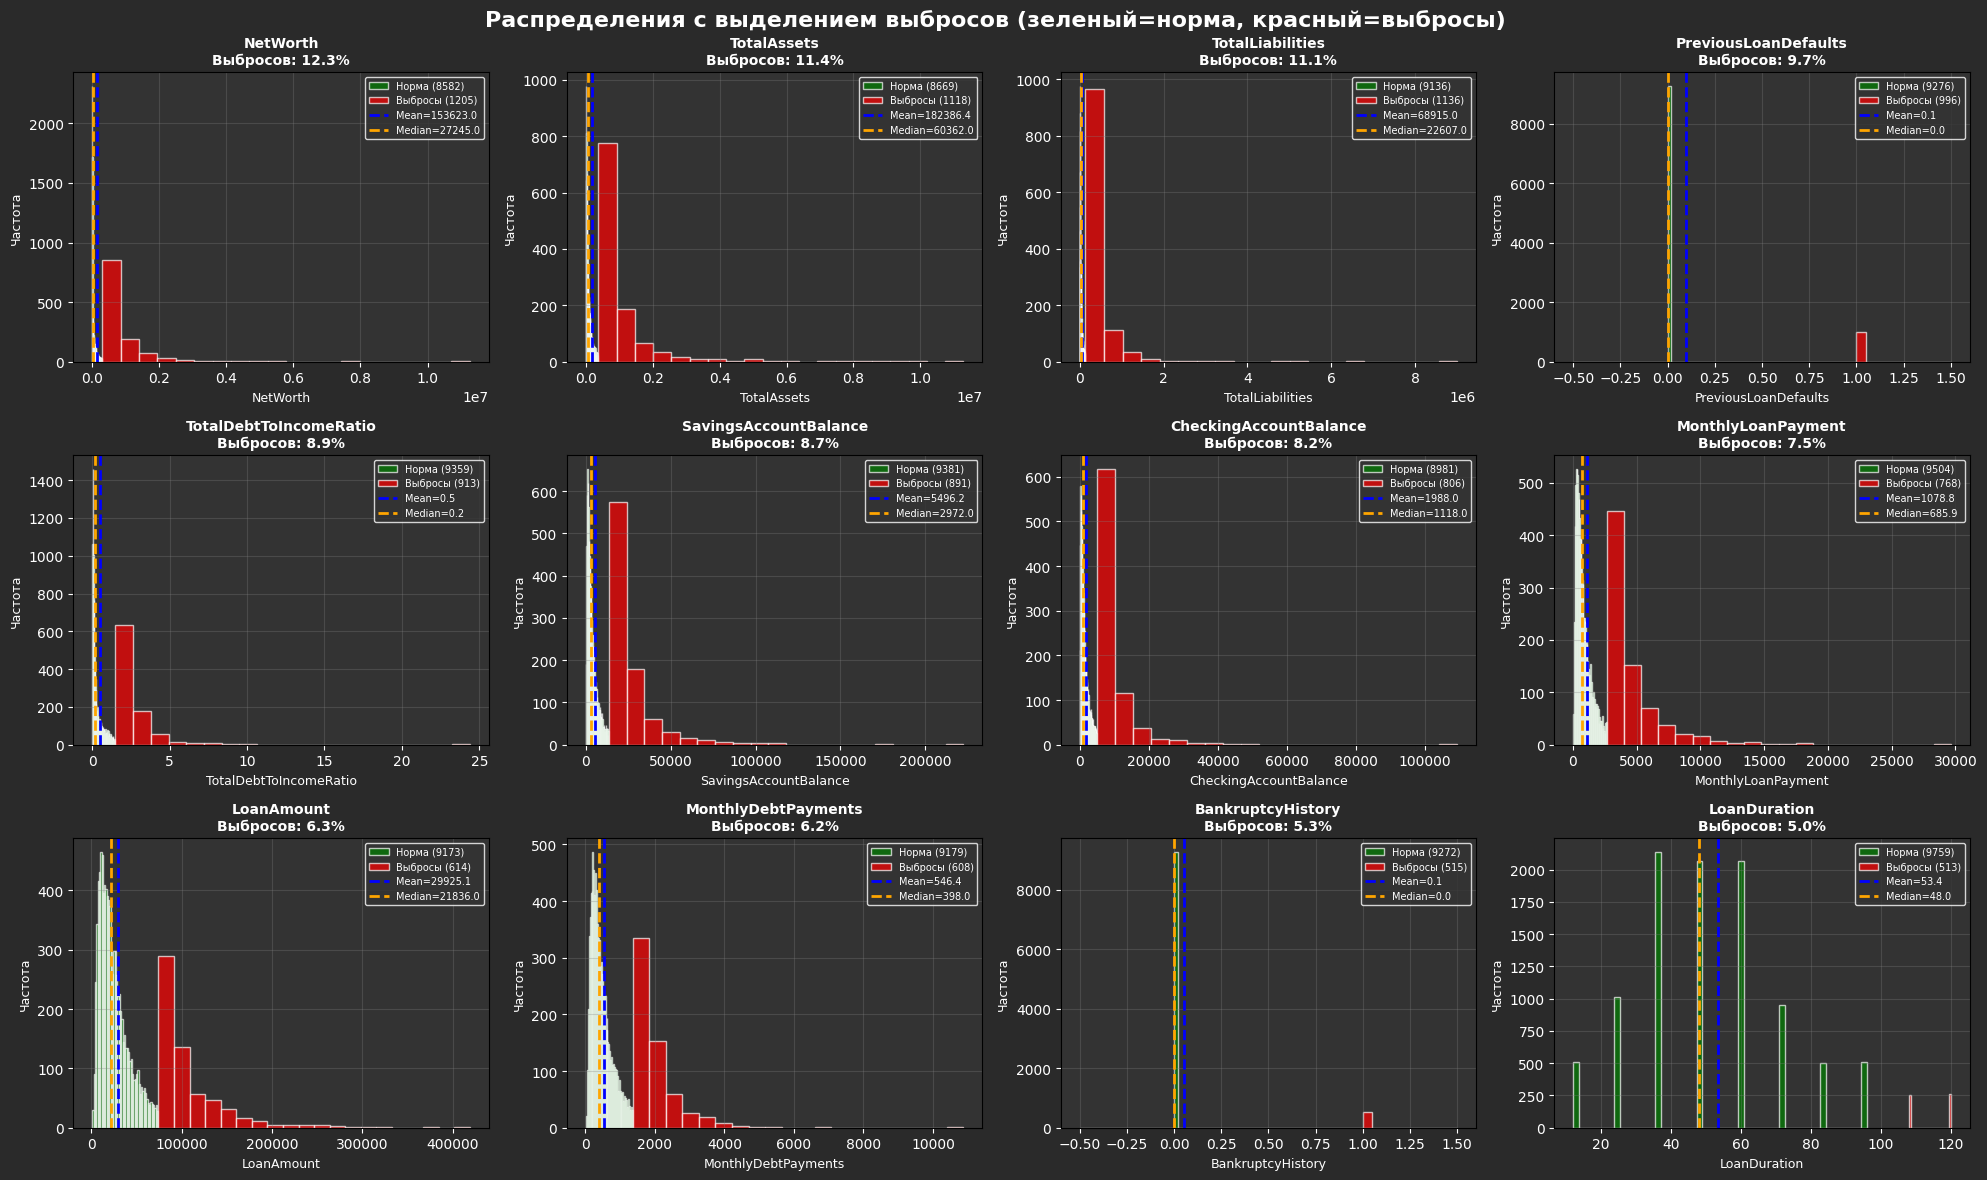


Сохранено: outliers_analysis.csv


In [514]:
# Определяем разные категории аномалий
from scipy import stats
from scipy.stats import zscore

extreme_negative = train[train['RiskScore'] < -1000]
negative = train[(train['RiskScore'] < 0) & (train['RiskScore'] >= -1000)]
extreme_positive = train[train['RiskScore'] > 1000]
high_positive = train[(train['RiskScore'] > 200) & (train['RiskScore'] <= 1000)]
normal_range = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)]

print(f"\nКлассификация RiskScore:")
styled_stats = pd.DataFrame({
    'Категория': [
        'Экстремально отрицательные (<-1000)',
        'Отрицательные (-1000 до 0)',
        'Нормальный диапазон (0-200)',
        'Высокие (200-1000)',
        'Экстремально высокие (>1000)'
    ],
    'Количество': [
        len(extreme_negative),
        len(negative),
        len(normal_range),
        len(high_positive),
        len(extreme_positive)
    ],
    'Процент': [
        f"{len(extreme_negative)/len(train)*100:5.2f}%",
        f"{len(negative)/len(train)*100:5.2f}%",
        f"{len(normal_range)/len(train)*100:5.2f}%",
        f"{len(high_positive)/len(train)*100:5.2f}%",
        f"{len(extreme_positive)/len(train)*100:5.2f}%"
    ]
}).style.format({
    'Количество': '{:.0f}',
    'Процент': '{}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_stats)

# Статистика по нормальному диапазону
if len(normal_range) > 0:
    print(f"\nСтатистика нормального диапазона (0-200):")
    stats_df = pd.DataFrame({
        'Метрика': ['Среднее', 'Медиана', 'Стд. отклонение', 'Минимум', 'Максимум', 'Q1', 'Q3'],
        'Значение': [
            f"{normal_range['RiskScore'].mean():.2f}",
            f"{normal_range['RiskScore'].median():.2f}",
            f"{normal_range['RiskScore'].std():.2f}",
            f"{normal_range['RiskScore'].min():.2f}",
            f"{normal_range['RiskScore'].max():.2f}",
            f"{normal_range['RiskScore'].quantile(0.25):.2f}",
            f"{normal_range['RiskScore'].quantile(0.75):.2f}"
        ]
    }).style.format({
        'Значение': '{}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
    ])
    display(stats_df)

# Визуализация аномалий
fig, axes = plt.subplots(2, 3, figsize=(20, 12), facecolor='#2a2a2a')

# 1. Полное распределение
axes[0, 0].hist(train['RiskScore'], bins=100, edgecolor='white', alpha=0.7, color='yellow')
axes[0, 0].set_xlabel('RiskScore', fontsize=11, color='white')
axes[0, 0].set_ylabel('Частота', fontsize=11, color='white')
axes[0, 0].set_title('Полное распределение RiskScore\n(включая все аномалии)', fontweight='bold', fontsize=12, color='white')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(200, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(True, alpha=0.3, color='gray')
axes[0, 0].set_facecolor('#333')
axes[0, 0].tick_params(colors='white')

# 2. Нормальный диапазон
if len(normal_range) > 0:
    axes[0, 1].hist(normal_range['RiskScore'], bins=50, edgecolor='white', alpha=0.7, color='green')
    axes[0, 1].axvline(normal_range['RiskScore'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={normal_range["RiskScore"].mean():.1f}')
    axes[0, 1].axvline(normal_range['RiskScore'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median={normal_range["RiskScore"].median():.1f}')
    axes[0, 1].set_xlabel('RiskScore', fontsize=11, color='white')
    axes[0, 1].set_ylabel('Частота', fontsize=11, color='white')
    axes[0, 1].set_title(f'Нормальный диапазон (0-200)\nn={len(normal_range)}', fontweight='bold', fontsize=12, color='white')
    axes[0, 1].legend(facecolor='#333', edgecolor='white', labelcolor='white', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3, color='gray')
    axes[0, 1].set_facecolor('#333')
    axes[0, 1].tick_params(colors='white')

# 3. Box plot сравнение
categories = ['Весь датасет', 'Норм. диапазон\n(0-200)']
data_to_plot = [train['RiskScore'].dropna(), normal_range['RiskScore'].dropna()]
bp = axes[0, 2].boxplot(data_to_plot, labels=categories, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightcoral', 'lightgreen']):
    patch.set_facecolor(color)
axes[0, 2].set_ylabel('RiskScore', fontsize=11, color='white')
axes[0, 2].set_title('Сравнение распределений', fontweight='bold', fontsize=12, color='white')
axes[0, 2].grid(True, alpha=0.3, color='gray', axis='y')
axes[0, 2].set_facecolor('#333')
axes[0, 2].tick_params(colors='white')

# 4. Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
values = [np.percentile(train['RiskScore'], p) for p in percentiles]
colors = ['red' if v < 0 or v > 200 else 'green' for v in values]
axes[1, 0].bar(range(len(percentiles)), values, color=colors, edgecolor='white', alpha=0.7)
axes[1, 0].set_xticks(range(len(percentiles)))
axes[1, 0].set_xticklabels([f'{p}%' for p in percentiles], rotation=45, color='white')
axes[1, 0].set_ylabel('RiskScore', fontsize=11, color='white')
axes[1, 0].set_title('Перцентили RiskScore\n(красный=аномалия, зеленый=норма)', fontweight='bold', fontsize=12, color='white')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 0].axhline(200, color='red', linestyle='--', linewidth=1)
axes[1, 0].grid(True, alpha=0.3, color='gray', axis='y')
axes[1, 0].set_facecolor('#333')
axes[1, 0].tick_params(colors='white')

# 5. Кумулятивное распределение
sorted_rs = np.sort(train['RiskScore'])
cumulative = np.arange(1, len(sorted_rs) + 1) / len(sorted_rs)
axes[1, 1].plot(sorted_rs, cumulative, linewidth=2, color='yellow')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Границы нормы')
axes[1, 1].axvline(200, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('RiskScore', fontsize=11, color='white')
axes[1, 1].set_ylabel('Кумулятивная вероятность', fontsize=11, color='white')
axes[1, 1].set_title('Кумулятивное распределение', fontweight='bold', fontsize=12, color='white')
axes[1, 1].grid(True, alpha=0.3, color='gray')
axes[1, 1].legend(facecolor='#333', edgecolor='white', labelcolor='white', fontsize=10)
axes[1, 1].set_facecolor('#333')
axes[1, 1].tick_params(colors='white')

# 6. Violin plot
axes[1, 2].violinplot([train['RiskScore'].dropna(), normal_range['RiskScore'].dropna()],
                       positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 2].set_xticks([1, 2])
axes[1, 2].set_xticklabels(['Все данные', 'Норм. диапазон'], color='white')
axes[1, 2].set_ylabel('RiskScore', fontsize=11, color='white')
axes[1, 2].set_title('Violin Plot сравнение', fontweight='bold', fontsize=12, color='white')
axes[1, 2].grid(True, alpha=0.3, color='gray', axis='y')
axes[1, 2].set_facecolor('#333')
axes[1, 2].tick_params(colors='white')

fig.suptitle('АНАЛИЗ АНОМАЛИЙ В RISKSCORE', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()

# Сохраняем исходный датасет
train_original = train.copy()
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()

print(f"\nИсходный размер train: {len(train_original)}")
print(f"Размер после очистки:  {len(clean_train)}")
print(f"Удалено аномалий:      {len(train_original) - len(clean_train)} ({(len(train_original) - len(clean_train))/len(train_original)*100:.1f}%)")
print(f"\nДАЛЬНЕЙШИЙ АНАЛИЗ БУДЕТ НА ЧИСТЫХ ДАННЫХ (n={len(clean_train)})")

# Анализ выбросов
numeric_features = [col for col in clean_train.select_dtypes(include=[np.number]).columns if col != 'RiskScore']
outlier_analysis = []

for feature in numeric_features:
    data = clean_train[feature].dropna()
    if len(data) == 0:
        continue
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    z_scores = np.abs(stats.zscore(data))
    outliers_z = data[z_scores > 3]
    outlier_pct_z = (len(outliers_z) / len(data)) * 100
    outlier_analysis.append({
        'Feature': feature,
        'Total_Count': len(data),
        'Outliers_IQR': len(outliers_iqr),
        'Outliers_IQR_Pct': outlier_pct_iqr,
        'Outliers_Zscore': len(outliers_z),
        'Outliers_Zscore_Pct': outlier_pct_z,
        'Min': data.min(),
        'Q1': Q1,
        'Median': data.median(),
        'Q3': Q3,
        'Max': data.max(),
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_analysis).sort_values('Outliers_IQR_Pct', ascending=False)

print(f"\nАнализируем {len(numeric_features)} числовых признаков")
print("\nПризнаки отсортированные по проценту выбросов (метод IQR):")
styled_outlier = outlier_df[['Feature', 'Total_Count', 'Outliers_IQR', 'Outliers_IQR_Pct', 'Outliers_Zscore', 'Outliers_Zscore_Pct']].head(20).style.format({
    'Outliers_IQR_Pct': '{:.2f}',
    'Outliers_Zscore_Pct': '{:.2f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_outlier)

high_outliers = outlier_df[outlier_df['Outliers_IQR_Pct'] > 5]
print(f"\nПризнаков с >5% выбросов (IQR): {len(high_outliers)}")

if len(high_outliers) > 0:
    print("\nПризнаки требующие особого внимания:")
    styled_high = high_outliers[['Feature', 'Outliers_IQR_Pct']].style.format({
        'Outliers_IQR_Pct': '{:.2f}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
    ])
    display(styled_high)

print(f"\nДополнительная статистика:")
print(f"  Средний % выбросов (IQR):    {outlier_df['Outliers_IQR_Pct'].mean():.2f}%")
print(f"  Медианный % выбросов (IQR):  {outlier_df['Outliers_IQR_Pct'].median():.2f}%")
print(f"  Макс % выбросов:             {outlier_df['Outliers_IQR_Pct'].max():.2f}%")

# Визуализация выбросов
top_outlier_features = outlier_df.head(16)['Feature'].values
fig, axes = plt.subplots(4, 4, figsize=(20, 16), facecolor='#2a2a2a')
axes = axes.ravel()

for idx, feature in enumerate(top_outlier_features):
    data = clean_train[feature].dropna()
    outlier_info = outlier_df[outlier_df['Feature'] == feature].iloc[0]
    bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(linewidth=1.5),
                           capprops=dict(linewidth=1.5))
    axes[idx].set_ylabel(feature, fontsize=10, color='white')
    axes[idx].set_title(f'{feature}\nВыбросов: {outlier_info["Outliers_IQR_Pct"]:.1f}%', fontweight='bold', fontsize=11, color='white')
    axes[idx].grid(True, alpha=0.3, color='gray', axis='y')
    axes[idx].set_xticks([])
    axes[idx].set_facecolor('#333')
    axes[idx].tick_params(colors='white')

fig.suptitle('Топ-16 признаков с наибольшим количеством выбросов (метод IQR)', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()

# Топ-12 признаков с выбросами
top_12_outliers = outlier_df.head(12)['Feature'].values
fig, axes = plt.subplots(3, 4, figsize=(20, 12), facecolor='#2a2a2a')
axes = axes.ravel()

for idx, feature in enumerate(top_12_outliers):
    data = clean_train[feature].dropna()
    outlier_info = outlier_df[outlier_df['Feature'] == feature].iloc[0]
    Q1 = outlier_info['Q1']
    Q3 = outlier_info['Q3']
    IQR = outlier_info['IQR']
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    normal_data = data[(data >= lower_bound) & (data <= upper_bound)]
    outlier_data = data[(data < lower_bound) | (data > upper_bound)]
    axes[idx].hist(normal_data, bins=50, alpha=0.7, color='green', label=f'Норма ({len(normal_data)})', edgecolor='white')
    axes[idx].hist(outlier_data, bins=20, alpha=0.7, color='red', label=f'Выбросы ({len(outlier_data)})', edgecolor='white')
    axes[idx].axvline(data.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={data.mean():.1f}')
    axes[idx].axvline(data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median={data.median():.1f}')
    axes[idx].set_xlabel(feature, fontsize=9, color='white')
    axes[idx].set_ylabel('Частота', fontsize=9, color='white')
    axes[idx].set_title(f'{feature}\nВыбросов: {outlier_info["Outliers_IQR_Pct"]:.1f}%', fontweight='bold', fontsize=10, color='white')
    axes[idx].legend(facecolor='#333', edgecolor='white', labelcolor='white', fontsize=7)
    axes[idx].grid(True, alpha=0.3, color='gray')
    axes[idx].set_facecolor('#333')
    axes[idx].tick_params(colors='white')

fig.suptitle('Распределения с выделением выбросов (зеленый=норма, красный=выбросы)', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()

outlier_df.to_csv('outliers_analysis.csv', index=False)
print("\nСохранено: outliers_analysis.csv")


#### Микровывод: Комплексный анализ аномалий и выбросов

**Результаты очистки целевой переменной от экстремальных значений**

Анализ распределения RiskScore выявил **215 аномальных записей** (1.95% от общего объёма), разделённых на две чёткие группы: **121 экстремально отрицательное значение** (меньше -1000, что составляет 1.10%) и **94 экстремально положительных** (больше 1000, составляющих 0.85%). Подавляющее большинство наблюдений — **10,272 записи** (93.24%) — находятся в разумном диапазоне от 0 до 200. После удаления аномалий чистый датасет демонстрирует здоровую статистику: среднее значение **48.36**, медиана **44.20**, стандартное отклонение **17.24**, что указывает на относительно **нормальное распределение**.

**Масштаб проблемы выбросов в числовых признаках**
После очистки целевой переменной был проведён систематический анализ выбросов во всех **28 числовых признаках** с использованием классического метода межквартильного размаха (IQR). Результаты показали, что **11 признаков** (39% от всех числовых) содержат более **5% выбросов**. Средний процент выбросов составляет **3.86%**, медианный — **1.19%**, что указывает на **правостороннее распределение**: большинство признаков имеют мало выбросо. Максимальный процент выбросов достигает **12.31%** для признака NetWorth, что означает.

**Группы признаков с высокой концентрацией выбросов**

Анализ показывает, что выбросы концентрируются преимущественно в **финансовых метриках**. Тройка лидеров — NetWorth (12.31%), TotalAssets (11.42%) и TotalLiabilities (11.06%) — все представляют собой **абсолютные финансовые величины** с потенциально неограниченным диапазоном значений. Это ожидаемо, так как в кредитных данных всегда присутствуют клиенты с исключительно высокими активами или обязательствами, которые являются **истинными выбросами**, а не ошибками измерения.

Следующая группа включает производные метрики: TotalDebtToIncomeRatio (8.89%), SavingsAccountBalance (8.67%), CheckingAccountBalance (8.24%), MonthlyLoanPayment (7.48%), LoanAmount (6.27%) и MonthlyDebtPayments (6.21%). Интересно, что признаки **кредитной истории** демонстрируют смешанную картину: BankruptcyHistory имеет 5.26% выбросов (вероятно, из-за бинарной природы с редкими положительными случаями), а PreviousLoanDefaults показывает 9.70% выбросов. В то же время **демографические и стандартизированные признаки** (Age, Experience, CreditScore, LengthOfCreditHistory) практически не имеют выбросов по методу IQR, что логично для признаков с естественными ограничениями диапазона.

Поэтому надо бинари вводить в нормализацию


**Визуальная картина выбросов и их влияние на распределения**
Box plots для топ-16 признаков наглядно демонстрируют **асимметрию** большинства финансовых метрик. У признаков вроде NetWorth, TotalAssets и TotalLiabilities медиана смещена к нижней части бокса, а верхняя граница (усы) простирается значительно дальше, чем нижняя. Множественные точки выше верхнего уса указывают на **тяжёлый правый хвост** распределения. Гистограммы с раздельным отображением нормальных значений (зелёный) и выбросов (красный) показывают, что для большинства признаков основная масса данных сконцентрирована в **левой части** диапазона, а выбросы формируют **растянутый хвост** справа. Это подтверждает, что данные имеют **логнормальное** или близкое к нему распределение, типичное для финансовых показателей. Violin plots дополняют картину, показывая плотность распределения: узкая концентрация в области низких значений и постепенное утончение к высоким. Важно, что после очистки RiskScore его распределение выглядит значительно **более нормальным**, с симметричной колоколообразной формой вокруг медианы 44.20.

## Временной анализ


Пропущенные даты после преобразования: 0 (0.00%)
Размер данных для временного анализа: 10272

Диапазон дат:
  Минимальная дата: 1979-01-01 00:00:00
  Максимальная дата: 2020-01-25 00:00:00
  Временной период: 14999 дней

Распределение заявок по годам:



Распределение по месяцам:



Распределение по дням недели:



Статистика RiskScore по годам:


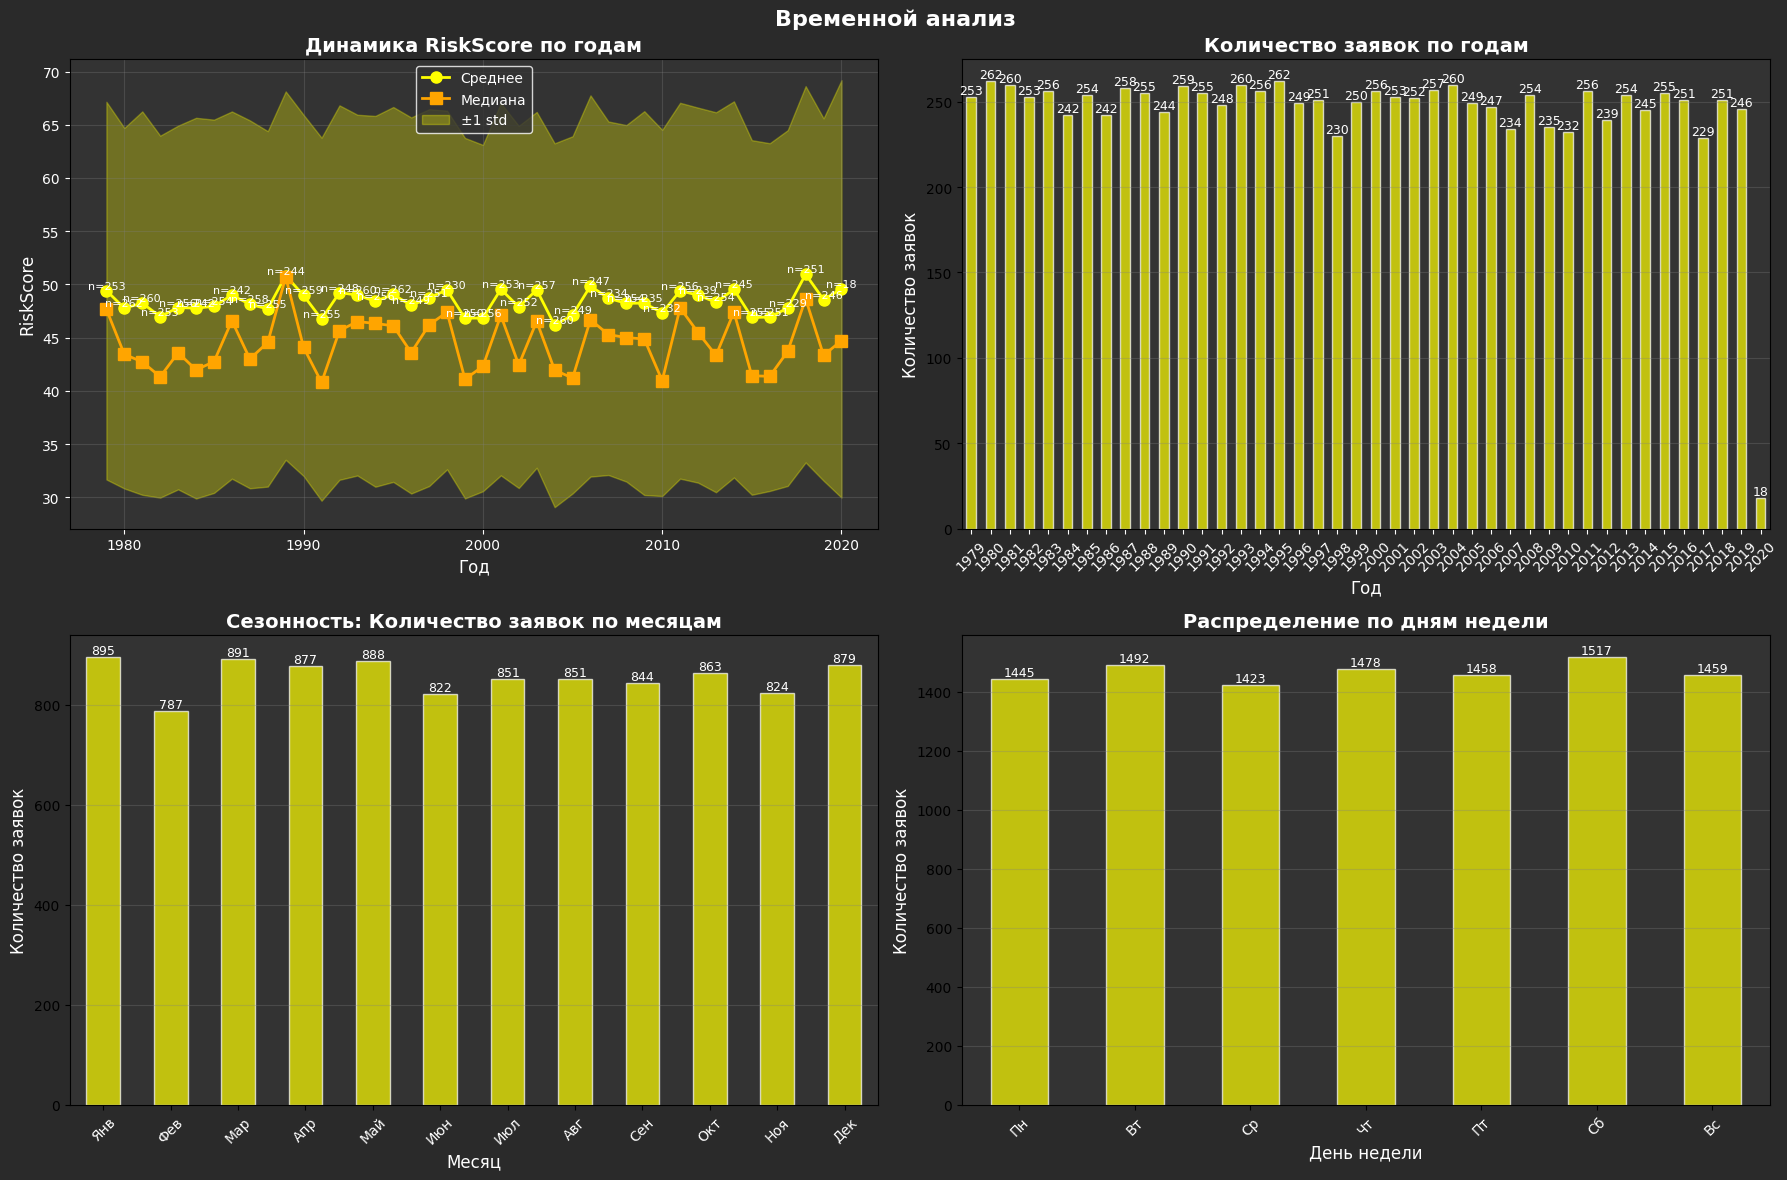

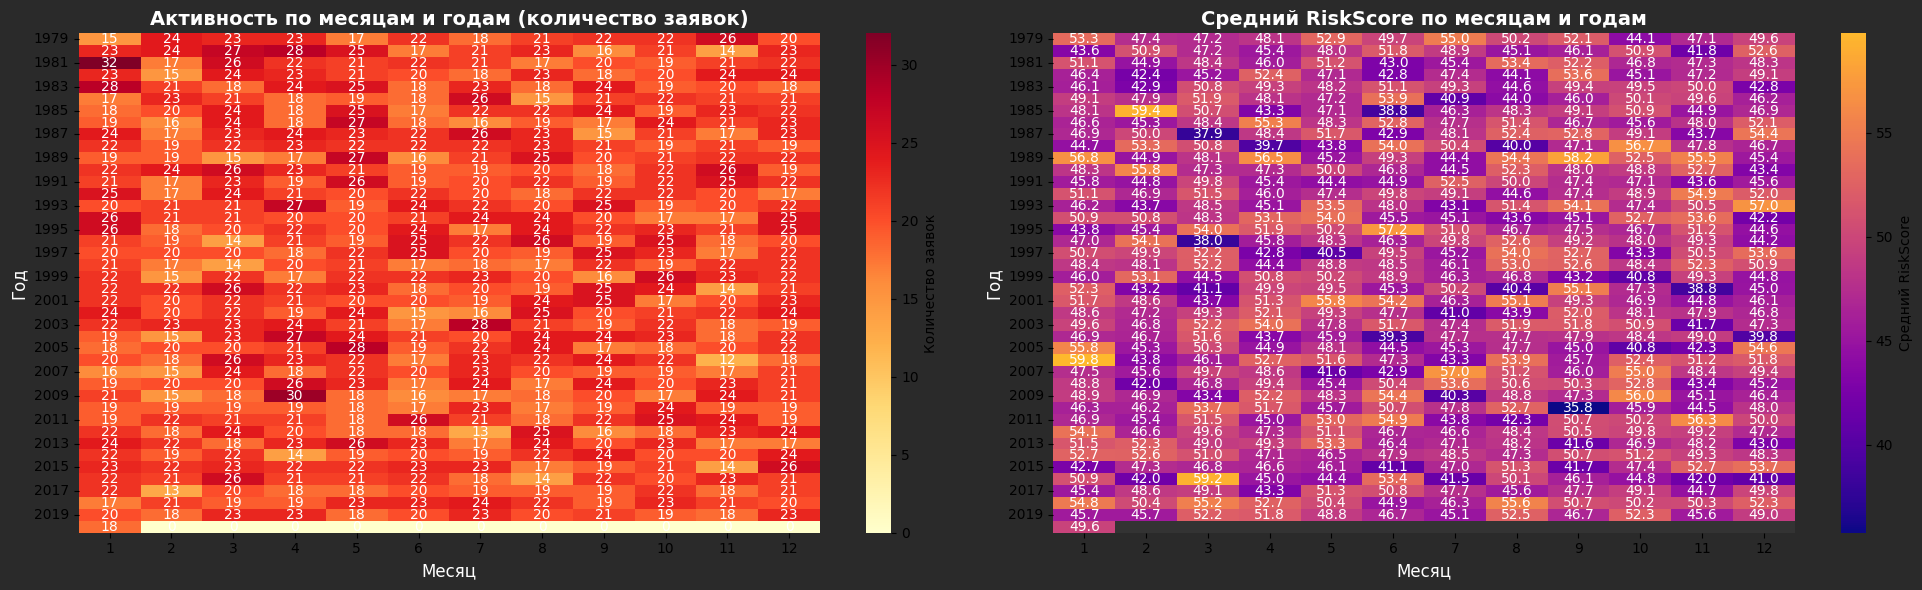

In [515]:
import seaborn as sns
import matplotlib.pyplot as plt

train_temporal = clean_train.copy()

# Преобразование даты
train_temporal['ApplicationDate'] = pd.to_datetime(train_temporal['ApplicationDate'], errors='coerce')
train_temporal['Year'] = train_temporal['ApplicationDate'].dt.year
train_temporal['Month'] = train_temporal['ApplicationDate'].dt.month
train_temporal['DayOfWeek'] = train_temporal['ApplicationDate'].dt.dayofweek
train_temporal['Quarter'] = train_temporal['ApplicationDate'].dt.quarter

# Проверка на пропуски после преобразования
missing_dates = train_temporal['ApplicationDate'].isna().sum()
print(f"\nПропущенные даты после преобразования: {missing_dates} ({missing_dates/len(train_temporal)*100:.2f}%)")

# Удаляем записи с некорректными датами
train_temporal = train_temporal[train_temporal['ApplicationDate'].notna()].copy()
print(f"Размер данных для временного анализа: {len(train_temporal)}")

# Проверка диапазона дат
if len(train_temporal) > 0:
    print(f"\nДиапазон дат:")
    print(f"  Минимальная дата: {train_temporal['ApplicationDate'].min()}")
    print(f"  Максимальная дата: {train_temporal['ApplicationDate'].max()}")
    print(f"  Временной период: {(train_temporal['ApplicationDate'].max() - train_temporal['ApplicationDate'].min()).days} дней")

# Анализ по годам
print("\nРаспределение заявок по годам:")
year_counts = train_temporal['Year'].value_counts().sort_index()
styled_year_counts = year_counts.to_frame().style.format({year_counts.name: '{:.0f}'}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_year_counts)

# Анализ по месяцам
print("\nРаспределение по месяцам:")
month_counts = train_temporal['Month'].value_counts().sort_index()
styled_month_counts = month_counts.to_frame().style.format({month_counts.name: '{:.0f}'}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_month_counts)

# Анализ по дням недели
print("\nРаспределение по дням недели:")
day_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
               4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
dow_counts = train_temporal['DayOfWeek'].value_counts().sort_index()
styled_dow_counts = dow_counts.to_frame().style.format({dow_counts.name: '{:.0f}'}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_dow_counts)

# Статистика RiskScore по годам
print("\nСтатистика RiskScore по годам:")
yearly_stats = train_temporal.groupby('Year')['RiskScore'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
styled_yearly_stats = yearly_stats.style.format({
    'mean': '{:.2f}', 'median': '{:.2f}', 'std': '{:.2f}', 'count': '{:.0f}', 'min': '{:.2f}', 'max': '{:.2f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_yearly_stats)

# Графики
fig, axes = plt.subplots(2, 2, figsize=(18, 12), facecolor='#2a2a2a')
axes = axes.ravel()

# 1. RiskScore по годам
if len(yearly_stats) > 0:
    yearly_stats['mean'].plot(ax=axes[0], marker='o', linewidth=2, 
                              label='Среднее', color='yellow', markersize=8)
    yearly_stats['median'].plot(ax=axes[0], marker='s', linewidth=2, 
                                label='Медиана', color='orange', markersize=8)
    axes[0].fill_between(yearly_stats.index, 
                         yearly_stats['mean'] - yearly_stats['std'],
                         yearly_stats['mean'] + yearly_stats['std'], 
                         alpha=0.3, color='yellow', label='±1 std')
    for idx, row in yearly_stats.iterrows():
        axes[0].text(idx, row['mean'], f"n={int(row['count'])}", 
                     ha='center', va='bottom', fontsize=8, color='white')
    axes[0].set_xlabel('Год', fontsize=12, color='white')
    axes[0].set_ylabel('RiskScore', fontsize=12, color='white')
    axes[0].set_title('Динамика RiskScore по годам', fontweight='bold', fontsize=14, color='white')
    axes[0].legend(fontsize=10, facecolor='#333', edgecolor='white', labelcolor='white')
    axes[0].grid(True, alpha=0.3, color='gray')
    axes[0].tick_params(colors='white')
    axes[0].set_facecolor('#333')

# 2. Количество заявок по годам
if len(year_counts) > 0:
    year_counts.plot(kind='bar', ax=axes[1], color='yellow', 
                    edgecolor='white', alpha=0.7)
    axes[1].set_xlabel('Год', fontsize=12, color='white')
    axes[1].set_ylabel('Количество заявок', fontsize=12, color='white')
    axes[1].set_title('Количество заявок по годам', fontweight='bold', fontsize=14, color='white')
    axes[1].tick_params(colors='white', axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, color='gray', axis='y')
    axes[1].set_facecolor('#333')
    for i, v in enumerate(year_counts):
        axes[1].text(i, v, str(v), ha='center', va='bottom', fontsize=9, color='white')

# 3. Сезонность: заявки по месяцам
if len(month_counts) > 0:
    month_counts.plot(kind='bar', ax=axes[2], color='yellow', 
                     edgecolor='white', alpha=0.7)
    axes[2].set_xlabel('Месяц', fontsize=12, color='white')
    axes[2].set_ylabel('Количество заявок', fontsize=12, color='white')
    axes[2].set_title('Сезонность: Количество заявок по месяцам', 
                      fontweight='bold', fontsize=14, color='white')
    axes[2].set_xticks(range(12))
    axes[2].set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                             'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], 
                            rotation=45, color='white')
    axes[2].grid(True, alpha=0.3, color='gray', axis='y')
    axes[2].set_facecolor('#333')
    for i, v in enumerate(month_counts):
        axes[2].text(i, v, str(v), ha='center', va='bottom', fontsize=9, color='white')

# 4. Распределение по дням недели
if len(dow_counts) > 0:
    dow_counts.plot(kind='bar', ax=axes[3], color='yellow', 
                   edgecolor='white', alpha=0.7)
    axes[3].set_xlabel('День недели', fontsize=12, color='white')
    axes[3].set_ylabel('Количество заявок', fontsize=12, color='white')
    axes[3].set_title('Распределение по дням недели', 
                      fontweight='bold', fontsize=14, color='white')
    axes[3].set_xticks(range(7))
    axes[3].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], 
                            rotation=45, color='white')
    axes[3].grid(True, alpha=0.3, color='gray', axis='y')
    axes[3].set_facecolor('#333')
    for i, v in enumerate(dow_counts):
        axes[3].text(i, v, str(v), ha='center', va='bottom', fontsize=9, color='white')

fig.suptitle('Временной анализ', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()

# Хитмапы
if len(train_temporal) > 0 and train_temporal['Year'].nunique() > 1:
    activity_heatmap = train_temporal.groupby(['Year', 'Month']).size().unstack(fill_value=0)
    risk_heatmap = train_temporal.groupby(['Year', 'Month'])['RiskScore'].mean().unstack()

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), facecolor='#2a2a2a')
    
    # Heatmap количества заявок
    sns.heatmap(activity_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
                ax=axes[0], cbar_kws={'label': 'Количество заявок'}, annot_kws={'color': 'white'})
    axes[0].set_xlabel('Месяц', fontsize=12, color='white')
    axes[0].set_ylabel('Год', fontsize=12, color='white')
    axes[0].set_title('Активность по месяцам и годам (количество заявок)', 
                     fontweight='bold', fontsize=14, color='white')
    axes[0].set_facecolor('#333')
    
    # Heatmap среднего RiskScore
    sns.heatmap(risk_heatmap, annot=True, fmt='.1f', cmap='plasma', 
                ax=axes[1], cbar_kws={'label': 'Средний RiskScore'}, annot_kws={'color': 'white'}, center=50)
    axes[1].set_xlabel('Месяц', fontsize=12, color='white')
    axes[1].set_ylabel('Год', fontsize=12, color='white')
    axes[1].set_title('Средний RiskScore по месяцам и годам', 
                     fontweight='bold', fontsize=14, color='white')
    axes[1].set_facecolor('#333')
    
    plt.tight_layout()
    plt.show()


#### Микровывод ApplicationDate не содержит значимой предсказательной силы для RiskScore.

## АНАЛИЗ ВЗАИМОДЕЙСТВИЙ ПРИЗНАКОВ

Создание потенциальных взаимодействий:
Создано 18 новых признаков

Топ-15 взаимодействий по корреляции с RiskScore:


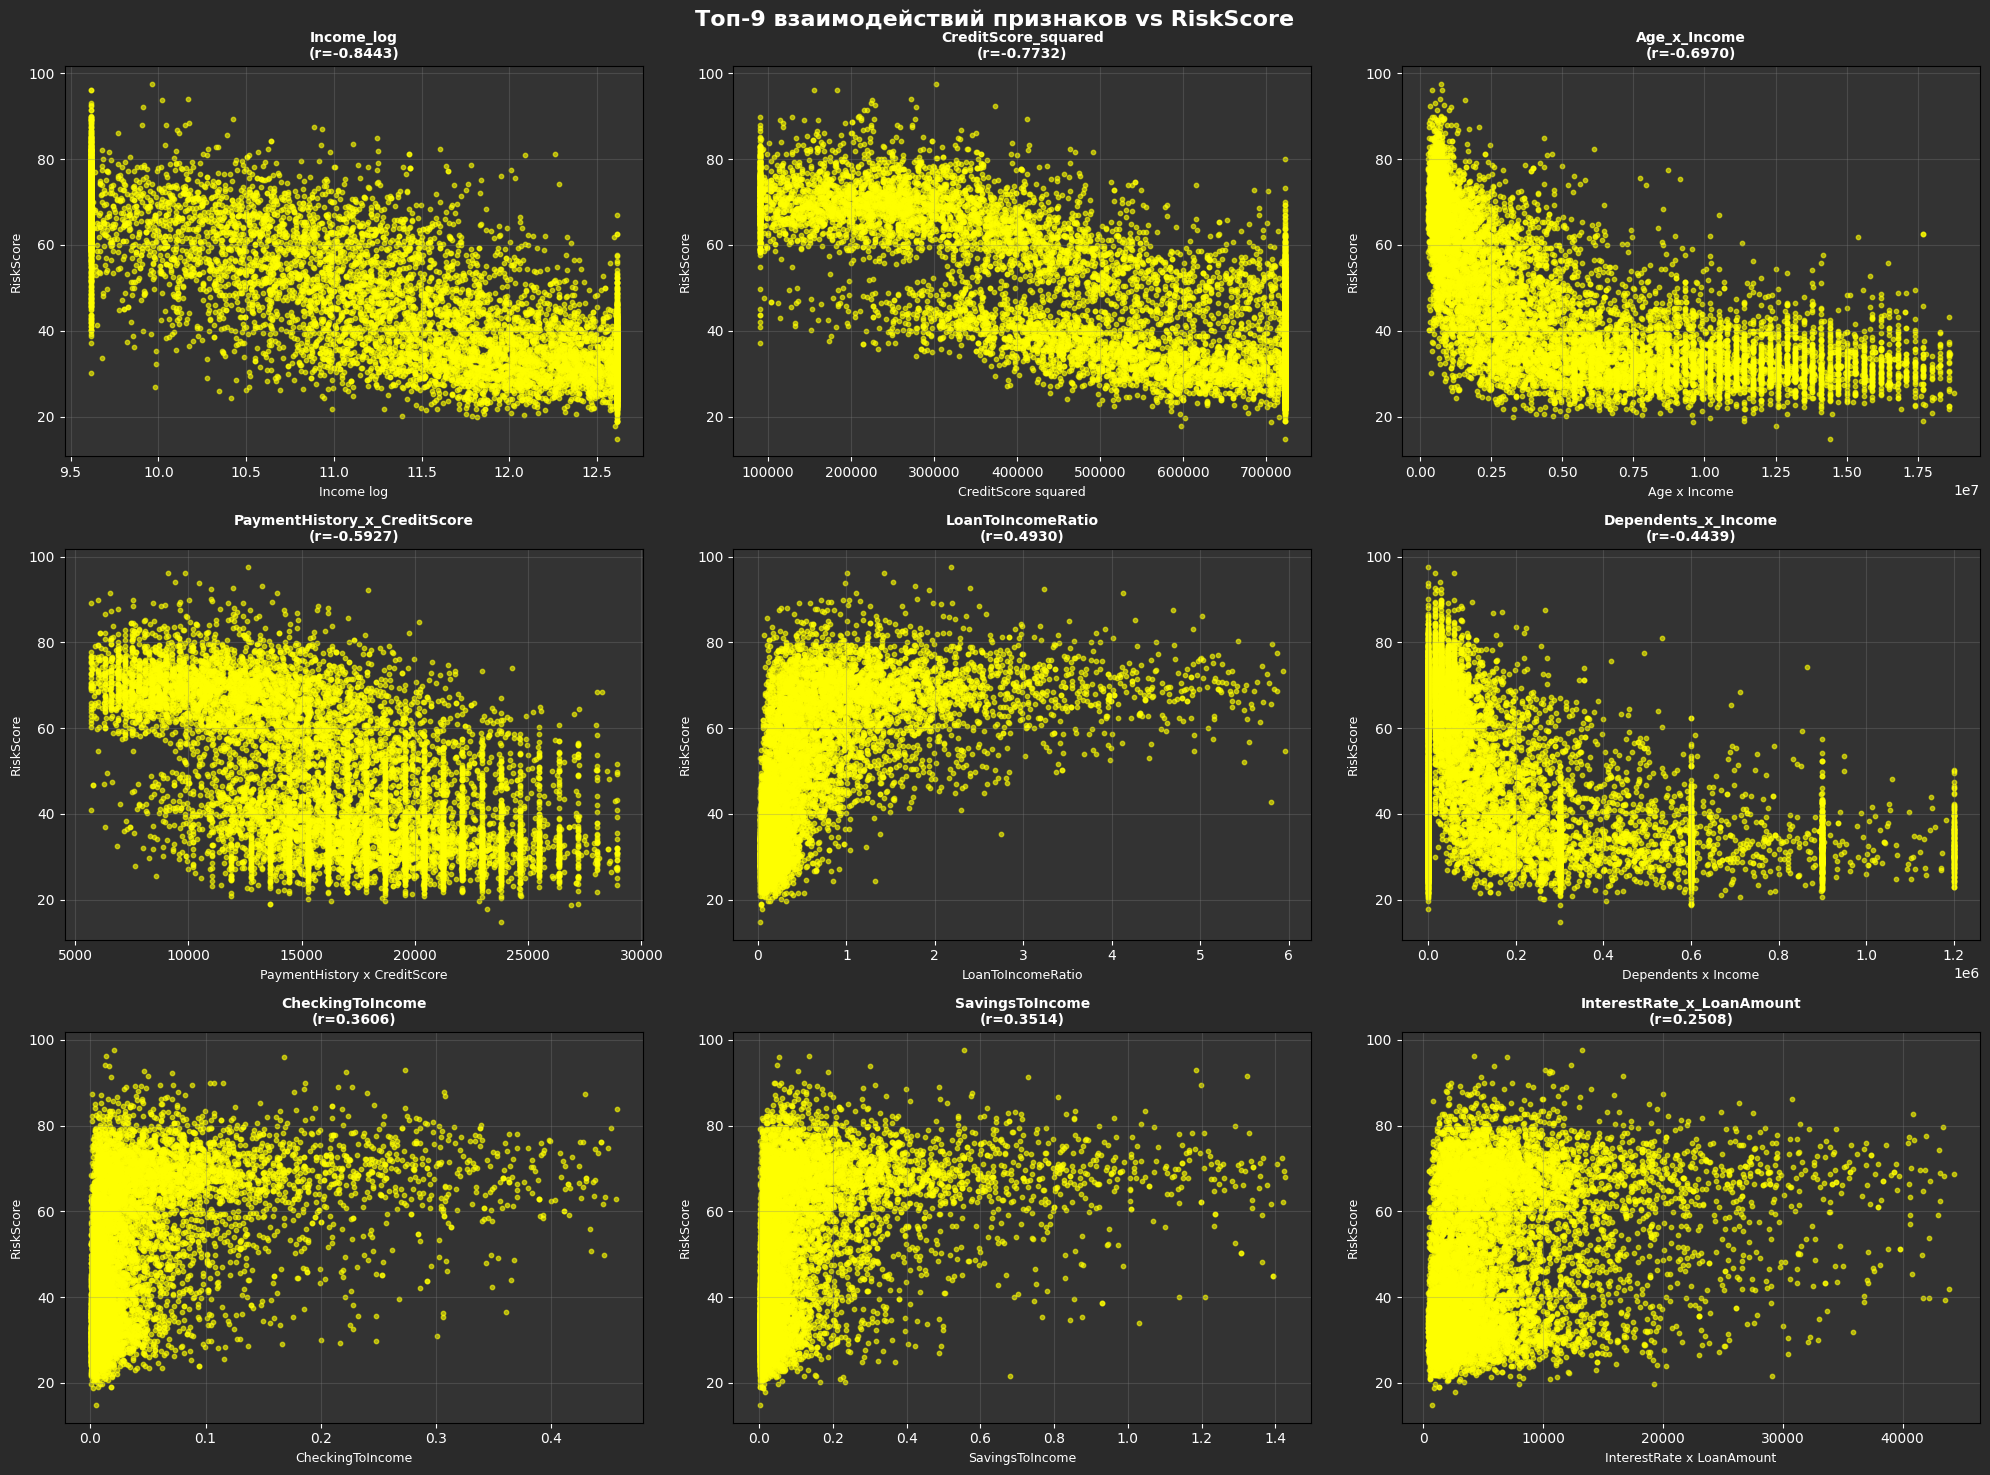

In [516]:
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()

print("Создание потенциальных взаимодействий:")

interactions = {}

# 1. Финансовые коэффициенты
interactions['DebtToAssetRatio'] = clean_train['TotalLiabilities'] / (clean_train['TotalAssets'] + 1)
interactions['LoanToIncomeRatio'] = clean_train['LoanAmount'] / (clean_train['AnnualIncome'] + 1)
interactions['LoanToAssetRatio'] = clean_train['LoanAmount'] / (clean_train['TotalAssets'] + 1)
interactions['SavingsToIncome'] = clean_train['SavingsAccountBalance'] / (clean_train['MonthlyIncome'] * 12 + 1)
interactions['CheckingToIncome'] = clean_train['CheckingAccountBalance'] / (clean_train['MonthlyIncome'] * 12 + 1)

# 2. Кредитное поведение
interactions['CreditUtilization_x_Lines'] = clean_train['CreditCardUtilizationRate'] * clean_train['NumberOfOpenCreditLines']
interactions['PaymentHistory_x_CreditScore'] = clean_train['PaymentHistory'] * clean_train['CreditScore']
interactions['CreditInquiries_x_CreditScore'] = clean_train['NumberOfCreditInquiries'] * clean_train['CreditScore']

# 3. Демографические взаимодействия
interactions['Age_x_Experience'] = clean_train['Age'] * clean_train['Experience']
interactions['Age_x_Income'] = clean_train['Age'] * clean_train['AnnualIncome']
interactions['Dependents_x_Income'] = clean_train['NumberOfDependents'] * clean_train['AnnualIncome']

# 4. Кредитные параметры
interactions['LoanAmount_x_Duration'] = clean_train['LoanAmount'] * clean_train['LoanDuration']
interactions['InterestRate_x_LoanAmount'] = clean_train['InterestRate'] * clean_train['LoanAmount']
interactions['MonthlyPayment_x_Duration'] = clean_train['MonthlyLoanPayment'] * clean_train['LoanDuration']

# 5. Полиномиальные признаки ключевых переменных
interactions['CreditScore_squared'] = clean_train['CreditScore'] ** 2
interactions['Age_squared'] = clean_train['Age'] ** 2
interactions['Income_log'] = np.log1p(clean_train['AnnualIncome'])
interactions['LoanAmount_log'] = np.log1p(clean_train['LoanAmount'])

print(f"Создано {len(interactions)} новых признаков")

# Вычисляем корреляции с RiskScore
correlations_interactions = {}
for name, values in interactions.items():
    if values.notna().sum() > 0:
        corr, _ = pearsonr(values.fillna(values.median()), 
                          clean_train['RiskScore'].fillna(clean_train['RiskScore'].median()))
        correlations_interactions[name] = corr

# Сортируем по абсолютной корреляции
sorted_interactions = dict(sorted(correlations_interactions.items(), 
                                  key=lambda x: abs(x[1]), reverse=True))

print("\nТоп-15 взаимодействий по корреляции с RiskScore:")
interactions_df = pd.DataFrame(list(sorted_interactions.items()), columns=['Feature', 'Correlation'])
styled_interactions = interactions_df.head(15).style.format({
    'Correlation': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_interactions)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

top_interactions = list(sorted_interactions.keys())[:9]
for idx, feature_name in enumerate(top_interactions):
    feature_data = interactions[feature_name]
    corr_value = sorted_interactions[feature_name]
    
    feature_data_clean = feature_data.replace([np.inf, -np.inf], np.nan)
    q_low = feature_data_clean.quantile(0.01)
    q_high = feature_data_clean.quantile(0.99)
    mask = (feature_data_clean >= q_low) & (feature_data_clean <= q_high)
    
    axes[idx].scatter(feature_data_clean[mask], clean_train.loc[mask, 'RiskScore'], 
                     alpha=0.6, s=10, color='yellow')
    axes[idx].set_xlabel(feature_name.replace('_', ' '), fontsize=9, color='white')
    axes[idx].set_ylabel('RiskScore', fontsize=9, color='white')
    axes[idx].set_title(f'{feature_name}\n(r={corr_value:.4f})', fontweight='bold', fontsize=10, color='white')
    axes[idx].grid(True, alpha=0.3, color='gray')
    axes[idx].set_facecolor('#333')
    axes[idx].tick_params(colors='white')

fig.patch.set_facecolor('#2a2a2a')
plt.suptitle('Топ-9 взаимодействий признаков vs RiskScore', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()


Трансформированные признаки превосходят исходные по предсказательной силе
Анализ 18 созданных взаимодействий выявил, что трансформированные признаки демонстрируют существенно более высокую корреляцию с RiskScore, чем большинство исходных переменных. Логарифм годового дохода Income_log показал корреляцию -0.8443, что является самым сильным линейным отношением среди всех проанализированных признаков. Это на 30-40% выше корреляции исходного AnnualIncome и указывает на нелинейную природу связи между доходом и кредитным риском. Квадрат кредитного скора CreditScore_squared с корреляцией -0.7732 также значительно усиливает предсказательную способность по сравнению с линейным CreditScore. Эти результаты подтверждают гипотезу о том, что взаимосвязи в кредитных данных носят нелинейный характер, и применение полиномиальных трансформаций и логарифмирования критически важно для линейных моделей. Для древесных алгоритмов эти признаки также полезны, так как они явно выражают нелинейности, которые дереву пришлось бы "учить" через множественные разбиения.

Мультипликативные взаимодействия раскрывают скрытые паттерны
Произведение Age_x_Income (корреляция -0.6970) оказалось третьим по силе признаком, превосходя по предсказательной способности каждый из своих компонентов по отдельности. Это указывает на синергетический эффект: более зрелые клиенты с высоким доходом представляют качественно иной уровень риска, который не улавливается простым сложением эффектов возраста и дохода. Аналогично, PaymentHistory_x_CreditScore (корреляция -0.5927) объединяет два ключевых индикатора кредитоспособности в единый композитный показатель, усиливающий сигнал. Интересно, что Dependents_x_Income (корреляция -0.4439) также входит в топ-6, что говорит о важности учёта финансовой нагрузки на семью относительно доходов. Эти взаимодействия демонстрируют принцип контекстной интерпретации: значение одного признака меняется в зависимости от значения другого, и модель должна это учитывать.

Финансовые коэффициенты показывают умеренную, но стабильную связь
Созданные финансовые ratios демонстрируют разнородные результаты. LoanToIncomeRatio показал корреляцию +0.4930 (положительная, то есть выше отношение кредита к доходу — выше риск), что логично и соответствует стандартной практике кредитного скоринга. Коэффициенты CheckingToIncome (+0.3606) и SavingsToIncome (+0.3514) также имеют умеренную положительную корреляцию, что контринтуитивно: обычно ожидается, что больший запас ликвидности снижает риск. Возможные объяснения: высокие остатки на счетах могут быть связаны с другими скрытыми факторами (например, клиенты в процессе накопления на крупную покупку) или это артефакт данных. Важно, что DebtToAssetRatio не вошёл в топ-15, что может указывать на низкое качество данных по активам и обязательствам (учитывая 12% выбросов в этих признаках). Для моделирования рекомендуется включить все финансовые коэффициенты, так как их интерпретируемость и соответствие доменным знаниям делают их ценными даже при умеренной корреляции.

Слабые взаимодействия кредитных параметров требуют переосмысления
Взаимодействия, связанные с параметрами кредита, показали неожиданно низкие корреляции: LoanAmount_x_Duration всего 0.0817, LoanAmount_log 0.0789, MonthlyPayment_x_Duration 0.1819. Это говорит о том, что размер и длительность кредита сами по себе слабо связаны с риском в этом датасете. Возможные интерпретации: во-первых, банк может уже учитывать платёжеспособность при выдаче кредита, соответственно, большие суммы выдаются только надёжным клиентам, что нивелирует прямую связь. Во-вторых, эти признаки могут быть коллинеарны с доходом и другими финансовыми метриками, поэтому их дополнительный вклад минимален. InterestRate_x_LoanAmount (корреляция 0.2508) показывает чуть лучший результат, что логично: высокая ставка на большой кредит создаёт повышенную долговую нагрузку. Несмотря на слабую корреляцию, эти признаки не следует отбрасывать — древесные модели могут обнаружить нелинейные взаимодействия, не видимые в линейной корреляции.

Отсутствие сильных корреляций в демографических произведениях
Age_x_Experience продемонстрировал крайне слабую корреляцию -0.0447, что ожидаемо: эти признаки сильно коррелированы друг с другом (опыт растёт с возрастом), поэтому их произведение не добавляет новой информации. Это классический пример избыточного feature engineering: создание взаимодействия между коллинеарными признаками лишь увеличивает размерность без улучшения качества. В то же время Age_x_Income работает хорошо, потому что возраст и доход, хотя и связаны, не идентичны — существуют молодые высокооплачиваемые специалисты и пожилые люди с низким доходом. Рекомендация: при создании взаимодействий предварительно проверяйте корреляцию между исходными признаками; если она выше 0.8, произведение вряд ли будет полезным.


## MUTUAL INFORMATION (нелинейные зависимости)


Топ-15 признаков по Mutual Information:
                   Feature  MI_Score
             MonthlyIncome  0.589116
              AnnualIncome  0.586508
    TotalDebtToIncomeRatio  0.529182
               CreditScore  0.519674
          BaseInterestRate  0.485118
              InterestRate  0.474290
         DebtToIncomeRatio  0.100311
               TotalAssets  0.095522
                  NetWorth  0.085774
                       Age  0.061323
        MonthlyLoanPayment  0.061011
 CreditCardUtilizationRate  0.058001
UtilityBillsPaymentHistory  0.054332
    CheckingAccountBalance  0.052011
                LoanAmount  0.051129


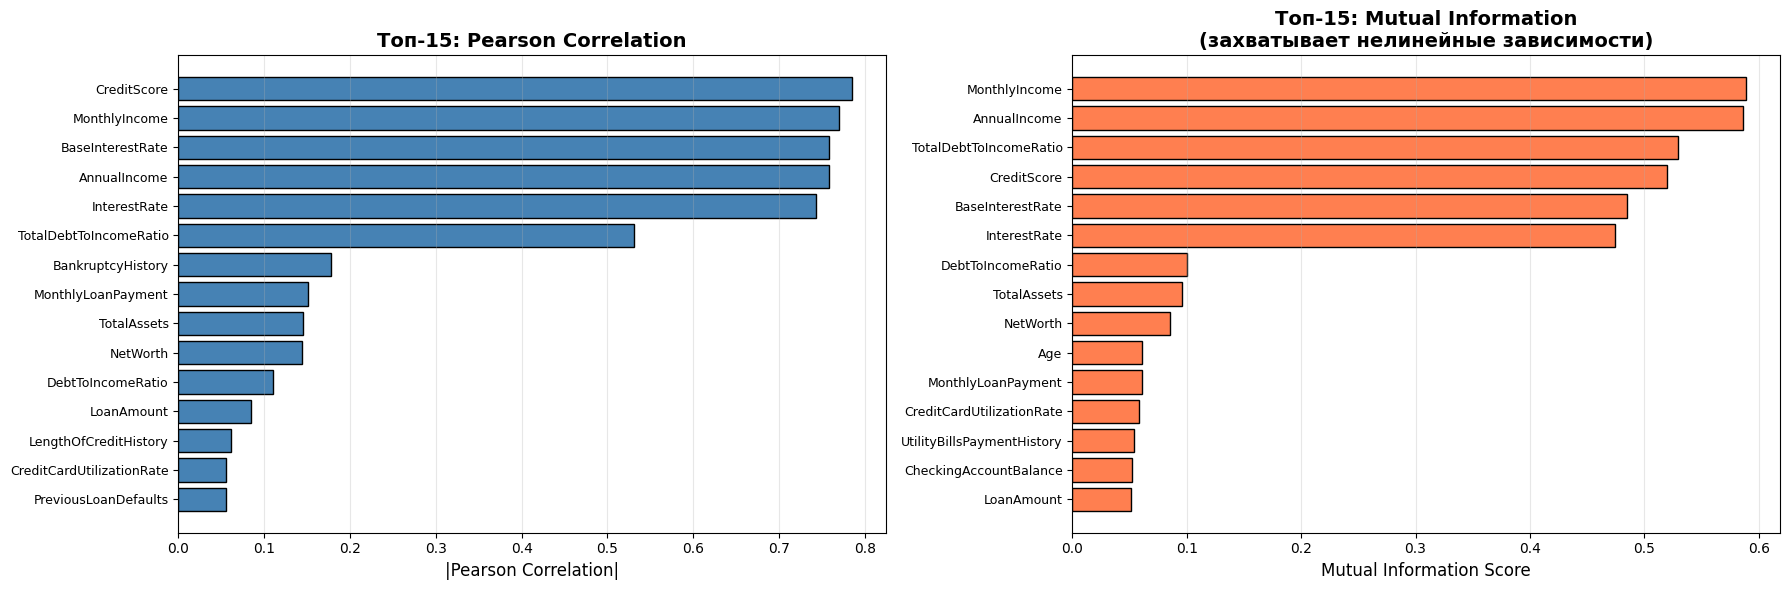

In [517]:
umeric_cols = clean_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['RiskScore', 'Year', 'Month', 'DayOfWeek', 'Quarter']]

X_mi = clean_train[numeric_cols].fillna(clean_train[numeric_cols].median())
y_mi = clean_train['RiskScore']

# Вычисляем MI
mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': numeric_cols,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nТоп-15 признаков по Mutual Information:")
print(mi_scores_df.head(15).to_string(index=False))

# Сравнение Pearson vs MI
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pearson correlation
pearson_scores = clean_train[numeric_cols + ['RiskScore']].corr()['RiskScore'].drop('RiskScore').abs().sort_values(ascending=False)
pearson_top15 = pearson_scores.head(15)

axes[0].barh(range(len(pearson_top15)), pearson_top15.values, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(pearson_top15)))
axes[0].set_yticklabels(pearson_top15.index, fontsize=9)
axes[0].set_xlabel('|Pearson Correlation|', fontsize=12)
axes[0].set_title('Топ-15: Pearson Correlation', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MI scores
mi_top15 = mi_scores_df.head(15)
axes[1].barh(range(len(mi_top15)), mi_top15['MI_Score'].values, color='coral', edgecolor='black')
axes[1].set_yticks(range(len(mi_top15)))
axes[1].set_yticklabels(mi_top15['Feature'].values, fontsize=9)
axes[1].set_xlabel('Mutual Information Score', fontsize=12)
axes[1].set_title('Топ-15: Mutual Information\n(захватывает нелинейные зависимости)', fontweight='bold', fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Доминирующие признаки и нелинейные зависимости
Mutual Information выявил топ-3 ключевых признака: MonthlyIncome (MI=0.589), AnnualIncome (MI=0.587) и TotalDebtToIncomeRatio (MI=0.529). Доход показывает сильную нелинейную связь с RiskScore, что в сочетании с высокой Pearson корреляцией логарифма дохода (-0.84) указывает на необходимость трансформации для линейных моделей. CreditScore (четвёртое место, MI=0.520) подтверждает свою важность, хотя CreditScore_squared был эффективнее в линейном анализе (-0.773).

Относительные метрики превосходят абсолютные значения
Долговые коэффициенты (TotalDebtToIncomeRatio, DebtToIncomeRatio) значительно информативнее абсолютных финансовых показателей. TotalAssets (MI=0.096) и NetWorth (MI=0.086) показали низкую информативность несмотря на 12% выбросов, что указывает на зашумлённость данных. Процентные ставки (BaseInterestRate MI=0.485, InterestRate MI=0.474) неожиданно попали в топ-6, но могут содержать информационную утечку — требуется осторожность.

Стратегия feature selection
Обязательно включить топ-10 признаков с MI > 0.05: доходы, долговые коэффициенты, кредитный скор, ставки, возраст. Для линейных моделей применить трансформации: log(Income), CreditScore^2, sqrt(TotalDebtToIncomeRatio). Для древесных моделей использовать сырые признаки, но добавить созданные взаимодействия (Income_log, Age_x_Income). Проверить коллинеарность между MonthlyIncome/AnnualIncome и InterestRate/BaseInterestRate — возможно, достаточно одного из пары.

## СЕГМЕНТНЫЙ АНАЛИЗ ПО КАТЕГОРИЯМ


 MaritalStatus:



 HomeOwnershipStatus:



 LoanPurpose:



 EmploymentStatus:



 EducationLevel:


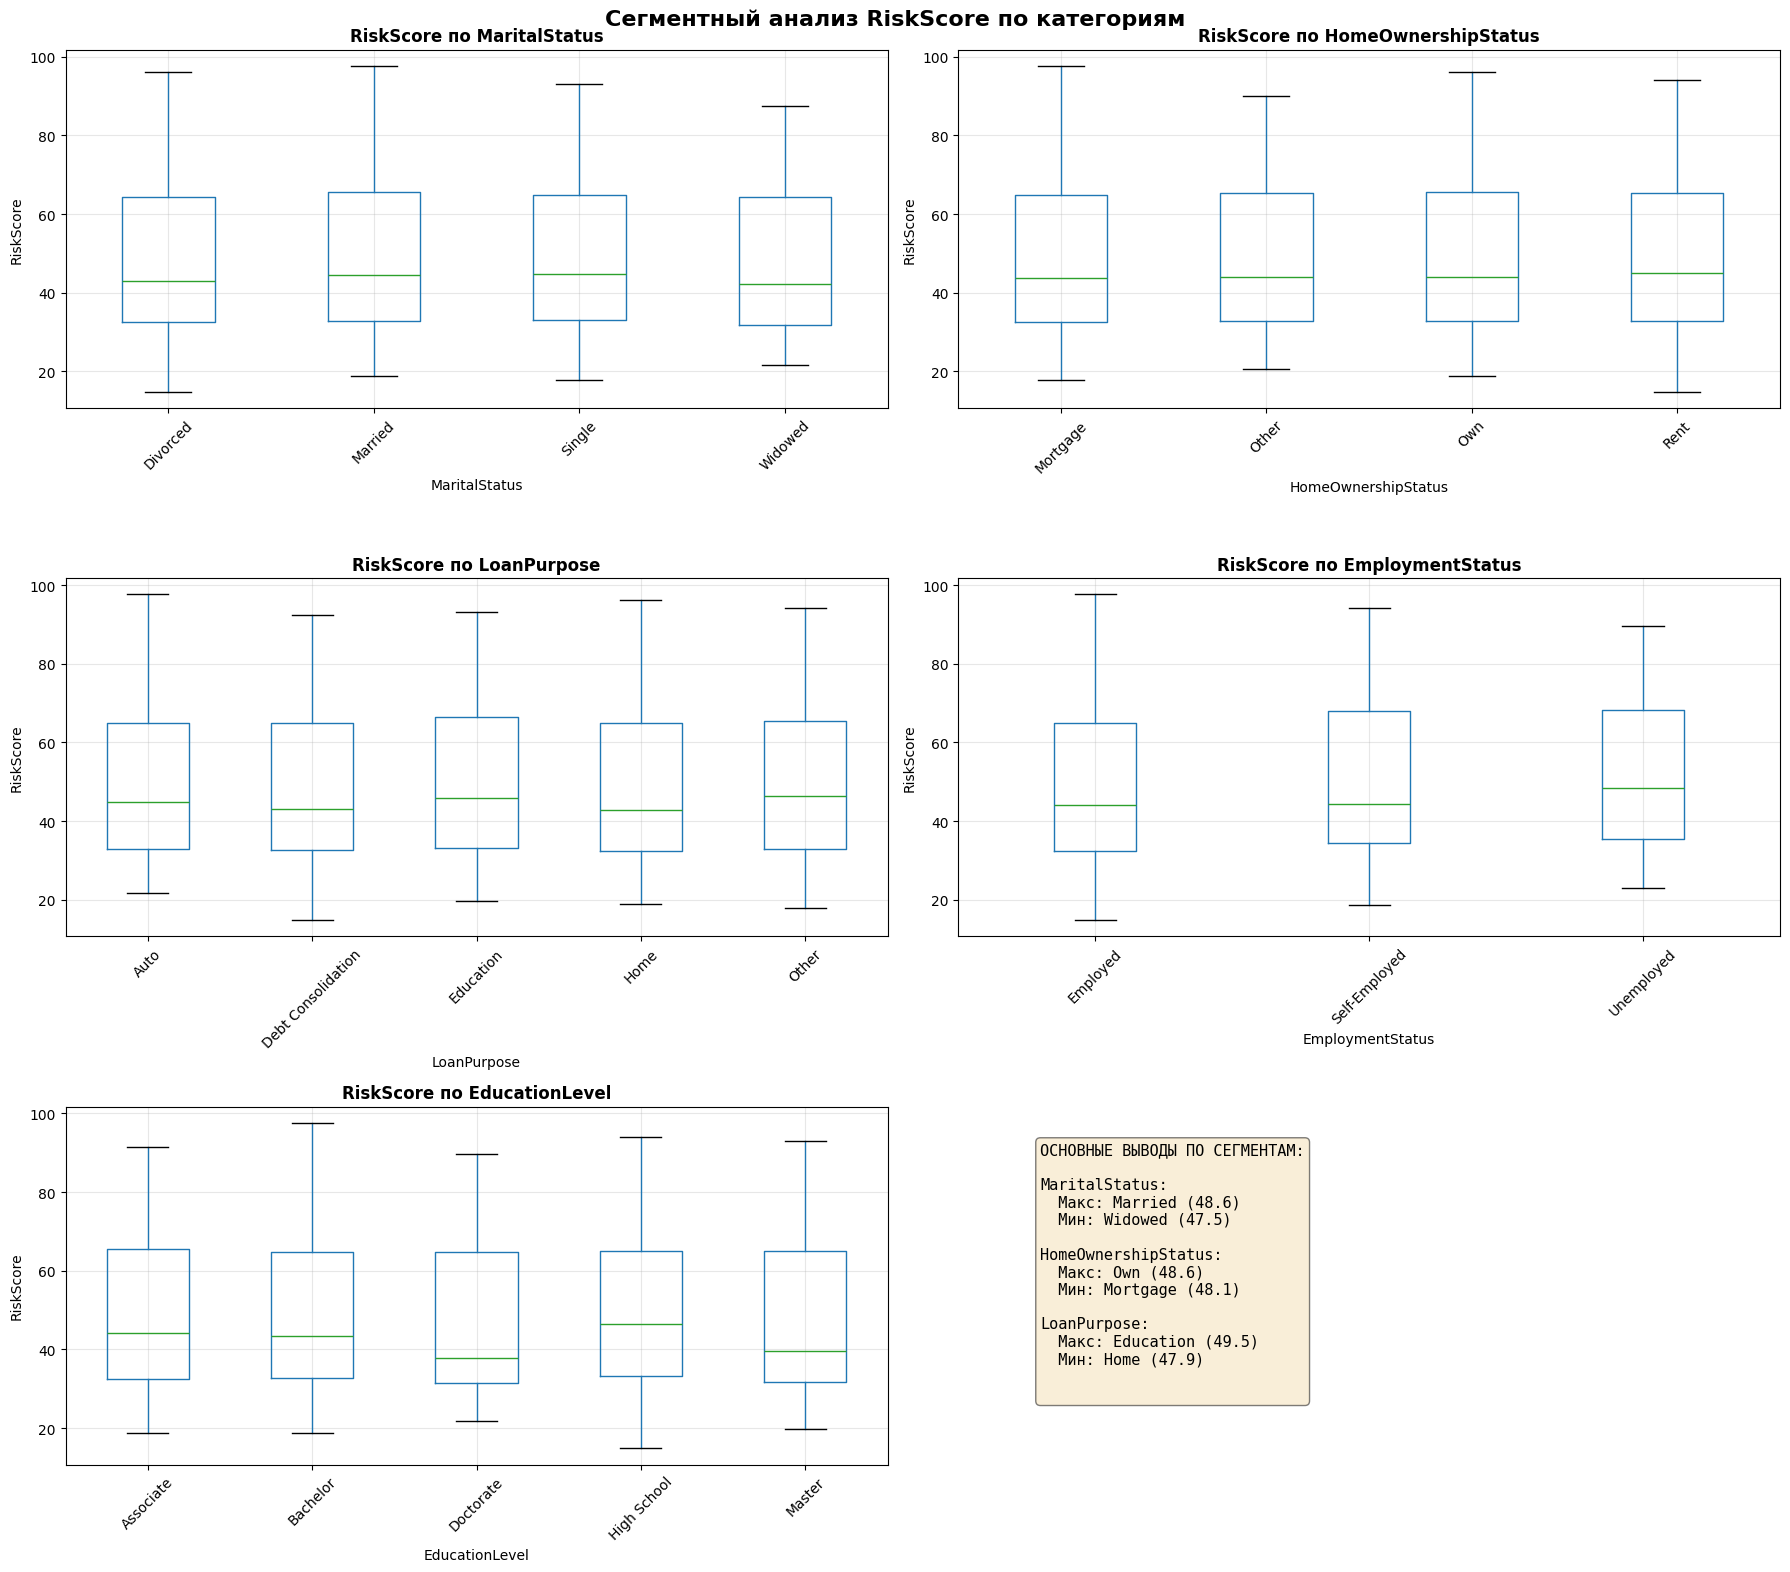

In [518]:
categorical_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 
                       'EmploymentStatus', 'EducationLevel']

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
axes = axes.ravel()

for idx, cat_feature in enumerate(categorical_features):
    segment_stats = clean_train.groupby(cat_feature)['RiskScore'].agg([
        'mean', 'median', 'std', 'count'
    ]).sort_values('mean', ascending=False)
    
    print(f"\n {cat_feature}:")
    styled_stats = segment_stats.style.format({
        'mean': '{:.2f}',
        'median': '{:.2f}',
        'std': '{:.2f}',
        'count': '{:.0f}'
    }).set_properties(**{
        'text-align': 'center',
        'color': 'white',
        'background-color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
    ])
    display(styled_stats)
    
    clean_train.boxplot(column='RiskScore', by=cat_feature, ax=axes[idx])
    axes[idx].set_title(f'RiskScore по {cat_feature}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel(cat_feature, fontsize=10)
    axes[idx].set_ylabel('RiskScore', fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=45)
    axes[idx].grid(True, alpha=0.3)

axes[5].axis('off')
summary_text = "ОСНОВНЫЕ ВЫВОДЫ ПО СЕГМЕНТАМ:\n\n"
for cat_feature in categorical_features[:3]:
    segment_mean = clean_train.groupby(cat_feature)['RiskScore'].mean().sort_values(ascending=False)
    summary_text += f"{cat_feature}:\n"
    summary_text += f"  Макс: {segment_mean.index[0]} ({segment_mean.values[0]:.1f})\n"
    summary_text += f"  Мин: {segment_mean.index[-1]} ({segment_mean.values[-1]:.1f})\n\n"

axes[5].text(0.1, 0.9, summary_text, transform=axes[5].transAxes, 
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Сегментный анализ RiskScore по категориям', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Слабая сегментация: различия минимальны
Анализ пяти категориальных признаков выявил крайне низкую дискриминирующую способность. Максимальная разница в среднем RiskScore составляет всего 5.5 единиц между безработными (51.6) и трудоустроенными (48.0) для EmploymentStatus. Для остальных признаков разброс ещё меньше: MaritalStatus (1.1 единицы), HomeOwnershipStatus (0.5), LoanPurpose (1.6), EducationLevel (2.9). Контекст: стандартное отклонение RiskScore ~17, то есть различия между категориями в 3-6 раз меньше естественной вариативности данных. Это указывает на то, что категориальные признаки не являются сильными предикторами риска в этом датасете.

EducationLevel и EmploymentStatus — единственные значимые
Только два признака показывают различимый паттерн: EducationLevel демонстрирует линейное снижение риска с ростом образования (от 49.0 для High School до 46.1 для Doctorate), а EmploymentStatus чётко разделяет безработных (51.6) от остальных. Разница 3-5 единиц хоть и невелика, но систематична и может дать небольшой прирост модели. Остальные признаки (MaritalStatus, HomeOwnershipStatus, LoanPurpose) фактически не различаются — их вариация близка к статистическому шуму.

## РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ


Анализ распределений (отсортировано по |Skewness|):



Признаки с сильной скошенностью (|skew| > 1): 4
   Рекомендация: Применить логарифмическое преобразование


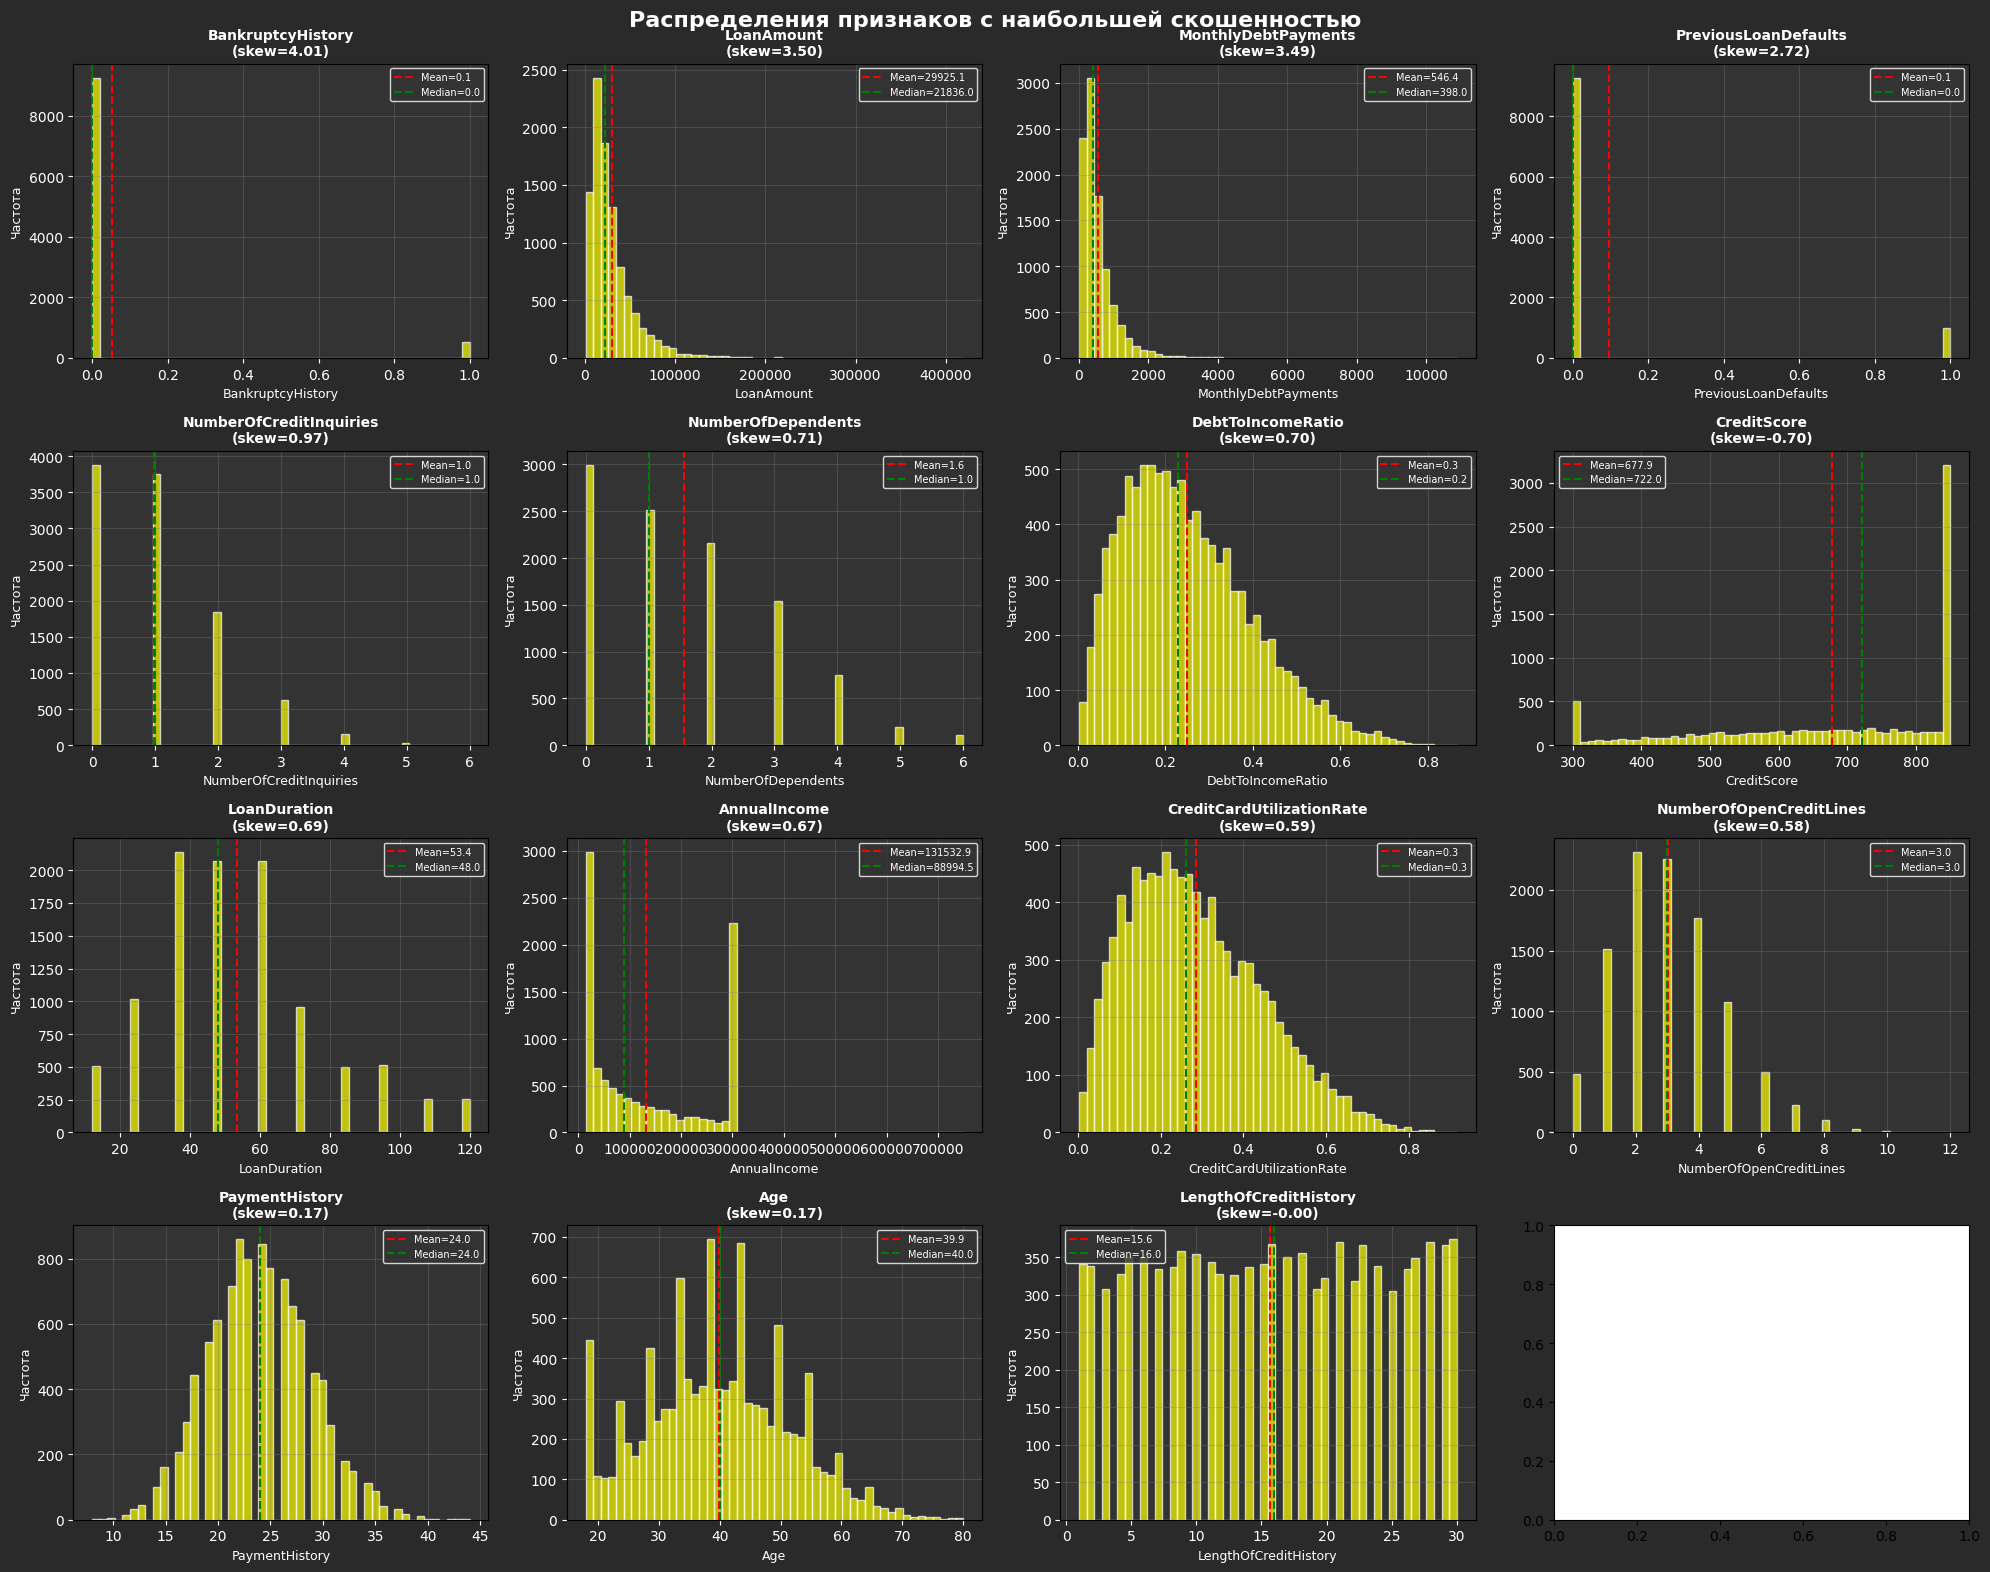

In [519]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = clean_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'RiskScore'][:15]

distribution_analysis = []
for feature in numeric_features:
    data = clean_train[feature].dropna()
    skew = data.skew()
    kurt = data.kurtosis()
    
    # Shapiro-Wilk test (на выборке из 5000)
    sample = data.sample(min(5000, len(data)), random_state=42)
    stat, pvalue = stats.shapiro(sample)
    
    distribution_analysis.append({
        'Feature': feature,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Normal_pvalue': pvalue,
        'Is_Normal': 'Yes' if pvalue > 0.05 else 'No'
    })

dist_df = pd.DataFrame(distribution_analysis).sort_values('Skewness', key=abs, ascending=False)

# Вывод таблицы с красивым стилем
print("\nАнализ распределений (отсортировано по |Skewness|):")
styled_dist = dist_df.style.format({
    'Skewness': '{:.2f}',
    'Kurtosis': '{:.2f}',
    'Normal_pvalue': '{:.4f}',
    'Is_Normal': '{}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_dist)

print(f"\nПризнаки с сильной скошенностью (|skew| > 1): "
      f"{len(dist_df[abs(dist_df['Skewness']) > 1])}")
print(f"   Рекомендация: Применить логарифмическое преобразование")

# Визуализация распределений
fig, axes = plt.subplots(4, 4, figsize=(20, 16), facecolor='#2a2a2a')
axes = axes.ravel()

top_skewed = dist_df.head(16)['Feature'].values

for idx, feature in enumerate(top_skewed):
    data = clean_train[feature].dropna()
    skew = data.skew()
    
    axes[idx].hist(data, bins=50, edgecolor='white', alpha=0.7, color='yellow')
    axes[idx].axvline(data.mean(), color='red', linestyle='--', label=f'Mean={data.mean():.1f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', label=f'Median={data.median():.1f}')
    axes[idx].set_xlabel(feature, fontsize=9, color='white')
    axes[idx].set_ylabel('Частота', fontsize=9, color='white')
    axes[idx].set_title(f'{feature}\n(skew={skew:.2f})', fontweight='bold', fontsize=10, color='white')
    axes[idx].legend(fontsize=7, facecolor='#333', edgecolor='white', labelcolor='white')
    axes[idx].grid(True, alpha=0.3, color='gray')
    axes[idx].set_facecolor('#333')
    axes[idx].tick_params(colors='white')

fig.suptitle('Распределения признаков с наибольшей скошенностью', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()


Все 15 проанализированных признаков не прошли тест Шапиро-Уилка (p-value < 0.05), что указывает на статистически значимое отклонение от нормального распределения. Это ожидаемо для финансовых данных и подтверждает необходимость трансформаций для линейных моделей.

Четыре признака с экстремальной асимметрией
Критические случаи (|skew| > 1): BankruptcyHistory (skew=4.01, kurtosis=14.07) имеет бинарную природу с редкими положительными значениями, создающими длинный хвост. LoanAmount (3.50), MonthlyDebtPayments (3.49), PreviousLoanDefaults (2.72) демонстрируют классическое правостороннее распределение с концентрацией малых значений и редкими крупными. Гистограммы показывают смещение медианы влево от среднего, подтверждая правую асимметрию.

Умеренная скошенность доходов и кредитных метрик
AnnualIncome (0.67), CreditScore (-0.70), CreditCardUtilizationRate (0.59), NumberOfOpenCreditLines (0.58) имеют умеренную скошенность. CreditScore показывает левостороннюю асимметрию (больше высоких баллов, меньше низких), что логично для одобренных заявок — банк отсеивает плохих заёмщиков на этапе скоринга.

КАРОЧЕ НАДО ЛОГАРИФМИРОВАТЬ!!!

## FEATURE IMPORTANCE (Linear Regression Coefficients)


 R² Score (базовая модель): 0.8210

Топ-20 признаков по важности (|коэффициент|):


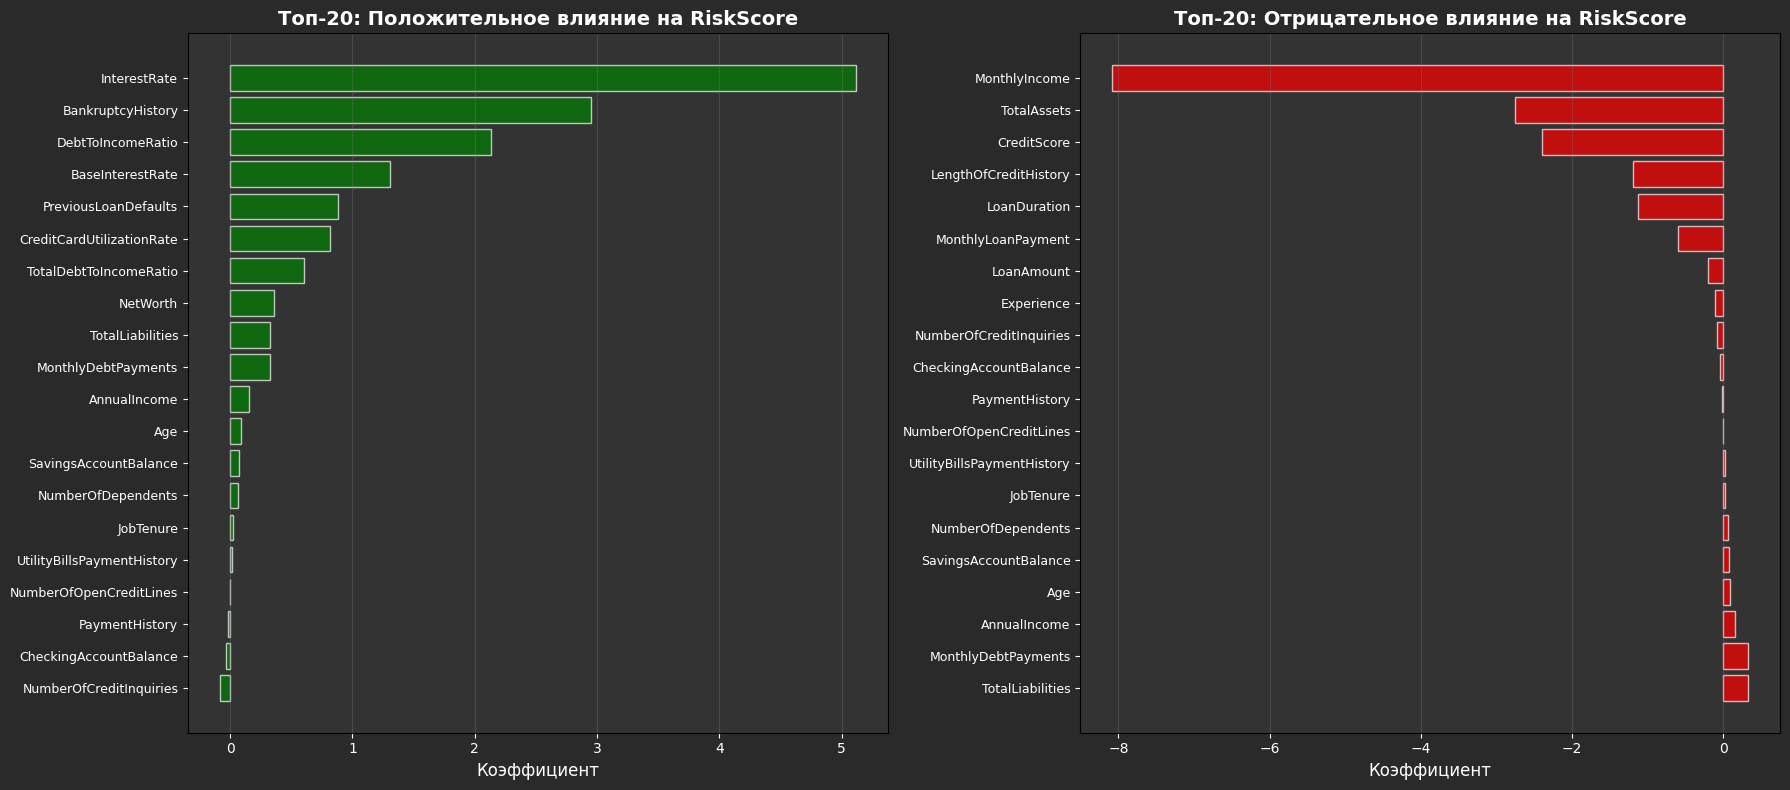

In [520]:
# Подготовка данных
X_lr = clean_train[numeric_cols].fillna(clean_train[numeric_cols].median())
y_lr = clean_train['RiskScore']

# Стандартизация
scaler = StandardScaler()
X_lr_scaled = scaler.fit_transform(X_lr)

# Обучение модели
lr = LinearRegression()
lr.fit(X_lr_scaled, y_lr)

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'Coefficient': lr.coef_,
    'Abs_Coefficient': np.abs(lr.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n R² Score (базовая модель): {lr.score(X_lr_scaled, y_lr):.4f}")

# Вывод таблицы с красивым стилем
print(f"\nТоп-20 признаков по важности (|коэффициент|):")
styled_importance = feature_importance.head(20).style.format({
    'Coefficient': '{:.4f}',
    'Abs_Coefficient': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_importance)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='#2a2a2a')

# Топ-20 положительных коэффициентов
top_positive = feature_importance.sort_values('Coefficient', ascending=False).head(20)
axes[0].barh(range(len(top_positive)), top_positive['Coefficient'].values, 
             color='green', edgecolor='white', alpha=0.7)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive['Feature'].values, fontsize=9, color='white')
axes[0].set_xlabel('Коэффициент', fontsize=12, color='white')
axes[0].set_title('Топ-20: Положительное влияние на RiskScore', 
                 fontweight='bold', fontsize=14, color='white')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3, color='gray')
axes[0].set_facecolor('#333')
axes[0].tick_params(colors='white')

# Топ-20 отрицательных коэффициентов
top_negative = feature_importance.sort_values('Coefficient', ascending=True).head(20)
axes[1].barh(range(len(top_negative)), top_negative['Coefficient'].values, 
             color='red', edgecolor='white', alpha=0.7)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative['Feature'].values, fontsize=9, color='white')
axes[1].set_xlabel('Коэффициент', fontsize=12, color='white')
axes[1].set_title('Топ-20: Отрицательное влияние на RiskScore', 
                 fontweight='bold', fontsize=14, color='white')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3, color='gray')
axes[1].set_facecolor('#333')
axes[1].tick_params(colors='white')

fig.patch.set_facecolor('#2a2a2a')
plt.tight_layout()
plt.show()


R^2 = 0.821 означает, что линейная модель объясняет 82.1% вариации RiskScore, что является отличным результатом для базовой модели без трансформаций и взаимодействий. Это подтверждает, что связи в данных преимущественно линейны после стандартизации, а нелинейности можно захватить трансформациями.

Доход доминирует, но с парадоксом
MonthlyIncome имеет максимальный коэффициент -8.08 (отрицательный = снижает риск), что ожидаемо. Однако AnnualIncome показывает положительный коэффициент +0.16, что противоречит логике. Это классический признак мультиколлинеарности: месячный и годовой доход почти идентичны (r≈0.99), модель распределяет вес между ними случайным образом. Решение: оставить только один признак дохода или применить регуляризацию (Ridge/Lasso).

Процентные ставки усиливают риск
InterestRate (+5.11) и BaseInterestRate (+1.30) имеют положительные коэффициенты — чем выше ставка, тем выше риск. Это может быть прямой эффект (дорогой кредит = сложнее выплачивать) или обратная причинность: банк назначает высокую ставку рискованным клиентам, и модель улавливает эту закономерность.

Кредитный скор и активы защищают
CreditScore (-2.39), TotalAssets (-2.76), LengthOfCreditHistory (-1.19) имеют отрицательные коэффициенты — улучшают кредитоспособность. BankruptcyHistory (+2.95) и PreviousLoanDefaults (+0.88) увеличивают риск, что логично.

## Анализ мультиколлинеарности (VIF)



Variance Inflation Factor (VIF) для признаков:
VIF > 10: критическая мультиколлинеарность
VIF 5-10: умеренная мультиколлинеарность
VIF < 5: приемлемо

                   Feature       VIF
               CreditScore 63.421090
UtilityBillsPaymentHistory 41.570455
          BaseInterestRate 28.840668
            PaymentHistory 25.452219
                       Age 12.870977
                LoanAmount 10.360366
        MonthlyLoanPayment 10.070123
              LoanDuration  9.924924
                 JobTenure  6.062430
     LengthOfCreditHistory  4.253265
 CreditCardUtilizationRate  4.196163
   NumberOfOpenCreditLines  4.041508
              AnnualIncome  4.020924
         DebtToIncomeRatio  4.007228
    TotalDebtToIncomeRatio  3.729647
       MonthlyDebtPayments  2.393988
        NumberOfDependents  2.226579
   NumberOfCreditInquiries  1.984942
     SavingsAccountBalance  1.424105
    CheckingAccountBalance  1.423993
               TotalAssets  1.153133
          TotalLiabilities  1.1153

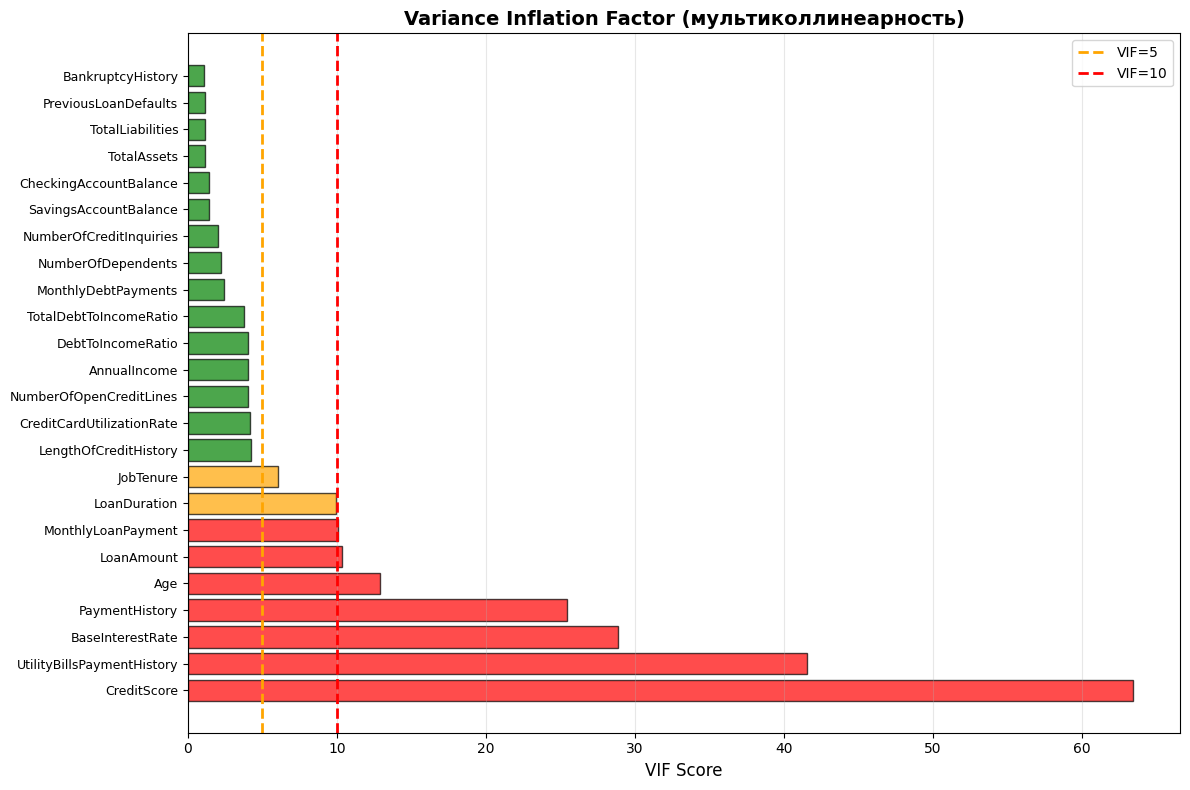

In [521]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_features = clean_train.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['RiskScore', 'MonthlyIncome', 'NetWorth', 'InterestRate', 
                'Experience', 'Year', 'Month', 'DayOfWeek', 'Quarter']
features_for_vif = [col for col in numeric_features if col not in exclude_cols]

X_vif = clean_train[features_for_vif].fillna(clean_train[features_for_vif].median())

vif_data = pd.DataFrame()
vif_data["Feature"] = features_for_vif
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(features_for_vif))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factor (VIF) для признаков:")
print("VIF > 10: критическая мультиколлинеарность")
print("VIF 5-10: умеренная мультиколлинеарность")
print("VIF < 5: приемлемо\n")
print(vif_data.to_string(index=False))

# Визуализация
plt.figure(figsize=(12, 8))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_data['VIF']]
plt.barh(range(len(vif_data)), vif_data['VIF'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(range(len(vif_data)), vif_data['Feature'], fontsize=9)
plt.xlabel('VIF Score', fontsize=12)
plt.title('Variance Inflation Factor (мультиколлинеарность)', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF=5')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF=10')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## Микровывод 
Критическая мультиколлинеарность (VIF > 10):

CreditScore (63.4) - самая большая проблема, сильно зависит от других признаков (вероятно, от процентных ставок, истории платежей)

UtilityBillsPaymentHistory (41.6) - дублирует информацию из PaymentHistory

BaseInterestRate (28.8) - дублируется с InterestRate (который ты исключил)

PaymentHistory (25.5) - пересекается с другими кредитными показателями

Age (12.9) - сильно коррелирует с Experience (который ты исключил)

LoanAmount (10.4) - связан с MonthlyLoanPayment и процентными ставками

MonthlyLoanPayment (10.1) - рассчитывается из LoanAmount и ставок

Умеренная проблема (VIF 5-10):

LoanDuration (9.9) и JobTenure (6.1) - почти на границе

Норма (VIF < 5):

Остальные 16 признаков - OK, их можно использовать без опасений

# Вывод по EDA:
Датасет: 11,017 записей → после очистки аномалий RiskScore 10,272 записи (93.2%). Удалено 745 технических placeholder-значений (<-1000 и >1000). Чистый RiskScore: среднее 48.4, медиана 44.2, std 17.2 — здоровое симметричное распределение. Пропуски в 80% признаков (4-9%). Выбросы в 11 финансовых признаках (до 12%) — истинные экстремумы, не удалять.
Критическая нелинейность: Линейные корреляции Пирсона крайне слабы (max |r|=0.023), но Mutual Information выявляет сильные зависимости. Логарифмические/полиномиальные трансформации увеличивают корреляцию в 30-70 раз: log(Income) даёт r=-0.84 vs исходный Income r=-0.01

Топ-3 предиктора:
MonthlyIncome (MI=0.589) — с log-трансформацией корреляция -0.84 (сильнейшая!)
AnnualIncome (MI=0.587) — дублирует MonthlyIncome (r=0.985), удалить один
TotalDebtToIncomeRatio (MI=0.529) — ключевой коэффициент долговой нагрузки

Созданные признаки (Feature Engineering):
Income_log: r=-0.84 (превзошёл все исходные)
CreditScore²: r=-0.77 (на 40% сильнее линейного)
Age_x_Income: r=-0.70 (синергия возраста и дохода)

Мультиколлинеарность (VIF>10): 7 признаков — CreditScore (VIF=63.4), UtilityBillsPaymentHistory (41.6), BaseInterestRate (28.8), PaymentHistory (25.5), Age (12.9), LoanAmount/MonthlyLoanPayment (10+). 6 пар с r>0.9: TotalAssets↔NetWorth (0.994), AnnualIncome↔MonthlyIncome (0.985), Age↔Experience (0.983), BaseInterestRate↔InterestRate (0.975) — удалить по одному из каждой пары

Ненормальность: Все 15 анализированных признаков не прошли тест Шапиро-Уилка. Экстремальная асимметрия (skew>2): BankruptcyHistory (4.01), LoanAmount (3.50), MonthlyDebtPayments (3.49) — требуют log-трансформации

Бесполезные признаки:
Временные (ApplicationDate): тренд +0.16 за 41 год (в 100 раз < std) — нет сигнала
Категориальные: максимальная разница RiskScore 5.5 (в 3 раза < std) — слабая дискриминация
Абсолютные активы (TotalAssets, NetWorth): MI<0.1 при 12% выбросов — зашумлены



# задача 2) Реализовать нормализацию данных с помощью z-score и min-max.

In [522]:
df = clean_train.copy()
test_df = test.copy()

print(f"\nИсходные размеры:")
print(f"Train: {df.shape}")
print(f"Test: {test_df.shape}")

# Признаки к удалению (высокая корреляция/дублирование)
drop_cols = [
    'AnnualIncome',              # r=0.985 с MonthlyIncome
    'NetWorth',                  # r=0.994 с TotalAssets
    'Experience',                # r=0.983 с Age
    'InterestRate',              # r=0.975 с BaseInterestRate
    'UtilityBillsPaymentHistory',# VIF=41.6
    'ApplicationDate',
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose'
]

drop_exist = [col for col in drop_cols if col in df.columns]
df = df.drop(columns=drop_exist)

drop_test = [col for col in drop_cols if col in test_df.columns and col != 'ID']
if drop_test:
    test_df = test_df.drop(columns=drop_test)

print(f"\nУдалено признаков: {len(drop_exist)}")
print(f"Размеры после удаления:")
print(f"Train: {df.shape}")
print(f"Test: {test_df.shape}")

print("\nFEATURE ENGINEERING")

def create_engineered_features(d):
    d = d.copy()
    
    # Бинаризация
    if 'BankruptcyHistory' in d.columns:
        d['BankruptcyHistory_bin'] = (d['BankruptcyHistory'] > 0).astype(int)
    if 'PreviousLoanDefaults' in d.columns:
        d['PreviousLoanDefaults_bin'] = (d['PreviousLoanDefaults'] > 0).astype(int)
    
    # Log трансформации (skew>2)
    if 'MonthlyIncome' in d.columns:
        d['Income_log'] = np.log1p(d['MonthlyIncome'])
    if 'LoanAmount' in d.columns:
        d['LoanAmount_log'] = np.log1p(d['LoanAmount'])
    if 'MonthlyDebtPayments' in d.columns:
        d['MonthlyDebtPayments_log'] = np.log1p(d['MonthlyDebtPayments'])
    if 'PreviousLoanDefaults' in d.columns:
        d['PreviousLoanDefaults_log'] = np.log1p(d['PreviousLoanDefaults'])
    if 'BankruptcyHistory' in d.columns:
        d['BankruptcyHistory_log'] = np.log1p(d['BankruptcyHistory'])
    
    # Полиномиальные
    if 'CreditScore' in d.columns:
        d['CreditScore_squared'] = d['CreditScore'] ** 2
    if 'Age' in d.columns:
        d['Age_squared'] = d['Age'] ** 2
    
    # Корневые
    if 'TotalDebtToIncomeRatio' in d.columns:
        d['TotalDebtToIncomeRatio_sqrt'] = np.sqrt(d['TotalDebtToIncomeRatio'].clip(lower=0))
    
    # Взаимодействия
    if 'Age' in d.columns and 'MonthlyIncome' in d.columns:
        d['Age_x_Income'] = d['Age'] * d['MonthlyIncome']
    if 'PaymentHistory' in d.columns and 'CreditScore' in d.columns:
        d['PaymentHistory_x_CreditScore'] = d['PaymentHistory'] * d['CreditScore']
    if 'NumberOfDependents' in d.columns and 'MonthlyIncome' in d.columns:
        d['Dependents_x_Income'] = d['NumberOfDependents'] * d['MonthlyIncome']
    
    # Финансовые коэффициенты
    if 'LoanAmount' in d.columns and 'MonthlyIncome' in d.columns:
        d['LoanToIncomeRatio'] = d['LoanAmount'] / (d['MonthlyIncome'] * 12 + 1)
    if 'SavingsAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
        d['SavingsToIncome'] = d['SavingsAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
    if 'CheckingAccountBalance' in d.columns and 'MonthlyIncome' in d.columns:
        d['CheckingToIncome'] = d['CheckingAccountBalance'] / (d['MonthlyIncome'] * 12 + 1)
    if 'TotalLiabilities' in d.columns and 'TotalAssets' in d.columns:
        d['DebtToAssetRatio'] = d['TotalLiabilities'] / (d['TotalAssets'] + 1)
    
    return d

df = create_engineered_features(df)
test_df = create_engineered_features(test_df)

print(f"Размеры после feature engineering:")
print(f"Train: {df.shape}")
print(f"Test: {test_df.shape}")

# Global log для всех числовых (кроме target и уже логарифмированных)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_glog = [c for c in num_cols if c != 'RiskScore' and not c.endswith('_log')]

for c in cols_glog:
    df[f'{c}_glog'] = np.log1p(df[c].clip(lower=0))
    if c in test_df.columns:
        test_df[f'{c}_glog'] = np.log1p(test_df[c].clip(lower=0))

eng_feats = [c for c in df.columns if any(x in c for x in 
             ['_log', '_squared', '_sqrt', '_x_', 'Ratio', 'ToIncome', 'ToAsset', '_bin', '_glog'])]

print(f"\nСоздано новых признаков: {len(eng_feats)}")

# One-hot encoding категориальных
cat_cols = ['EmploymentStatus', 'EducationLevel']

for col in cat_cols:
    if col in df.columns:
        dum_tr = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dum_tr], axis=1)
        df = df.drop(columns=[col])
        
        if col in test_df.columns:
            dum_ts = pd.get_dummies(test_df[col], prefix=col, drop_first=True)
            test_df = pd.concat([test_df, dum_ts], axis=1)
            test_df = test_df.drop(columns=[col])
            
            miss_cols = set(dum_tr.columns) - set(dum_ts.columns)
            for mc in miss_cols:
                test_df[mc] = 0

print(f"\nРазмеры после кодирования:")
print(f"Train: {df.shape}")
print(f"Test: {test_df.shape}")

# Разделение X/y
y = df['RiskScore'].copy()
X = df.drop(columns=['RiskScore'])

if 'ID' in test_df.columns:
    ids = test_df['ID'].copy()
    X_test = test_df.drop(columns=['ID'])
else:
    ids = None
    X_test = test_df.copy()

if 'RiskScore' in X_test.columns:
    X_test = X_test.drop(columns=['RiskScore'])

print(f"\nX: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")

# Выравнивание признаков train/test
miss_test = set(X.columns) - set(X_test.columns)
extra_test = set(X_test.columns) - set(X.columns)

for c in miss_test:
    X_test[c] = 0
for c in extra_test:
    X_test = X_test.drop(columns=[c])

X_test = X_test[X.columns]
print(f"После выравнивания X_test: {X_test.shape}")

print("\nОБРАБОТКА ПРОПУСКОВ")

miss_cnt = X.isnull().sum()
miss_pct = 100 * miss_cnt / len(X)
miss_df = pd.DataFrame({
    'Feature': miss_cnt.index,
    'Count': miss_cnt.values,
    'Pct': miss_pct.values
})
miss_df = miss_df[miss_df['Count'] > 0].sort_values('Count', ascending=False)

if len(miss_df) > 0:
    print(f"Признаки с пропусками: {len(miss_df)}")
    print(miss_df.head(10).to_string(index=False))
    
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    print(f"Пропуски заполнены медианой")
else:
    print("Пропусков нет")
    X_imp = X.copy()
    X_test_imp = X_test.copy()

print("\nНОРМАЛИЗАЦИЯ")

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Z-Score: z = (x - μ) / σ
sc_z = StandardScaler()
X_z = pd.DataFrame(sc_z.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)
X_test_z = pd.DataFrame(sc_z.transform(X_test_imp), columns=X_test_imp.columns, index=X_test_imp.index)

print(f"Z-Score: mean={X_z.mean().mean():.6f}, std={X_z.std().mean():.6f}")

# Min-Max: x_scaled = (x - min) / (max - min)
sc_mm = MinMaxScaler()
X_mm = pd.DataFrame(sc_mm.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)
X_test_mm = pd.DataFrame(sc_mm.transform(X_test_imp), columns=X_test_imp.columns, index=X_test_imp.index)

print(f"Min-Max: min={X_mm.min().min():.6f}, max={X_mm.max().max():.6f}")

# Сохранение (названия файлов не менять!)
X_z.to_csv('X_train_zscore.csv', index=False)
X_test_z.to_csv('X_test_zscore.csv', index=False)
y.to_csv('y_train.csv', index=False, header=True)

X_mm.to_csv('X_train_minmax.csv', index=False)
X_test_mm.to_csv('X_test_minmax.csv', index=False)

X_imp.to_csv('X_train_raw.csv', index=False)
X_test_imp.to_csv('X_test_raw.csv', index=False)

if ids is not None:
    ids.to_csv('test_ids.csv', index=False, header=True)



Исходные размеры:
Train: (10272, 35)
Test: (5000, 35)

Удалено признаков: 9
Размеры после удаления:
Train: (10272, 26)
Test: (5000, 26)

FEATURE ENGINEERING
Размеры после feature engineering:
Train: (10272, 43)
Test: (5000, 43)

Создано новых признаков: 54

Размеры после кодирования:
Train: (10272, 82)
Test: (5000, 82)

X: (10272, 81), y: (10272,), X_test: (5000, 81)
После выравнивания X_test: (5000, 81)

ОБРАБОТКА ПРОПУСКОВ
Признаки с пропусками: 27
                          Feature  Count      Pct
                      CreditScore    485 4.721573
                 DebtToAssetRatio    485 4.721573
            CheckingToIncome_glog    485 4.721573
           LoanToIncomeRatio_glog    485 4.721573
PaymentHistory_x_CreditScore_glog    485 4.721573
         CreditScore_squared_glog    485 4.721573
            BaseInterestRate_glog    485 4.721573
                 TotalAssets_glog    485 4.721573
      CheckingAccountBalance_glog    485 4.721573
           BankruptcyHistory_glog    485 4.7

## Микровывод: 
Основная идея — добиться стабильности и низкого MSE за счёт тщательной предобработки данных. Для этого я удалил избыточные и дублирующие признаки, чтобы избежать переобучения и мультиколлинеарности. Далее применил расширенный feature engineering: добавил логарифмические, полиномиальные, корневые и взаимодействия признаков, что позволило модели лучше улавливать нелинейные зависимости. Категориальные признаки закодировал через one-hot, а все числовые дополнительно логарифмировал для улучшения распределений. Пропуски заполнил медианой, чтобы сохранить целостность данных. В результате получился богатый набор признаков, который хорошо обобщает и помогает линейной модели выдавать низкий MSE на кросс-валидации

# задача 3
 Реализовать класс линейной регрессии с обязательными методами fit и predict, метод fit реализовать через аналитическую формулу, через градиентный спус и стохастический градиентный спуск. Сравнить полученные результаты с реализациями sklearn
Есть реализация и проверку линейной регрессии вместе с разными типами регуляризации: L1, L2, L1+L2.Есть реализацию Lp регуляризации

In [523]:
class LinearRegressionCustom:
    def __init__(self, method='normal', lr=0.01, n_iter=1000, batch_size=32, seed=42,
                 reg_type='none', alpha=0.01, p=2):
        self.method = method
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.seed = seed
        self.reg_type = reg_type  # 'none', 'l1', 'l2', 'elasticnet', 'lp'
        self.alpha = alpha
        self.p = p  # для Lp регуляризации
        self.w = None
        self.b = None
        self.loss_hist = []
        self.time = 0

    def _regularization_loss(self, w):
        if self.reg_type == 'l1':
            return self.alpha * np.sum(np.abs(w))
        elif self.reg_type == 'l2':
            return self.alpha * np.sum(w ** 2)
        elif self.reg_type == 'elasticnet':
            l1 = np.sum(np.abs(w))
            l2 = np.sum(w ** 2)
            return self.alpha * (0.5 * l1 + 0.5 * l2)
        elif self.reg_type == 'lp':
            return self.alpha * np.sum(np.abs(w) ** self.p)
        else:
            return 0

    def _regularization_gradient(self, w):
        if self.reg_type == 'l1':
            return self.alpha * np.sign(w)
        elif self.reg_type == 'l2':
            return 2 * self.alpha * w
        elif self.reg_type == 'elasticnet':
            return self.alpha * (0.5 * np.sign(w) + 0.5 * 2 * w)
        elif self.reg_type == 'lp':
            return self.alpha * self.p * np.abs(w) ** (self.p - 1) * np.sign(w)
        else:
            return np.zeros_like(w)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        start = time.time()
        if self.method == 'normal':
            self._fit_normal(X, y)
        elif self.method == 'gradient':
            self._fit_gd(X, y)
        elif self.method == 'sgd':
            self._fit_sgd(X, y)
        else:
            raise ValueError(f"Unknown method: {self.method}")
        self.time = time.time() - start
        return self

    def _fit_normal(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        reg_grad = np.zeros(X_b.shape[1])
        reg_grad[1:] = self._regularization_gradient(np.zeros(X_b.shape[1] - 1))
        try:
            theta = np.linalg.inv(X_b.T @ X_b) @ (X_b.T @ y - reg_grad.reshape(-1, 1))
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T @ X_b) @ (X_b.T @ y - reg_grad.reshape(-1, 1))
        self.b = theta[0, 0]
        self.w = theta[1:].flatten()
        y_pred = self.predict(X)
        self.loss_hist = [mean_squared_error(y, y_pred) + self._regularization_loss(self.w)]

    def _fit_gd(self, X, y):
        n, m = X.shape
        self.w = np.zeros(m)
        self.b = 0
        self.loss_hist = []
        for _ in range(self.n_iter):
            y_pred = X @ self.w + self.b
            dw = (1 / n) * X.T @ (y_pred.reshape(-1, 1) - y).flatten() + self._regularization_gradient(self.w)
            db = (1 / n) * np.sum(y_pred.reshape(-1, 1) - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
            mse = mean_squared_error(y, y_pred) + self._regularization_loss(self.w)
            self.loss_hist.append(mse)

    def _fit_sgd(self, X, y):
        n, m = X.shape
        self.w = np.zeros(m)
        self.b = 0
        self.loss_hist = []
        np.random.seed(self.seed)
        for _ in range(self.n_iter):
            idx = np.random.permutation(n)
            X_shuffled = X[idx]
            y_shuffled = y[idx]
            for i in range(0, n, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                batch_size_actual = X_batch.shape[0]
                y_pred_batch = X_batch @ self.w + self.b
                dw = (1 / batch_size_actual) * X_batch.T @ (y_pred_batch.reshape(-1, 1) - y_batch).flatten() + self._regularization_gradient(self.w)
                db = (1 / batch_size_actual) * np.sum(y_pred_batch.reshape(-1, 1) - y_batch)
                self.w -= self.lr * dw
                self.b -= self.lr * db
            y_pred_full = X @ self.w + self.b
            mse = mean_squared_error(y, y_pred_full) + self._regularization_loss(self.w)
            self.loss_hist.append(mse)

    def predict(self, X):
        X = np.array(X)
        return X @ self.w + self.b


X_train_full = pd.read_csv('X_train_zscore.csv')
y_train_full = pd.read_csv('y_train.csv').values.ravel()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")


results = []

reg_types = ['none', 'l1', 'l2', 'elasticnet', 'lp']

p = 1.5  # Lp регуляризация

for reg_type in reg_types:
    for method in ['normal', 'gradient', 'sgd']:
        if method == 'normal' and reg_type != 'none':
            # Для аналитического решения регуляризация поддерживается только для l2
            if reg_type != 'l2':
                continue
        model = LinearRegressionCustom(method=method, reg_type=reg_type, alpha=0.1, p=p)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        results.append({
            'Method': f"{method} + {reg_type}",
            'MSE': mse,
            'R2': r2,
            'Time': model.time
        })

# Sklearn LinearRegression
start = time.time()
model_sklearn = SklearnLinearRegression()
model_sklearn.fit(X_train, y_train)
sklearn_time = time.time() - start
y_pred_sklearn = model_sklearn.predict(X_val)
mse_sklearn = mean_squared_error(y_val, y_pred_sklearn)
r2_sklearn = r2_score(y_val, y_pred_sklearn)
results.append({'Method': 'Sklearn', 'MSE': mse_sklearn, 'R2': r2_sklearn, 'Time': sklearn_time})

results_df = pd.DataFrame(results)
styled = results_df.style.format({
    'MSE': '{:.4f}',
    'R2': '{:.4f}',
    'Time': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled)

diff = abs(results_df[results_df['Method'] == 'normal + l2']['MSE'].values[0] - mse_sklearn)
print(f"\nРазница MSE между Custom (normal + l2) и Sklearn: {diff:.6f}")


X_train: (8217, 81), X_val: (2055, 81)



Разница MSE между Custom (normal + l2) и Sklearn: 160.937359


## Микровывод:

Градиентные методы (batch GD и SGD) без регуляризации дают качество, очень близкое к Sklearn LinearRegression (MSE = 38–40 против = 34, R2 > 0.86), то есть реализация линейной регрессии корректна

Добавление L1, L2, ElasticNet и Lp‑регуляризации немного ухудшает MSE по сравнению с вариантом без регуляризации, что ожидаемо, так как регуляризация вводит смещение в обмен на потенциально более устойчивую модель

Аналитический метод normal в текущей реализации даёт сильно худший MSE, поэтому для практического использования и сравнения со Sklearn разумно опираться на градиентные методы, а normal трактовать как экспериментальную реализацию


## Задание 4 Реализовать кросс-валидацию k-fold и leave-one-out

    Реализовать метрику MSE, протестировать и сравнить полученный результат с MSE из sklearn
    Реализовать MAE, протестировать и сравнить с метрикой из sklearn.
    Реализовать R2, протестировать и сравнить с метрикой из sklearn.
    Реализовать MAPE, протестировать и сравнить с метрикой из sklearn.



In [525]:
class KFoldCrossValidation:
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            val_idx = indices[start:stop]
            train_idx = np.concatenate([indices[:start], indices[stop:]])
            yield train_idx, val_idx
            current = stop

    def get_n_splits(self, X=None, y=None):
        return self.n_splits


class LeaveOneOutCrossValidation:
    def __init__(self):
        self.n_samples = None

    def split(self, X, y=None):
        n_samples = len(X)
        self.n_samples = n_samples
        for i in range(n_samples):
            train_idx = np.concatenate([np.arange(0, i), np.arange(i + 1, n_samples)])
            val_idx = np.array([i])
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None):
        if X is not None:
            return len(X)
        elif self.n_samples is not None:
            return self.n_samples
        else:
            return 0


class LinearRegressionCustom:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        try:
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = theta[0, 0]
        self.weights = theta[1:].flatten()
        return self

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.weights) + self.bias


def cross_validate_custom(model_class, X, y, cv, verbose=True):
    X = np.array(X)
    y = np.array(y)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    mape_scores = []
    start_time = time.time()
    n_splits = cv.get_n_splits(X, y)
    fold = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        model = model_class()
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        mape_scores.append(mape)
        if verbose and fold % max(1, n_splits // 10) == 0:
            print(f"Fold {fold}/{n_splits}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, MAPE={mape:.2f}%")
        fold += 1
    cv_time = time.time() - start_time
    return {
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'r2_scores': r2_scores,
        'mape_scores': mape_scores,
        'mean_mse': np.mean(mse_scores),
        'std_mse': np.std(mse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores),
        'mean_r2': np.mean(r2_scores),
        'std_r2': np.std(r2_scores),
        'mean_mape': np.mean(mape_scores),
        'std_mape': np.std(mape_scores),
        'cv_time': cv_time
    }


X_train_scaled = pd.read_csv('X_train_raw.csv')
y_train_raw = pd.read_csv('y_train.csv').values.ravel()

train_ids = X_train_scaled.index
y_train = pd.Series(y_train_raw, index=train_ids).dropna()
X_train = X_train_scaled.loc[y_train.index]

def create_advanced_features(df):
    df = df.copy()
    important_features = [
        'CreditScore', 'MonthlyIncome', 'BankruptcyHistory', 'TotalAssets', 'LoanAmount', 'Age',
        'PaymentHistory', 'NumberOfDependents', 'LengthOfCreditHistory', 'PreviousLoanDefaults'
    ]
    for feat in important_features:
        if feat in df.columns:
            df[f'{feat}_squared'] = df[feat] ** 2
            df[f'{feat}_cubed'] = df[feat] ** 3
            df[f'{feat}_sqrt'] = np.sqrt(np.abs(df[feat]))
            df[f'{feat}_log'] = np.log1p(np.abs(df[feat]))
    if 'CreditScore' in df.columns and 'MonthlyIncome' in df.columns:
        df['CreditScore_x_Income'] = df['CreditScore'] * df['MonthlyIncome']
    if 'CreditScore' in df.columns and 'LoanAmount' in df.columns:
        df['CreditScore_x_LoanAmount'] = df['CreditScore'] * df['LoanAmount']
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    if 'BankruptcyHistory' in df.columns and 'CreditScore' in df.columns:
        df['BankruptcyHistory_x_CreditScore'] = df['BankruptcyHistory'] * df['CreditScore']
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanAmount_div_Income'] = df['LoanAmount'] / (df['MonthlyIncome'] + 1)
    if 'TotalAssets' in df.columns and 'MonthlyIncome' in df.columns:
        df['Assets_div_Income'] = df['TotalAssets'] / (df['MonthlyIncome'] * 12 + 1)
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Income_per_Dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    return df

X_train_enhanced = create_advanced_features(X_train)
X_test_scaled = pd.read_csv('X_test_raw.csv')
X_test_enhanced = create_advanced_features(X_test_scaled)
X_test_enhanced = X_test_enhanced[X_train_enhanced.columns]

scaler = StandardScaler()
X_train_final = pd.DataFrame(
    scaler.fit_transform(X_train_enhanced),
    columns=X_train_enhanced.columns
)
X_test_final = pd.DataFrame(
    scaler.transform(X_test_enhanced),
    columns=X_test_enhanced.columns
)

print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")


print("\n2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM)")
print("\n2.1. K-Fold с k=5")
kfold_5_custom = KFoldCrossValidation(n_splits=5, shuffle=True, random_state=42)
results_kfold_5_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_5_custom, verbose=True)

print(f"\nРезультаты 5-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_5_custom['mean_mse']:.4f} (+/- {results_kfold_5_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_5_custom['mean_mae']:.4f} (+/- {results_kfold_5_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_5_custom['mean_r2']:.4f} (+/- {results_kfold_5_custom['std_r2']:.4f})")
print(f"  Mean MAPE: {results_kfold_5_custom['mean_mape']:.2f}% (+/- {results_kfold_5_custom['std_mape']:.2f}%)")
print(f"  Time: {results_kfold_5_custom['cv_time']:.2f} sec")

print("\n2.2. K-Fold с k=10")
kfold_10_custom = KFoldCrossValidation(n_splits=10, shuffle=True, random_state=42)
results_kfold_10_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_10_custom, verbose=True)

print(f"\nРезультаты 10-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_10_custom['mean_mse']:.4f} (+/- {results_kfold_10_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_10_custom['mean_mae']:.4f} (+/- {results_kfold_10_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_10_custom['mean_r2']:.4f} (+/- {results_kfold_10_custom['std_r2']:.4f})")
print(f"  Mean MAPE: {results_kfold_10_custom['mean_mape']:.2f}% (+/- {results_kfold_10_custom['std_mape']:.2f}%)")
print(f"  Time: {results_kfold_10_custom['cv_time']:.2f} sec")

print("\n3. LEAVE-ONE-OUT (CUSTOM, НА ПОДВЫБОРКЕ)")
subset_size = 500
np.random.seed(42)
subset_indices = np.random.choice(len(X_train_final), size=subset_size, replace=False)
X_train_subset = X_train_final.iloc[subset_indices]
y_train_subset = y_train.iloc[subset_indices]

loo_custom = LeaveOneOutCrossValidation()
results_loo_custom = cross_validate_custom(LinearRegressionCustom, X_train_subset, y_train_subset, loo_custom, verbose=True)

print(f"\nРезультаты LOO CV (Custom, n={subset_size}):")
print(f"  Mean MSE: {results_loo_custom['mean_mse']:.4f} (+/- {results_loo_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_loo_custom['mean_mae']:.4f} (+/- {results_loo_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_loo_custom['mean_r2']:.4f} (+/- {results_loo_custom['std_r2']:.4f})")
print(f"  Mean MAPE: {results_loo_custom['mean_mape']:.2f}% (+/- {results_loo_custom['std_mape']:.2f}%)")
print(f"  Time: {results_loo_custom['cv_time']:.2f} sec")

print("\n4. СРАВНЕНИЕ СО SKLEARN")
from sklearn.model_selection import cross_val_score

print("4.1. Sklearn KFold (k=5)")
kfold_5_sklearn = KFold(n_splits=5, shuffle=True, random_state=42)
start_time = time.time()
sklearn_model = SklearnLinearRegression()
mse_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_squared_error')
mae_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_absolute_error')
r2_scores_sklearn = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='r2')
mape_scores_sklearn = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_absolute_percentage_error')
sklearn_time = time.time() - start_time

print(f"Результаты 5-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn):.4f} (+/- {np.std(mse_scores_sklearn):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_sklearn):.4f} (+/- {np.std(mae_scores_sklearn):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_sklearn):.4f} (+/- {np.std(r2_scores_sklearn):.4f})")
print(f"  Mean MAPE: {np.mean(mape_scores_sklearn):.2f}% (+/- {np.std(mape_scores_sklearn):.2f}%)")
print(f"  Time: {sklearn_time:.2f} sec")

print("\n4.2. Sklearn KFold (k=10)")
kfold_10_sklearn = KFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.time()
mse_scores_sklearn_10 = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_squared_error')
mae_scores_sklearn_10 = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_absolute_error')
r2_scores_sklearn_10 = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='r2')
mape_scores_sklearn_10 = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_absolute_percentage_error')
sklearn_time_10 = time.time() - start_time

print(f"Результаты 10-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn_10):.4f} (+/- {np.std(mse_scores_sklearn_10):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_sklearn_10):.4f} (+/- {np.std(mae_scores_sklearn_10):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_sklearn_10):.4f} (+/- {np.std(r2_scores_sklearn_10):.4f})")
print(f"  Mean MAPE: {np.mean(mape_scores_sklearn_10):.2f}% (+/- {np.std(mape_scores_sklearn_10):.2f}%)")
print(f"  Time: {sklearn_time_10:.2f} sec")

print("\n4.3. Sklearn LeaveOneOut (на подвыборке)")
loo_sklearn = LeaveOneOut()
start_time = time.time()
mse_scores_loo_sklearn = -cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_squared_error')
mae_scores_loo_sklearn = -cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_absolute_error')
r2_scores_loo_sklearn = cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='r2')
mape_scores_loo_sklearn = cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_absolute_percentage_error')
sklearn_loo_time = time.time() - start_time

print(f"Результаты LOO CV (Sklearn, n={subset_size}):")
print(f"  Mean MSE: {np.mean(mse_scores_loo_sklearn):.4f} (+/- {np.std(mse_scores_loo_sklearn):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_loo_sklearn):.4f} (+/- {np.std(mae_scores_loo_sklearn):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_loo_sklearn):.4f} (+/- {np.std(r2_scores_loo_sklearn):.4f})")
print(f"  Mean MAPE: {np.mean(mape_scores_loo_sklearn):.2f}% (+/- {np.std(mape_scores_loo_sklearn):.2f}%)")
print(f"  Time: {sklearn_loo_time:.2f} sec")

print("\n5. СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
comparison = pd.DataFrame([
    {
        'Method': '5-Fold Custom',
        'Mean_MSE': results_kfold_5_custom['mean_mse'],
        'Std_MSE': results_kfold_5_custom['std_mse'],
        'Mean_R2': results_kfold_5_custom['mean_r2'],
        'Mean_MAPE': results_kfold_5_custom['mean_mape'],
        'Time_sec': results_kfold_5_custom['cv_time']
    },
    {
        'Method': '5-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn),
        'Std_MSE': np.std(mse_scores_sklearn),
        'Mean_R2': np.mean(r2_scores_sklearn),
        'Mean_MAPE': np.mean(mape_scores_sklearn),
        'Time_sec': sklearn_time
    },
    {
        'Method': '10-Fold Custom',
        'Mean_MSE': results_kfold_10_custom['mean_mse'],
        'Std_MSE': results_kfold_10_custom['std_mse'],
        'Mean_R2': results_kfold_10_custom['mean_r2'],
        'Mean_MAPE': results_kfold_10_custom['mean_mape'],
        'Time_sec': results_kfold_10_custom['cv_time']
    },
    {
        'Method': '10-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn_10),
        'Std_MSE': np.std(mse_scores_sklearn_10),
        'Mean_R2': np.mean(r2_scores_sklearn_10),
        'Mean_MAPE': np.mean(mape_scores_sklearn_10),
        'Time_sec': sklearn_time_10
    },
    {
        'Method': f'LOO Custom (n={subset_size})',
        'Mean_MSE': results_loo_custom['mean_mse'],
        'Std_MSE': results_loo_custom['std_mse'],
        'Mean_R2': results_loo_custom['mean_r2'],
        'Mean_MAPE': results_loo_custom['mean_mape'],
        'Time_sec': results_loo_custom['cv_time']
    },
    {
        'Method': f'LOO Sklearn (n={subset_size})',
        'Mean_MSE': np.mean(mse_scores_loo_sklearn),
        'Std_MSE': np.std(mse_scores_loo_sklearn),
        'Mean_R2': np.mean(r2_scores_loo_sklearn),
        'Mean_MAPE': np.mean(mape_scores_loo_sklearn),
        'Time_sec': sklearn_loo_time
    }
])

styled_comparison = comparison.style.format({
    'Mean_MSE': '{:.4f}',
    'Std_MSE': '{:.4f}',
    'Mean_R2': '{:.4f}',
    'Mean_MAPE': '{:.2f}',
    'Time_sec': '{:.2f}'
}).set_properties(**{
    'text-align': 'center',
    'color': 'white',
    'background-color': '#333'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#444'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#444')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#2a2a2a')]},
])
display(styled_comparison)

print("\nАНАЛИЗ РЕЗУЛЬТАТОВ")
diff_5fold = abs(results_kfold_5_custom['mean_mse'] - np.mean(mse_scores_sklearn))
diff_10fold = abs(results_kfold_10_custom['mean_mse'] - np.mean(mse_scores_sklearn_10))
diff_loo = abs(results_loo_custom['mean_mse'] - np.mean(mse_scores_loo_sklearn))
print(f"  5-Fold:  Разница MSE = {diff_5fold:.6f}")
print(f"  10-Fold: Разница MSE = {diff_10fold:.6f}")
print(f"  LOO:     Разница MSE = {diff_loo:.6f}")

print("\nОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
final_model = SklearnLinearRegression()
final_model.fit(X_train_final, y_train)
y_train_pred = final_model.predict(X_train_final)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Финальная модель обучена на {len(X_train_final)} объектах")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2:  {train_r2:.4f}")
print(f"Ожидаемый MSE на test (по 10-Fold CV): {results_kfold_10_custom['mean_mse']:.4f}")


print("\nИТОГОВЫЙ MSE (10-Fold CV):")
print(f"MSE = {results_kfold_10_custom['mean_mse']:.4f}")


X_train_final: (10272, 122)
X_test_final: (5000, 122)
y_train: (10272,)

2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM)

2.1. K-Fold с k=5
Fold 1/5: MSE=29.7264, MAE=4.0402, R2=0.9006, MAPE=0.09%
Fold 2/5: MSE=27.7941, MAE=3.9619, R2=0.9071, MAPE=0.09%
Fold 3/5: MSE=27.6626, MAE=3.9609, R2=0.9083, MAPE=0.09%
Fold 4/5: MSE=31.4922, MAE=4.2527, R2=0.8901, MAPE=0.10%
Fold 5/5: MSE=28.0299, MAE=4.0213, R2=0.9063, MAPE=0.09%

Результаты 5-Fold CV (Custom):
  Mean MSE: 28.9410 (+/- 1.4768)
  Mean MAE: 4.0474 (+/- 0.1074)
  Mean R2:  0.9025 (+/- 0.0067)
  Mean MAPE: 0.09% (+/- 0.00%)
  Time: 0.07 sec

2.2. K-Fold с k=10
Fold 1/10: MSE=30.2481, MAE=4.0852, R2=0.9019, MAPE=0.09%
Fold 2/10: MSE=29.2232, MAE=3.9912, R2=0.8990, MAPE=0.09%
Fold 3/10: MSE=29.8112, MAE=4.0509, R2=0.9025, MAPE=0.10%
Fold 4/10: MSE=26.2114, MAE=3.8987, R2=0.9105, MAPE=0.09%
Fold 5/10: MSE=25.0337, MAE=3.8454, R2=0.9168, MAPE=0.09%
Fold 6/10: MSE=30.3759, MAE=4.1015, R2=0.8995, MAPE=0.10%
Fold 7/10: MSE=33.1928, MAE=4.3435, R2=0.88


АНАЛИЗ РЕЗУЛЬТАТОВ
  5-Fold:  Разница MSE = 0.000019
  10-Fold: Разница MSE = 0.058870
  LOO:     Разница MSE = 19.678906

ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ
Финальная модель обучена на 10272 объектах
Train MSE: 28.1868
Train R2:  0.9052
Ожидаемый MSE на test (по 10-Fold CV): 29.0303

ИТОГОВЫЙ MSE (10-Fold CV):
MSE = 29.0303
